# Building a Trading Robot
## Machine Learning Engineer Nanodegree
**Calvin Ku**
**September 27, 2016**

## Definition
### Project Overview
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple trading bot is an attempt to solve this problem.

Given the historical data of a stock, our chimp will tell you whether you should buy or sell or hold a particular stock (in our case, the JPM).

#### Data used in this project
The only data used in this project is the JPM historical data collected from Yahoo Finance. The data ranges from December 30, 1983 to September 27, 2016.

### Problem Statement
This project is about building a trading robot, or we can call it a trading bot. The trading bot is built to give the common user suggestions on whether to buy or sell or hold a particular stock on a particular trading day. The goal of this project is to build a trading bot that can beat a random monkey bot. Inpired by the famous saying of Princeton University professor Burton Malkiel in 1973 that "A blindfolded monkey throwing darts at a newspaper’s financial pages could select a portfolio that would do just as well as one carefully selected by experts” and the Forbes article [Any Monkey Can Beat the Market](http://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#da3bf2d6e8b6), instead of competing on a portfolio basis, we set our battlefield on JPM.

We will use JPM as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method by giving the monkey bot (which chooses the three actions equally on a random basis) and our chimp (the trading bot) 1000 dollars and see how they perform from year 2012 to the end of September 2016 on JPM.


### Metrics
In this project we use the cash in hand plus the portfolio value (number of shares in hand times the market price), the total assets as the metric. We also and define the reward function to be the ratio of the difference of the assets divided by the previous assets between the current state and the previous, i.e.:
$$
R(s_i) = \frac{Cash(s_{i + 1}) + PV(s_{i + 1}) - Cash(s_i) + PV(s_i)}{Cash(s_i) + PV(s_i)}
$$

This simple metric is in line with what we want the trading bot to achieve in that our ultimate goal is to make as much profit as possible given what we have put into the market, and it doesn't matter whether it's in cash or in shares.

## Analysis
### Data Exploration
#### First look
Let's first take a glance at our data and see if there's any missing values

In [131]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random

pd.set_option('display.max_columns', 50)

# dfSPY = pd.read_csv('allSPY.csv', index_col='Date', parse_dates=True, na_values = ['nan'])
dfJPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True, na_values = ['nan'])

# del dfSPY.index.name
del dfJPM.index.name
# display(dfSPY)

start_date = '1983-12-30'
end_date = '2016-09-27'

dates = pd.date_range(start_date, end_date)

dfMain = pd.DataFrame(index=dates)
# dfMain = dfMain.join(dfSPY)
dfMain = dfMain.join(dfJPM)
dfMain.dropna(inplace=True)

print("Inspect missing values:")
display(dfMain.isnull().sum())
print(len(dfMain))

Inspect missing values:


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

8256


and the first few lines:

In [132]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


We can see that we have six columns: Open, High, Low, Close, Volume, Adj Close. The Adj Close is the closing price of that day adjusted for "future" dividends payout and splits. For our usage, we will need to adjust the rest of columns as well.

### Exploratory Visualization
Now let's have a look on the performance of JPM itself:

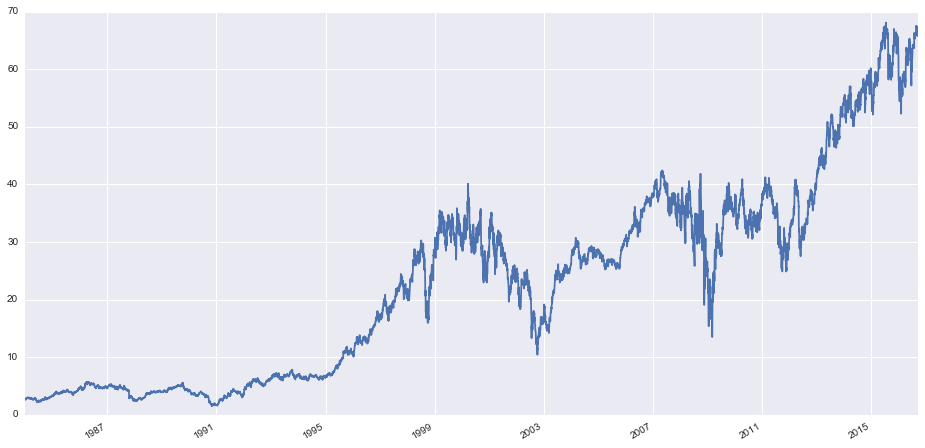

In [133]:
dfMain['Adj Close'].plot(figsize=(16, 8))

Starting from the beginning, the stock price generally has a upward trend, with a bad time from 2001 to 2003 and the crush at the end of 2008. We assume the trading price to be 30% of the Adjusted Open plus 70% of the Adjusted Close, as a simulation of someone trading near the closing time. Due to the limitation of our hardware and the nature of the time series data (so that we can't go with the usual train-CV-test way), we would like to start with a backtest within a shorter range of time. If we were given 1000 dollars from July 1, 2016 and went all in, holding it until September 27, 2016, 
we would have made 1075.2 dollars (principal included) at the end of September. This can be verified from below:

##### Start
###### Initial Condition
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 61.379999$

----------------

$Share_{start} = floor(\frac{1000.00}{61.38}) = 16$

$PV_{start} = 61.38 \cdot 16 = 982.08$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 982.08 = 17.92$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 17.92 + 982.08 = 1000.00$

##### End
###### Final Condition
$Cash_{end} = 17.92$
$Share_{end} = 16$
$Trading \ Price_{end} = 66.0750019$

----------------

$PV_{end} = 66.08 \cdot 16 = 1057.28$
$Total \ Assets_{start}  = Cash_{end} + PV_{end} = 17.92 + 1057.28 = 1075.2$

We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{61/252} = 1.0752
$$

$$
\Longrightarrow r = 0.3492324 \approx 34.92\%
$$

We call this the ROI of the patient trader, and this can be used as a benchmark in the later section.

### Algorithms and Techniques
#### Algorithms
The trading bot (from now on we refer to it as the *chimp*) consists of two parts. In the first part we implement Q-learning and run it through the historical data for some number of iterations to construct the Q-table. The chimp can then go with the optimal policy by following the action of which the state-action pair has the maximum Q value. However, since the state space is vast and the coverage of the Q-table is very small, in the second part we use supervised learning to train on the Q-table and make predictions for the unseen states.

##### Reinfocement learning
###### Q-learning
The idea of reinforcement learning is simple.
1. The chimp senses its environment (data of some sort)
2. The chimp takes an action
3. The chimp gets a reward for that action she took
4. The chimp "remembers" the association between the state-action pair and the reward, so next time when she is in the same situation, she'd carry out the action that she thinks best, under the condition that,
5. The chimp has a really good memory so she doesn't just remember the immediate reward for each state-action pair, she also remembers all the rewards that are prior to and lead to the current state-action pair so that she can maximize the total reward she gets.

One way to do this is to use a method called Q-learning. At the core of Q-learning is the Bellman equation.

In each iteration we use the Bellman equation to update the cell of our Q-table:
$$
Q(s, a) \longleftarrow (1 - \alpha) \ Q(s, a) + \alpha \ (R(s) + \gamma  \ max_{a'} Q(s', a'))
$$

where $\alpha$ is the learning rate, $R(s)$ the reward function, and $\gamma$ the discount factor.
And then the chimp will follow the policy:
$$
\pi(s) = argmax_{a}Q(s, a)
$$

Although we don't have the Q value of any state action pair to begin with, the reward function contains the "real" information and throughout the iterations that information will slowly propagate to each state-action pair. At some point the Q values will converge (hopefully), and we end up with a Q table in equilibrium.

###### Exploration-exploitation dilemma
However, there's a catch. How does the chimp know what to do before she has learned anything?

To begin with, the chimp goes out and explores the world, sensing new data as she goes, and taking actions.

One important concept of reinforcement learning is the **exploration-exploitation dilemma**. Essentially it means when we take an action, we have to choose between whether to explore new possibilities, or just to follow what we've known to be best, to the best of our knowledge. And of course, if we don't know much, then following that limited knowledge of ours wouldn't make much sense. On the other hand, if we've already known pretty much everything, then there's just not much to explore and wandering around mindlessly wouldn't make sense either.

To implement this concept, we want our chimp set out not having bias (not that she's got much anyways), so we introduce the variable $\epsilon$, which represents the possibility of the chimp taking random actions. Initially we set $\epsilon = 1$ , and gradually decreases its value as the chimp getting to know more and more about its environment.

##### Random forest
###### How random forest works
As stated earlier, the random forest is an ensemble method, which "ensembles" a bunch of decision trees. Each decision tree is generated by creating "nodes" with features in our dataset. 

###### Decision tree
In the training stage, a data point comes down and through the nodes of the decision tree. Each node classifies the data point and sends it to the next node. Say, for example we are classifying people to determine whether their annual income is above or below average, and one feature of our data is gender. And we will probably have values like male/female/other. Now say this data point is a female, then it will get sent down the path accordingly to the next node. The node at the bottom of the decision tree is sometimes referred to as a leaf. Our data point will end up in one of the leaves, and the label of the data point is going to mark that leaf. For example, if our data point is above income average, then we mark that leaf as "above count +1". At the end of the training, all leaves will be marked with labels above or below.

In the predicting stage, we run data down the decision tree and see which leaves they end up with. And then we assign the data the labels of the leaves accordingly.

###### Ensemble
We now know how each decision tree is constructed, and have a forest of decision trees. The last step is to get these decision trees to vote. If 10 trees say this person is above and 5 say below, we predict the person as above. 

###### Randomness of random forest
As said earlier, the decision trees are constructed with the features of our dataset. However, not all of the features are used to construct each decision tree. This is where the random part of the algorithm comes in. Most implementation employs a method called bagging, which generates $m$ sub-datasets from the feature space of the orginal dataset by sampling with replacement, where the size of the sub-datasets is $n'$, relative to the size of the feature space of the original dataset, $n$. The features of each bag are then used to construct a decision tree model.

###### Other parts of random forest
We won't cover everything about the random forest here. However it's worth noting some of the more important specifics of random forest that are not covered here:
* Binning of the continuous variables—which are done slightly differently from implementation to implementation
* Splitting methods—when constructing the decision trees we need to decide which feature to be placed on top of the tree and which to be put at the bottom. 
* Voting methods—we can decide to give each decision tree with the same voting power, or not.
* Modification of the algorithm for regression problems (recursive partitioning)

### Benchmark
We test our chimp against 100,000 random monkeys and the patient trader we have defined earlier. Since these two naive traders don't get influenced by the media or manipulated by the market makers, they are proven to perform better than the average investor. We are happy as long as our chimp can perform better than the two naive traders.

## Methodology
### Data Preprocessing
#### Adjust prices


In [134]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


In [135]:
As said earlier, we need to adjust the prices of Open, High, Low, Close, Volume. This can be done by getting the adjustment fact by dividing Adj Close by Close. We then multiply the prices by this factor, and divide the volume by this factor. 

SyntaxError: invalid syntax (<ipython-input-135-acffe1eb3689>, line 1)

In [ ]:
# Adjust Open, High, Low, Volume
dfMain['Adj Factor'] = dfMain['Adj Close'] / dfMain['Close']

dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']

dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

dfMain.drop(['Adj Factor'], axis=1, inplace=True)
display(dfMain.head())

#### Features engineering using volume price analysis
Volume price analysis has been around for over 100 years, and there are many legendary traders who made themselves famous using it. In addition to this, the basic principle behind it kind of makes sense on its own, that:
1. Price can only be moved by volume; large spread pushed by large volume and small spread by low volume
2. If it's not the case, then there's an anomaly, and you need to be cautious

But then people tend to think of it as an art rather than science, in that even though you have some clues what's going on on the market, you still don't know what the best timing is. 

For we data scientists, everything is science, including art. If a human can stare at the candlesticks telling you when to buy or sell, so can a computer. Thus the following features are extracted from the raw dataset:

For volume:
* -1d Volume
* -2d Volume
* -3d Volume
* -4d Volume
* -5d Volume
* 10d Average Volume
* 21d Average Volume
* 63d Average Volume

For price:
* -1d Spread
* -2d Spread
* -3d Spread
* -4d Spread
* -5d Spread
* 10d Spread
* 21d Spread
* 63d Spread

For wick:
* -1d upperwick/lowerwick
* -2d upperwick/lowerwick
* -3d upperwick/lowerwick
* -4d upperwick/lowerwick
* -5d upperwick/lowerwick
* 10d upperwick/lowerwick
* 21d upperwick/lowerwick
* 63d upperwick/lowerwick

Since to implement Q-learning we need to make the variables discrete. We use 100 day maximum and 100 day average to divide the above features and get relative levels of those features.

#### Trading price
We set the trading price of each trading day to be:
$$
Trade Price = 0.3 \ Open + 0.7 \ AdjClose
$$
This information is not available to the chimp. The properties of the chimp get updated with this information when she places an order. The portfolio value also gets updated using this price.

The reason for the slight lean to the closing price is because so that when a common user tries to follow the chimp suggestion, he or she still has time to do so.

## Implementation
We divide this section into the training section and the testing section.

In the training section, we first set up the benchmarks (the monkey and the patient trader), to see how they perform throughout the training dataset. And then see how much can our chimp can fit the data.

In the testing section, we let them compete again, this time using completely new dataset.

Note that in our simulation, without loss of generality, we set the transaction cost to be 0 to simplify our problem.

### Training section
#### The Patient Trader
As shown earlier, the ROI of the patient trader is $r = 9.00\%$

#### The Monkey
We use a `MonkeyBot` class which will place one and only one order randomly everyday. We iterate it through the time frame we choose 3,000 times and we get the following distribution:
![Alt text](./monkey_train_stats.png)
![Alt text](./monkey_train_hist.png)

where the mean is 5258.49 and the median is 3460.86. Using the mean, to get the ROI we can simply do the same calculation again as we did for the patient trader:

$$
(1 + r)^{28} = 5.258
$$

$$
\Longrightarrow r = 0.06106892 \approx 6.11\%
$$

#### The Chimp
Now comes our chimp. For the first 1000 rounds we linearly decrease the chance of our chimp going completely random (from 1 to 0.01) so that she can explore the data a bit to form her own opinion. After we iterate it through the data 3000 times, we can see the Q-table gradually converges:
![Alt text](./chimp_train.png)

![Alt text](./chimp_train_stats.png)

We can see our chimp really is learning. Just for fun, let's look at the ROI using the 3rd quartile:

$$
(1 + r)^{10.92} = 1361996000
$$

$$
	\Longrightarrow r = 5.862194 \approx 586.22\%
$$

Although 1 out of 20 we let the chimp pick a random action, still this should be quite close to the ROI if we do everything right in that 10.92 years.

Now it's time to find out if we can somewhat generalize this in the new data.

### Testing section
#### The Patient Trader
##### Start
###### Initial Condition
$Cash_{init} = 1000.00$
$Share_{init} = 0$
$PV_{init} = 0$
$Trading \ Price_{init} = 30.41$

$Share_{start} = floor(\frac{1000.00}{30.41}) = 32$
$PV_{start} = 30.41 \cdot 32 = 973.12$
$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 973.12 = 26.88$
$Total \ Assets_{start} = Cash_{start} + PV_{start} = 26.88 + 973.12 = 1000.00$
##### End
###### Final Condition
$Cash_{end} = 26.88$
$Share_{end} = 32$
$Trading \ Price_{end} = 66.08$

$PV_{end} = 66.08 \cdot 32 = 2114.56$
$Cash_{end} = 26.88$
$Total \ Assets_{end}  = Cash_{end} + PV_{end} = 26.88 + 2114.56 = 2141.44$


$$
(1 + r)^{1.75} = 2.141
$$

$$
\Longrightarrow r = 0.5449834 \approx 54.50\%
$$

#### The Monkey
We use a `MonkeyBot` class which will place one and only one order randomly everyday. We iterate it through the time frame we choose 100,000 times and we get the following distribution:
![Alt text](./monkey_test_stats.png)
![Alt text](./monkey_test_hist.png)

where the mean is 1502.14 and the median is 1478.07. Using the mean, to get the ROI we can simply do the same calculation again as we did for the patient trader:

$$
(1 + r)^{1.75} = 1.502
$$

$$
\Longrightarrow r = 0.2616946 \approx 26.17\%
$$

#### The Chimp
Now comes our chimp. For the first 150 rounds we linearly decrease the chance of our chimp going completely random (from 1 to 0.05) so that she can explore the data a bit to form her own opinion. After we iterate it through the data 3000 times, we can see the Q-table gradually converges:
![Alt text](./chimp_train.png)

![Alt text](./chimp_train_stats.png)

We can see our chimp really is learning. Just for fun, let's look at the ROI using the 3rd quartile:

$$
(1 + r)^{10.92} = 1361996000
$$

$$
	\Longrightarrow r = 5.862194 \approx 586.22\%
$$

Although 1 out of 20 we let the chimp pick a random action, still this should be quite close to the ROI if we do everything right in that 10.92 years.

Now it's time to find out if we can somewhat generalize this in the new data.

In [ ]:
# Price Engineering
# Get opens
dfMain['-1d_Open'] = dfMain['Open'].shift()
dfMain['-2d_Open'] = dfMain['Open'].shift(2)
dfMain['-3d_Open'] = dfMain['Open'].shift(3)
dfMain['-4d_Open'] = dfMain['Open'].shift(4)
dfMain['-5d_Open'] = dfMain['Open'].shift(5)
dfMain['-10d_Open'] = dfMain['Open'].shift(10)
dfMain['-21d_Open'] = dfMain['Open'].shift(21)
dfMain['-63d_Open'] = dfMain['Open'].shift(63)
dfMain['-100d_Open'] = dfMain['Open'].shift(100)

# Get adjCloses
dfMain['-1d_adjClose'] = dfMain['Adj Close'].shift()
dfMain['-2d_adjClose'] = dfMain['Adj Close'].shift(2)
dfMain['-3d_adjClose'] = dfMain['Adj Close'].shift(3)
dfMain['-4d_adjClose'] = dfMain['Adj Close'].shift(4)
dfMain['-5d_adjClose'] = dfMain['Adj Close'].shift(5)

# Get highs
dfMain['-1d_High'] = dfMain['High'].shift()
dfMain['-2d_High'] = dfMain['High'].shift(2)
dfMain['-3d_High'] = dfMain['High'].shift(3)
dfMain['-4d_High'] = dfMain['High'].shift(4)
dfMain['-5d_High'] = dfMain['High'].shift(5)
dfMain['10d_High'] = dfMain['High'].shift().rolling(window=10).max()
dfMain['21d_High'] = dfMain['High'].shift().rolling(window=21).max()
dfMain['63d_High'] = dfMain['High'].shift().rolling(window=63).max()
dfMain['100d_High'] = dfMain['High'].shift().rolling(window=100).max()

# Get lows
dfMain['-1d_Low'] = dfMain['Low'].shift()
dfMain['-2d_Low'] = dfMain['Low'].shift(2)
dfMain['-3d_Low'] = dfMain['Low'].shift(3)
dfMain['-4d_Low'] = dfMain['Low'].shift(4)
dfMain['-5d_Low'] = dfMain['Low'].shift(5)
dfMain['10d_Low'] = dfMain['Low'].shift().rolling(window=10).min()
dfMain['21d_Low'] = dfMain['Low'].shift().rolling(window=21).min()
dfMain['63d_Low'] = dfMain['Low'].shift().rolling(window=63).min()
dfMain['100d_Low'] = dfMain['Low'].shift().rolling(window=100).min()



In [103]:
dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

dfMain['Abs_Spread'] = np.abs(dfMain['Close'] - dfMain['Open'])
dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()

dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain.tail())
display(dfMain.ix[datetime(2011, 12, 30)][['Open', 'Adj Close']])

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low,100d_Avg_Vol,100d_Max_Vol,100d_Avg_Spread,100d_Max_Spread
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,67.680000,67.769997,67.769997,67.769997,66.239998,65.849998,65.440002,66.089996,66.209999,65.440002,65.410004,56.609318,56.609318,2.162303e+07,4.445207e+07,0.670126,11.160679
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,67.680000,67.769997,67.769997,67.769997,66.309998,66.239998,65.849998,65.440002,66.089996,65.440002,65.440002,56.609318,56.609318,2.158722e+07,4.445207e+07,0.661166,11.160679
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,67.430000,67.769997,67.769997,67.769997,66.839996,66.309998,66.239998,65.849998,65.440002,65.440002,65.440002,56.609318,56.609318,2.162404e+07,4.445207e+07,0.658286,11.160679
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,67.900002,67.900002,67.900002,67.900002,67.180000,66.839996,66.309998,66.239998,65.849998,65.440002,65.440002,56.609318,56.609318,2.154451e+07,4.445207e+07,0.658198,11.290684
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,67.900002,67.900002,67.900002,67.900002,65.540001,67.180000,66.839996,66.309998,66.239998,65.440002,65.440002,57.809971,56.609318,2.153319e+07,4.445207e+07,0.666044,11.290684


Open         29.013163
Adj Close    29.135839
Name: 2011-12-30 00:00:00, dtype: float64

In [104]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

# def relative_transform(num):
#     if 0 <= num < 0.25:
#         return "Very Low"
#     elif 0.25 <= num < 0.5:
#         return "Low"
#     elif 0.5 <= num < 0.75:
#         return "Average"
#     elif 0.75 <= num < 1:
#         return "High"
#     elif 1 <= num:
#         return "Very High"
#     elif -0.25 <= num < 0:
#         return "N-Very Low"
#     elif -0.5 <= num < -0.25:
#         return "N-Low"
#     elif -0.75 <= num < -0.5:
#         return "N-Average"
#     elif -1 <= num < -0.75:
#         return "N-High"
#     elif num < -1:
#         return "N-Very High"
#     else:
#         num

# Volume Engineering
# Get volumes
dfMain['-1d_Vol'] = dfMain['Volume'].shift()
dfMain['-2d_Vol'] = dfMain['Volume'].shift(2)
dfMain['-3d_Vol'] = dfMain['Volume'].shift(3)
dfMain['-4d_Vol'] = dfMain['Volume'].shift(4)
dfMain['-5d_Vol'] = dfMain['Volume'].shift(5)

# Get avg. volumes
dfMain['10d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=10).mean()
dfMain['21d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=21).mean()
dfMain['63d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=63).mean()

# Get relative volumes 1
dfMain['-1d_Vol1'] = dfMain['-1d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-2d_Vol1'] = dfMain['-2d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-3d_Vol1'] = dfMain['-3d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-4d_Vol1'] = dfMain['-4d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-5d_Vol1'] = dfMain['-5d_Vol'] / dfMain['100d_Avg_Vol']

dfMain['-1d_Vol1'] = dfMain['-1d_Vol1'].apply(relative_transform)
dfMain['-2d_Vol1'] = dfMain['-2d_Vol1'].apply(relative_transform)
dfMain['-3d_Vol1'] = dfMain['-3d_Vol1'].apply(relative_transform)
dfMain['-4d_Vol1'] = dfMain['-4d_Vol1'].apply(relative_transform)
dfMain['-5d_Vol1'] = dfMain['-5d_Vol1'].apply(relative_transform)

# Get relative avg. volumes 1 
dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol'] / dfMain['100d_Avg_Vol']

dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol1'].apply(relative_transform)
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol1'].apply(relative_transform)
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol1'].apply(relative_transform)

# Get relative volumes 2
dfMain['-1d_Vol2'] = dfMain['-1d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-2d_Vol2'] = dfMain['-2d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-3d_Vol2'] = dfMain['-3d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-4d_Vol2'] = dfMain['-4d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-5d_Vol2'] = dfMain['-5d_Vol'] / dfMain['100d_Max_Vol']

dfMain['-1d_Vol2'] = dfMain['-1d_Vol2'].apply(relative_transform)
dfMain['-2d_Vol2'] = dfMain['-2d_Vol2'].apply(relative_transform)
dfMain['-3d_Vol2'] = dfMain['-3d_Vol2'].apply(relative_transform)
dfMain['-4d_Vol2'] = dfMain['-4d_Vol2'].apply(relative_transform)
dfMain['-5d_Vol2'] = dfMain['-5d_Vol2'].apply(relative_transform)

In [105]:
# Spread Engineering
# Get spread

dfMain['-1d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-1d_Open']
dfMain['-2d_Spread'] = dfMain['-2d_adjClose'] - dfMain['-2d_Open']
dfMain['-3d_Spread'] = dfMain['-3d_adjClose'] - dfMain['-3d_Open']
dfMain['-4d_Spread'] = dfMain['-4d_adjClose'] - dfMain['-4d_Open']
dfMain['-5d_Spread'] = dfMain['-5d_adjClose'] - dfMain['-5d_Open']

dfMain['10d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-10d_Open']
dfMain['21d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-21d_Open']
dfMain['63d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-63d_Open']

# Get relative spread
dfMain['-1d_Spread'] = dfMain['-1d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-2d_Spread'] = dfMain['-2d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-3d_Spread'] = dfMain['-3d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-4d_Spread'] = dfMain['-4d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-5d_Spread'] = dfMain['-5d_Spread'] / dfMain['100d_Avg_Spread']

dfMain['-1d_Spread'] = dfMain['-1d_Spread'].apply(relative_transform)
dfMain['-2d_Spread'] = dfMain['-2d_Spread'].apply(relative_transform)
dfMain['-3d_Spread'] = dfMain['-3d_Spread'].apply(relative_transform)
dfMain['-4d_Spread'] = dfMain['-4d_Spread'].apply(relative_transform)
dfMain['-5d_Spread'] = dfMain['-5d_Spread'].apply(relative_transform)

dfMain['10d_Spread'] = dfMain['10d_Spread'] / dfMain['100d_Max_Spread']
dfMain['21d_Spread'] = dfMain['21d_Spread'] / dfMain['100d_Max_Spread']
dfMain['63d_Spread'] = dfMain['63d_Spread'] / dfMain['100d_Max_Spread']

dfMain['10d_Spread'] = dfMain['10d_Spread'].apply(relative_transform)
dfMain['21d_Spread'] = dfMain['21d_Spread'].apply(relative_transform)
dfMain['63d_Spread'] = dfMain['63d_Spread'].apply(relative_transform)

display(dfMain[['-1d_Spread', '-2d_Spread', '-3d_Spread', '-4d_Spread', '-5d_Spread', '21d_Spread']].tail())

,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,21d_Spread
2016-09-21,-2.0,1.0,-2.0,3.0,1.0,1.0
2016-09-22,1.0,-2.0,1.0,-2.0,3.0,1.0
2016-09-23,3.0,1.0,-2.0,1.0,-2.0,1.0
2016-09-26,-1.0,3.0,1.0,-2.0,1.0,1.0
2016-09-27,-5.0,-1.0,3.0,1.0,-2.0,-1.0


In [106]:
# Get wicks
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False
    
for index, row in dfMain.iterrows():
    dfMain.ix[index, '-1d_upperwick_bool'] = upperwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_High'])
    dfMain.ix[index, '-1d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_Low'])
    
    dfMain.ix[index, '-2d_upperwick_bool'] = upperwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_High'])
    dfMain.ix[index, '-2d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_Low'])
    
    dfMain.ix[index, '-3d_upperwick_bool'] = upperwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_High'])
    dfMain.ix[index, '-3d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_Low'])
    
    dfMain.ix[index, '-4d_upperwick_bool'] = upperwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_High'])
    dfMain.ix[index, '-4d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_Low'])
    
    dfMain.ix[index, '-5d_upperwick_bool'] = upperwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_High'])
    dfMain.ix[index, '-5d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_Low'])
    
    dfMain.ix[index, '10d_upperwick_bool'] = upperwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_High'])
    dfMain.ix[index, '10d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_Low'])
    
    dfMain.ix[index, '21d_upperwick_bool'] = upperwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_High'])
    dfMain.ix[index, '21d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_Low'])
    
    dfMain.ix[index, '63d_upperwick_bool'] = upperwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_High'])
    dfMain.ix[index, '63d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_Low'])
    
    dfMain.ix[index, '100d_upperwick_bool'] = upperwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_High'])
    dfMain.ix[index, '100d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_Low'])
    
# print(dfMain.head(20))

In [107]:
# Transform upper wicks
p_spread1d_up = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_upperwick_bool']
n_spread1d_up = dfMain['-1d_Spread'] < 0 & dfMain['-1d_upperwick_bool']
p_spread2d_up = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_upperwick_bool']
n_spread2d_up = dfMain['-2d_Spread'] < 0 & dfMain['-2d_upperwick_bool']
p_spread3d_up = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_upperwick_bool']
n_spread3d_up = dfMain['-3d_Spread'] < 0 & dfMain['-3d_upperwick_bool']
p_spread4d_up = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_upperwick_bool']
n_spread4d_up = dfMain['-4d_Spread'] < 0 & dfMain['-4d_upperwick_bool']
p_spread5d_up = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_upperwick_bool']
n_spread5d_up = dfMain['-5d_Spread'] < 0 & dfMain['-5d_upperwick_bool']
p_spread10d_up = dfMain['10d_Spread'] >= 0 & dfMain['10d_upperwick_bool']
n_spread10d_up = dfMain['10d_Spread'] < 0 & dfMain['10d_upperwick_bool']
p_spread21d_up = dfMain['21d_Spread'] >= 0 & dfMain['21d_upperwick_bool']
n_spread21d_up = dfMain['21d_Spread'] < 0 & dfMain['21d_upperwick_bool']
p_spread63d_up = dfMain['63d_Spread'] >= 0 & dfMain['63d_upperwick_bool']
n_spread63d_up = dfMain['63d_Spread'] < 0 & dfMain['63d_upperwick_bool']

false1d_up = np.logical_not(dfMain['-1d_upperwick_bool'])
false2d_up = np.logical_not(dfMain['-2d_upperwick_bool'])
false3d_up = np.logical_not(dfMain['-3d_upperwick_bool'])
false4d_up = np.logical_not(dfMain['-4d_upperwick_bool'])
false5d_up = np.logical_not(dfMain['-5d_upperwick_bool'])
false10d_up = np.logical_not(dfMain['10d_upperwick_bool'])
false21d_up = np.logical_not(dfMain['21d_upperwick_bool'])
false63d_up = np.logical_not(dfMain['63d_upperwick_bool'])

dfMain.loc[p_spread1d_up, '-1d_upperwick'] = dfMain.loc[p_spread1d_up, '-1d_High'] - dfMain.loc[p_spread1d_up, '-1d_adjClose']
dfMain.loc[n_spread1d_up, '-1d_upperwick'] = dfMain.loc[n_spread1d_up, '-1d_High'] - dfMain.loc[n_spread1d_up, '-1d_Open']

dfMain.loc[p_spread2d_up, '-2d_upperwick'] = dfMain.loc[p_spread2d_up, '-2d_High'] - dfMain.loc[p_spread2d_up, '-2d_adjClose']
dfMain.loc[n_spread2d_up, '-2d_upperwick'] = dfMain.loc[n_spread2d_up, '-2d_High'] - dfMain.loc[n_spread2d_up, '-2d_Open']

dfMain.loc[p_spread3d_up, '-3d_upperwick'] = dfMain.loc[p_spread3d_up, '-3d_High'] - dfMain.loc[p_spread3d_up, '-3d_adjClose']
dfMain.loc[n_spread3d_up, '-3d_upperwick'] = dfMain.loc[n_spread3d_up, '-3d_High'] - dfMain.loc[n_spread3d_up, '-3d_Open']

dfMain.loc[p_spread4d_up, '-4d_upperwick'] = dfMain.loc[p_spread4d_up, '-4d_High'] - dfMain.loc[p_spread4d_up, '-4d_adjClose']
dfMain.loc[n_spread4d_up, '-4d_upperwick'] = dfMain.loc[n_spread4d_up, '-4d_High'] - dfMain.loc[n_spread4d_up, '-4d_Open']

dfMain.loc[p_spread5d_up, '-5d_upperwick'] = dfMain.loc[p_spread5d_up, '-5d_High'] - dfMain.loc[p_spread5d_up, '-5d_adjClose']
dfMain.loc[n_spread5d_up, '-5d_upperwick'] = dfMain.loc[n_spread5d_up, '-5d_High'] - dfMain.loc[n_spread5d_up, '-5d_Open']

dfMain.loc[p_spread10d_up, '10d_upperwick'] = dfMain.loc[p_spread10d_up, '10d_High'] - dfMain.loc[p_spread10d_up, '-1d_adjClose']
dfMain.loc[n_spread10d_up, '10d_upperwick'] = dfMain.loc[n_spread10d_up, '10d_High'] - dfMain.loc[n_spread10d_up, '-10d_Open']

dfMain.loc[p_spread21d_up, '21d_upperwick'] = dfMain.loc[p_spread21d_up, '21d_High'] - dfMain.loc[p_spread21d_up, '-1d_adjClose']
dfMain.loc[n_spread21d_up, '21d_upperwick'] = dfMain.loc[n_spread21d_up, '21d_High'] - dfMain.loc[n_spread21d_up, '-21d_Open']

dfMain.loc[p_spread63d_up, '63d_upperwick'] = dfMain.loc[p_spread63d_up, '63d_High'] - dfMain.loc[p_spread63d_up, '-1d_adjClose']
dfMain.loc[n_spread63d_up, '63d_upperwick'] = dfMain.loc[n_spread63d_up, '63d_High'] - dfMain.loc[n_spread63d_up, '-63d_Open']

# Get relative upperwick length
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] / dfMain.loc[dfMain['-1d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] / dfMain.loc[dfMain['-2d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] / dfMain.loc[dfMain['-3d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] / dfMain.loc[dfMain['-4d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] / dfMain.loc[dfMain['-5d_upperwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] / dfMain.loc[dfMain['10d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] / dfMain.loc[dfMain['21d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] / dfMain.loc[dfMain['63d_upperwick_bool'], '100d_Max_Spread']

# Transform upperwick ratio to int
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'].apply(relative_transform)

# Assign 0 to no-upperwick days
dfMain.loc[false1d_up, '-1d_upperwick'] = 0
dfMain.loc[false2d_up, '-2d_upperwick'] = 0
dfMain.loc[false3d_up, '-3d_upperwick'] = 0
dfMain.loc[false4d_up, '-4d_upperwick'] = 0
dfMain.loc[false5d_up, '-5d_upperwick'] = 0
dfMain.loc[false10d_up, '10d_upperwick'] = 0
dfMain.loc[false21d_up, '21d_upperwick'] = 0
dfMain.loc[false63d_up, '63d_upperwick'] = 0

In [108]:
display(dfMain[['-1d_upperwick', '-2d_upperwick', '-3d_upperwick', '-4d_upperwick', '-5d_upperwick', '10d_upperwick', '21d_upperwick', '63d_upperwick']].isnull().sum())


-1d_upperwick    76
-2d_upperwick    76
-3d_upperwick    75
-4d_upperwick    74
-5d_upperwick    74
10d_upperwick    87
21d_upperwick    78
63d_upperwick    37
dtype: int64

In [109]:
# Transform lower wicks
p_spread1d_lw = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_lowerwick_bool']
n_spread1d_lw = dfMain['-1d_Spread'] < 0 & dfMain['-1d_lowerwick_bool']
p_spread2d_lw = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_lowerwick_bool']
n_spread2d_lw = dfMain['-2d_Spread'] < 0 & dfMain['-2d_lowerwick_bool']
p_spread3d_lw = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_lowerwick_bool']
n_spread3d_lw = dfMain['-3d_Spread'] < 0 & dfMain['-3d_lowerwick_bool']
p_spread4d_lw = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_lowerwick_bool']
n_spread4d_lw = dfMain['-4d_Spread'] < 0 & dfMain['-4d_lowerwick_bool']
p_spread5d_lw = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_lowerwick_bool']
n_spread5d_lw = dfMain['-5d_Spread'] < 0 & dfMain['-5d_lowerwick_bool']
p_spread10d_lw = dfMain['10d_Spread'] >= 0 & dfMain['10d_lowerwick_bool']
n_spread10d_lw = dfMain['10d_Spread'] < 0 & dfMain['10d_lowerwick_bool']
p_spread21d_lw = dfMain['21d_Spread'] >= 0 & dfMain['21d_lowerwick_bool']
n_spread21d_lw = dfMain['21d_Spread'] < 0 & dfMain['21d_lowerwick_bool']
p_spread63d_lw = dfMain['63d_Spread'] >= 0 & dfMain['63d_lowerwick_bool']
n_spread63d_lw = dfMain['63d_Spread'] < 0 & dfMain['63d_lowerwick_bool']

false1d_lw = np.logical_not(dfMain['-1d_lowerwick_bool'])
false2d_lw = np.logical_not(dfMain['-2d_lowerwick_bool'])
false3d_lw = np.logical_not(dfMain['-3d_lowerwick_bool'])
false4d_lw = np.logical_not(dfMain['-4d_lowerwick_bool'])
false5d_lw = np.logical_not(dfMain['-5d_lowerwick_bool'])
false10d_lw = np.logical_not(dfMain['10d_lowerwick_bool'])
false21d_lw = np.logical_not(dfMain['21d_lowerwick_bool'])
false63d_lw = np.logical_not(dfMain['63d_lowerwick_bool'])

# Get lowerwick length
dfMain.loc[p_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[p_spread1d_lw, '-1d_Open'] - dfMain.loc[p_spread1d_lw, '-1d_Low']
dfMain.loc[n_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[n_spread1d_lw, '-1d_adjClose'] - dfMain.loc[n_spread1d_lw, '-1d_Low']

dfMain.loc[p_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[p_spread2d_lw, '-2d_Open'] - dfMain.loc[p_spread2d_lw, '-2d_Low']
dfMain.loc[n_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[n_spread2d_lw, '-2d_adjClose'] - dfMain.loc[n_spread2d_lw, '-2d_Low']

dfMain.loc[p_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[p_spread3d_lw, '-3d_Open'] - dfMain.loc[p_spread3d_lw, '-3d_Low']
dfMain.loc[n_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[n_spread3d_lw, '-3d_adjClose'] - dfMain.loc[n_spread3d_lw, '-3d_Low']

dfMain.loc[p_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[p_spread4d_lw, '-4d_Open'] - dfMain.loc[p_spread4d_lw, '-4d_Low']
dfMain.loc[n_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[n_spread4d_lw, '-4d_adjClose'] - dfMain.loc[n_spread4d_lw, '-4d_Low']

dfMain.loc[p_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[p_spread5d_lw, '-5d_Open'] - dfMain.loc[p_spread5d_lw, '-5d_Low']
dfMain.loc[n_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[n_spread5d_lw, '-5d_adjClose'] - dfMain.loc[n_spread5d_lw, '-5d_Low']

dfMain.loc[p_spread10d_lw, '10d_lowerwick'] = dfMain.loc[p_spread10d_lw, '-10d_Open'] - dfMain.loc[p_spread10d_lw, '10d_Low']
dfMain.loc[n_spread10d_lw, '10d_lowerwick'] = dfMain.loc[n_spread10d_lw, '-1d_adjClose'] - dfMain.loc[n_spread10d_lw, '10d_Low']

dfMain.loc[p_spread21d_lw, '21d_lowerwick'] = dfMain.loc[p_spread21d_lw, '-21d_Open'] - dfMain.loc[p_spread21d_lw, '21d_Low']
dfMain.loc[n_spread21d_lw, '21d_lowerwick'] = dfMain.loc[n_spread21d_lw, '-1d_adjClose'] - dfMain.loc[n_spread21d_lw, '21d_Low']

dfMain.loc[p_spread63d_lw, '63d_lowerwick'] = dfMain.loc[p_spread63d_lw, '-63d_Open'] - dfMain.loc[p_spread63d_lw, '63d_Low']
dfMain.loc[n_spread63d_lw, '63d_lowerwick'] = dfMain.loc[n_spread63d_lw, '-1d_adjClose'] - dfMain.loc[n_spread63d_lw, '63d_Low']

# Get relative lowerwick length
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] / dfMain.loc[dfMain['-1d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] / dfMain.loc[dfMain['-2d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] / dfMain.loc[dfMain['-3d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] / dfMain.loc[dfMain['-4d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] / dfMain.loc[dfMain['-5d_lowerwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] / dfMain.loc[dfMain['10d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] / dfMain.loc[dfMain['21d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] / dfMain.loc[dfMain['63d_lowerwick_bool'], '100d_Max_Spread']

# Tranform lowerwick ratio to int
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'].apply(relative_transform)

# Assign 0 to no-lowerwick days
dfMain.loc[false1d_lw, '-1d_lowerwick'] = 0
dfMain.loc[false2d_lw, '-2d_lowerwick'] = 0
dfMain.loc[false3d_lw, '-3d_lowerwick'] = 0
dfMain.loc[false4d_lw, '-4d_lowerwick'] = 0
dfMain.loc[false5d_lw, '-5d_lowerwick'] = 0
dfMain.loc[false10d_lw, '10d_lowerwick'] = 0
dfMain.loc[false21d_lw, '21d_lowerwick'] = 0
dfMain.loc[false63d_lw, '63d_lowerwick'] = 0

In [110]:
# dfMain.dropna(inplace=True)
display(dfMain[['-1d_lowerwick', '-2d_lowerwick', '-3d_lowerwick', '-4d_lowerwick', '-5d_lowerwick', '10d_lowerwick', '21d_lowerwick', '63d_lowerwick']].isnull().sum())

-1d_lowerwick    65
-2d_lowerwick    65
-3d_lowerwick    65
-4d_lowerwick    64
-5d_lowerwick    63
10d_lowerwick    82
21d_lowerwick    74
63d_lowerwick    34
dtype: int64

In [120]:
display(dfMain.tail())

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2016-09-21,2.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,-2.0,1.0,-2.0,3.0,1.0,-1.0,1.0,2.0,1.0,3.0,2.0,2.0,5.0,1.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,3.0,66.839996
2016-09-22,3.0,2.0,3.0,5.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,-2.0,1.0,-2.0,3.0,-1.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,2.0,1.0,1.0,3.0,67.269999
2016-09-23,3.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,3.0,1.0,-2.0,1.0,-2.0,1.0,1.0,3.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,1.0,1.0,2.0,67.292000
2016-09-26,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,2.0,-1.0,3.0,1.0,-2.0,1.0,1.0,1.0,4.0,4.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,1.0,1.0,1.0,66.025999
2016-09-27,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,-5.0,-1.0,3.0,1.0,-2.0,-1.0,-1.0,3.0,2.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,2.0,1.0,1.0,1.0,66.075002


In [113]:
dfMain['Trade Price'] = dfMain['Open'] * 0.3 + dfMain['Adj Close'] * 0.7
print(dfMain[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price      Open  Adj Close
1983-12-30     2.602623  2.602623   2.602623
1984-01-03     2.601514  2.598926   2.602623
1984-01-04     2.695230  2.652532   2.713529
1984-01-05     2.792274  2.768984   2.802256
1984-01-06     2.772681  2.772681   2.772681


In [114]:
display(dfMain.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-2d_Open', u'-3d_Open', u'-4d_Open',
       ...
       u'63d_upperwick', u'-1d_lowerwick', u'-2d_lowerwick', u'-3d_lowerwick',
       u'-4d_lowerwick', u'-5d_lowerwick', u'10d_lowerwick', u'21d_lowerwick',
       u'63d_lowerwick', u'Trade Price'],
      dtype='object', length=106)

In [115]:
dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)

In [116]:
display(dfMain.columns)
dfMain.ix[:,:-1]

Index([u'-1d_Vol1', u'-2d_Vol1', u'-3d_Vol1', u'-4d_Vol1', u'-5d_Vol1',
       u'10d_Avg_Vol1', u'21d_Avg_Vol1', u'63d_Avg_Vol1', u'-1d_Vol2',
       u'-2d_Vol2', u'-3d_Vol2', u'-4d_Vol2', u'-5d_Vol2', u'-1d_Spread',
       u'-2d_Spread', u'-3d_Spread', u'-4d_Spread', u'-5d_Spread',
       u'10d_Spread', u'21d_Spread', u'63d_Spread', u'-1d_upperwick',
       u'-2d_upperwick', u'-3d_upperwick', u'-4d_upperwick', u'-5d_upperwick',
       u'10d_upperwick', u'21d_upperwick', u'63d_upperwick', u'-1d_lowerwick',
       u'-2d_lowerwick', u'-3d_lowerwick', u'-4d_lowerwick', u'-5d_lowerwick',
       u'10d_lowerwick', u'21d_lowerwick', u'63d_lowerwick', u'Trade Price'],
      dtype='object')

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick
1983-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1984-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1984-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [121]:
dfMain.dropna(inplace=True)

print(dfMain.isnull().sum())

display(dfMain.head())

-1d_Vol1         0
-2d_Vol1         0
-3d_Vol1         0
-4d_Vol1         0
-5d_Vol1         0
10d_Avg_Vol1     0
21d_Avg_Vol1     0
63d_Avg_Vol1     0
-1d_Vol2         0
-2d_Vol2         0
-3d_Vol2         0
-4d_Vol2         0
-5d_Vol2         0
-1d_Spread       0
-2d_Spread       0
-3d_Spread       0
-4d_Spread       0
-5d_Spread       0
10d_Spread       0
21d_Spread       0
63d_Spread       0
-1d_upperwick    0
-2d_upperwick    0
-3d_upperwick    0
-4d_upperwick    0
-5d_upperwick    0
10d_upperwick    0
21d_upperwick    0
63d_upperwick    0
-1d_lowerwick    0
-2d_lowerwick    0
-3d_lowerwick    0
-4d_lowerwick    0
-5d_lowerwick    0
10d_lowerwick    0
21d_lowerwick    0
63d_lowerwick    0
Trade Price      0
dtype: int64


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-3.0,-2.0,-3.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.498467
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-3.0,-3.0,-3.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.504116
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.489427
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.422755
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.267943


In [118]:
print("-1d_VolAvg1.5 Var: {}".format(np.var(dfMain['-1d_Vol1'])))
print("-1d_VolMax Var: {}".format(np.var(dfMain['-1d_Vol2'])))

print("10d_VolAvg1.5 Var: {}".format(np.var(dfMain['10d_Avg_Vol1'])))
print("21d_VolAvg1.5 Var: {}".format(np.var(dfMain['21d_Avg_Vol1'])))
print("63d_VolAvg1.5 Var: {}".format(np.var(dfMain['63d_Avg_Vol1'])))
print("\n")

print("-1d_Spread Var: {}".format(np.var(dfMain['-1d_Spread'])))
print("10d_Spread Var: {}".format(np.var(dfMain['10d_Spread'])))
print("21d_Spread Var: {}".format(np.var(dfMain['21d_Spread'])))
print("63d_Spread Var: {}".format(np.var(dfMain['63d_Spread'])))
print("\n")

print("-1d_upperwick Var: {}".format(np.var(dfMain['-1d_upperwick'])))
print("10d_upperwick Var: {}".format(np.var(dfMain['10d_upperwick'])))
print("21d_upperwick Var: {}".format(np.var(dfMain['21d_upperwick'])))
print("63d_upperwick Var: {}".format(np.var(dfMain['63d_upperwick'])))
print("\n")

print("-1d_lowerwick Var: {}".format(np.var(dfMain['-1d_lowerwick'])))
print("10d_lowerwick Var: {}".format(np.var(dfMain['10d_lowerwick'])))
print("21d_lowerwick Var: {}".format(np.var(dfMain['21d_lowerwick'])))
print("63d_lowerwick Var: {}".format(np.var(dfMain['63d_lowerwick'])))


-1d_VolAvg1.5 Var: 1.14531550171
-1d_VolMax Var: 0.682164563931
10d_VolAvg1.5 Var: 0.695425155399
21d_VolAvg1.5 Var: 0.499789102088
63d_VolAvg1.5 Var: 0.123762017678


-1d_Spread Var: 1.11733284089
10d_Spread Var: 1.75052946215
21d_Spread Var: 2.58334960906
63d_Spread Var: 4.65430521878


-1d_upperwick Var: 0.157222897972
10d_upperwick Var: 0.0709857358508
21d_upperwick Var: 0.147321985866
63d_upperwick Var: 0.413770053717


-1d_lowerwick Var: 0.138975771259
10d_lowerwick Var: 0.0843144267942
21d_lowerwick Var: 0.181603938381
63d_lowerwick Var: 0.516349947481


In [20]:
data_full = dfMain
# data_full.to_csv('data_full.csv')

/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Monkey: 100000 times simulation took 11478.087127 seconds
100000 iterations took 11478.1825349 seconds


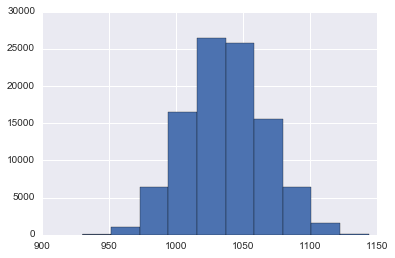

In [141]:
import random
import time

class MonkeyBot:
    def __init__(self, dfEnv):
        self.cash = 1000
        self.share = 0
        self.pv = 0
        self.pv_history_list = []
        self.env = dfEnv
        
    def trading_fee(self):
        self.cash = self.cash - 5

    def buy(self, stock_price):
        num_affordable = self.cash // stock_price
        self.cash = self.cash - stock_price * num_affordable
        self.share = self.share + num_affordable
        self.pv = stock_price * self.share
#         self.trading_fee()

    def sell(self, stock_price):
        self.cash = self.cash + stock_price * self.share
        self.pv = 0
        self.share = 0
#         self.trading_fee()

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def make_decision(self, x):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x)
        else:
            self.sell(x)

        return self.pv # for frame-wise operation

    def simulate(self, iters):
        start_time = time.time()
        for i in range(iters):
            self.env['Monkey PV'] = self.env['Trade Price'].apply(self.make_decision)
            self.pv_history_list.append(self.env.ix[-1, 'Monkey PV'] + self.cash)
            self.reset()
        print("Monkey: {0} times simulation took {1} seconds".format(iters, time.time() - start_time))

monkey = MonkeyBot(data_full.ix[datetime(2016, 7, 1):, :])

start_time = time.time()
iters = 100000

monkey.simulate(iters)
plt.hist(monkey.pv_history_list)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
# def monkey_simulation(x, monkey):
#     random_choice = random.randint(0, 2)
#     if random_choice == 0:
#         monkey.hold()
#     elif random_choice == 1:
#         monkey.buy(x)
#     else:
#         monkey.sell(x)
        
#     return monkey.pv

# start_time = time.time()
# iters = 10000

# for i in range(iters):
#     data_train['Monkey PV'] = data_train['Trade Price'].apply(monkey_simulation, args=(monkey, ))
#     monkey.pv_history_list.append(data_train.ix[-1, 'Monkey PV'])

#     monkey.reset()

# print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

# print(monkey.pv_history_list)
# print(data_train['Test'].head())
# plt.hist(monkey.pv_history_list)


(array([  4.00000000e+00,   5.00000000e+00,   8.00000000e+00,
          2.50000000e+01,   5.50000000e+01,   7.20000000e+01,
          1.17000000e+02,   1.98000000e+02,   2.74000000e+02,
          4.47000000e+02,   6.23000000e+02,   9.27000000e+02,
          1.11400000e+03,   1.48700000e+03,   2.21800000e+03,
          2.39100000e+03,   2.91700000e+03,   3.33900000e+03,
          3.75300000e+03,   4.15000000e+03,   4.92400000e+03,
          5.03100000e+03,   5.33000000e+03,   5.55400000e+03,
          5.58500000e+03,   5.53200000e+03,   5.45300000e+03,
          5.14100000e+03,   4.86500000e+03,   4.76400000e+03,
          4.11300000e+03,   3.52000000e+03,   3.20000000e+03,
          2.64300000e+03,   2.15100000e+03,   1.91800000e+03,
          1.54000000e+03,   1.21600000e+03,   9.56000000e+02,
          7.61000000e+02,   5.61000000e+02,   3.82000000e+02,
          2.70000000e+02,   1.82000000e+02,   1.31000000e+02,
          7.40000000e+01,   3.50000000e+01,   2.70000000e+01,
        

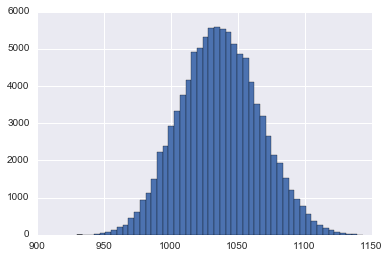

In [142]:
plt.hist(monkey.pv_history_list, bins=50)

In [143]:
statistics = pd.Series(monkey.pv_history_list)
print(statistics.describe())
print(statistics.mean() + 1.645 * statistics.std())

count    100000.000000
mean       1036.827956
std          29.767510
min         929.989965
25%        1016.220004
50%        1036.414105
75%        1057.070983
max        1143.639400
dtype: float64
1085.79551001


In [22]:
monkey_test = MonkeyBot(data_test)
monkey_test.simulate(1000)
plt.hist(monkey_test.pv_history_list, bins=50)

/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Monkey: 1000 times simulation took 62.7864639759 seconds


(array([  1.,   3.,   2.,   8.,  10.,  14.,  24.,  23.,  22.,  40.,  46.,
         66.,  49.,  59.,  32.,  44.,  58.,  67.,  49.,  52.,  40.,  45.,
         34.,  35.,  35.,  22.,  12.,  12.,  15.,  18.,   7.,  13.,   6.,
          8.,   8.,   4.,   1.,   2.,   5.,   1.,   1.,   0.,   3.,   0.,
          1.,   0.,   0.,   1.,   0.,   2.]),
 array([  716.46676013,   761.31482543,   806.16289074,   851.01095604,
          895.85902134,   940.70708665,   985.55515195,  1030.40321726,
         1075.25128256,  1120.09934786,  1164.94741317,  1209.79547847,
         1254.64354377,  1299.49160908,  1344.33967438,  1389.18773969,
         1434.03580499,  1478.88387029,  1523.7319356 ,  1568.5800009 ,
         1613.42806621,  1658.27613151,  1703.12419681,  1747.97226212,
         1792.82032742,  1837.66839273,  1882.51645803,  1927.36452333,
         1972.21258864,  2017.06065394,  2061.90871925,  2106.75678455,
         2151.60484985,  2196.45291516,  2241.30098046,  2286.14904577,
         2

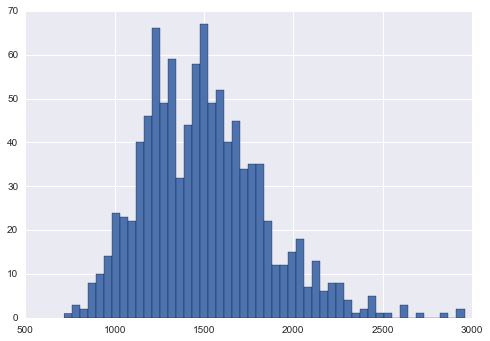

In [24]:
test_stats = pd.Series(monkey_test.pv_history_list)
print(test_stats.describe())

count    1000.000000
mean     1502.137638
std       339.962822
min       716.466760
25%      1251.226833
50%      1478.072074
75%      1700.623165
max      2958.870025
dtype: float64


In [64]:
display(data_test.head())
display(data_test.tail())

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2012-01-03,2.0,2.0,2.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,30.409929
2012-01-04,3.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,30.710912
2012-01-05,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,31.233395
2012-01-06,3.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,31.295175
2012-01-09,2.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,-1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,31.191913


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2016-09-21,2.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,-2.0,1.0,-2.0,3.0,1.0,-1.0,1.0,2.0,1.0,3.0,2.0,2.0,5.0,1.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,3.0,66.839996
2016-09-22,3.0,2.0,3.0,5.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,-2.0,1.0,-2.0,3.0,-1.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,2.0,1.0,1.0,3.0,67.269999
2016-09-23,3.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,3.0,1.0,-2.0,1.0,-2.0,1.0,1.0,3.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,1.0,1.0,2.0,67.292000
2016-09-26,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,2.0,-1.0,3.0,1.0,-2.0,1.0,1.0,1.0,4.0,4.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,1.0,1.0,1.0,66.025999
2016-09-27,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,-5.0,-1.0,3.0,1.0,-2.0,-1.0,-1.0,3.0,2.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,2.0,1.0,1.0,1.0,66.075002


In [ ]:
class ChimpBot(MonkeyBot):
    super(ChimpBot, self).__init__(dfEnv)  # sets self.env = env, state = None, next_waypoint = None, and a default color

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
print(dfTest)
constant = 10
result = 0

def divide(x):
    global constant
    constant = x / constant
    print(constant)

dfTest['Result'] = dfTest['Test'].apply(divide)

print(dfTest['Result'].iloc[-1])

# temp = 10

# for index, row in dfTest.iterrows():
#     temp = dfTest.ix[index, 'Result'] / temp

# print(temp)
    

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
print(dfTest)

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
# print(dfTest)

# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))

# print('===================')

# for i in dfTest.iterrows():
#     print(i)
    
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))

iterDf = data_train.iterrows()
print(iterDf.next()[1][:-2])
# print(next(iterDf)[1])


In [ ]:
lst = [1, 2, 3]
lst_iter = iter(lst)
type(lst_iter)

In [ ]:
test = pd.DataFrame([(1, 2)])
print(test)
test2 = pd.DataFrame([(3, 4)])
test = test.append(test2, ignore_index=True)
print(test)

In [ ]:
print((list(test.columns)))
lst = list(test.columns)
print(lst.append(2))


count    3.500000e+03
mean     8.726201e+22
std      2.309200e+23
min      2.263796e+03
25%      2.870681e+09
50%      1.635762e+15
75%      3.838499e+20
max      1.090731e+24
dtype: float64

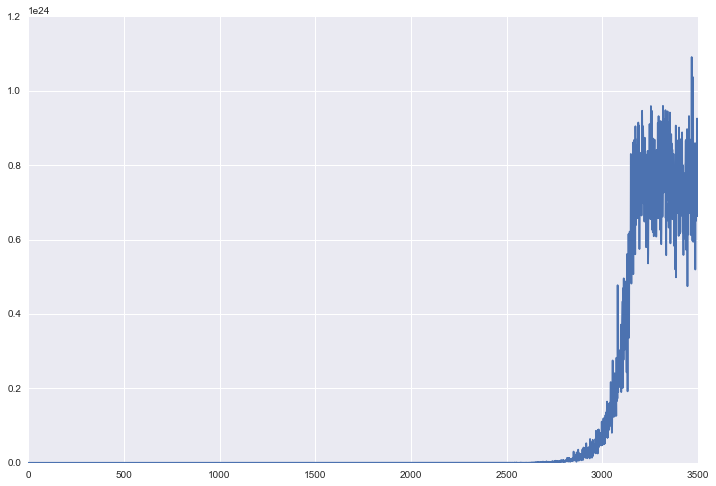

In [69]:
pv_history = [7294.7772170869093, 3241.8764040809178, 6914.9193129216792, 6402.1575970952572, 16052.598334620379, 5952.4297145372257, 8592.3968576679563, 1881.99444227903, 2726.8767781367428, 4041.8825917345139, 15458.251425979435, 10950.492680504629, 4087.7543726950335, 2818.7876011305693, 24967.483499903745, 20650.149809686256, 4880.1665638572031, 3470.4069371725227, 69482.363870625675, 3795.3316450842922, 18386.666777343002, 711.78323058928595, 35849.498709587984, 7570.7476098291327, 8860.4251262422986, 2238.7238748249488, 9273.7425302987249, 33385.648023599482, 17496.921200672146, 28085.589399855351, 18104.896648506699, 10314.433157917358, 10270.229327879133, 16575.274064134108, 25287.970081104566, 152846.27782987867, 14324.279839980116, 55447.715759280953, 46525.768810845046, 34046.876627082493, 23214.696452002223, 82744.119134882712, 29905.200986458927, 11878.443642262504, 56535.310105754739, 99685.081836978556, 83399.304251780908, 58874.715043600139, 284016.81700218446, 36470.800512784503, 49014.451693544404, 29561.397103949988, 72691.39519314967, 55228.806569697699, 184415.92908291356, 96381.276369872634, 125645.20937858772, 329516.07765572972, 18289.959761845083, 271541.65198033018, 70821.938655774778, 32233.222466493487, 116754.81486299571, 73227.307672914409, 89140.12587041581, 129673.86751164324, 176340.96673717606, 324981.6564132917, 73348.219259303092, 325536.32165284274, 142953.78659971544, 115704.80095167171, 182045.10868512242, 440846.60678908392, 544794.00886046165, 192888.6781527792, 73489.945499248119, 64199.917147077438, 190606.44378172423, 925894.04426979763, 390930.5169617678, 336889.49946460791, 478988.48430807638, 296755.03720623488, 154254.79806534573, 935376.55488940713, 569150.08557921497, 1413563.928183252, 237417.16431612935, 402683.26331912744, 1212720.7867718402, 1871184.256344059, 143329.97414082312, 138934.20329326502, 478259.90998811222, 1490867.1423274414, 308892.52972938085, 376691.29166551778, 715187.65756133734, 686269.41826488613, 136194.36025200825, 199096.03484228614, 660190.24842124723, 2332595.4307757369, 597035.02457354148, 2075548.062140387, 1584674.0893105471, 423596.36145619286, 661774.37625716696, 1011559.7770503815, 1097635.5227175336, 1297806.5633096362, 2060314.351821037, 3260582.2683089916, 238121.83054605877, 2640263.1004860462, 500068.33293622383, 3362529.6755797127, 1410176.5490697024, 883569.15136757598, 2020461.5783851119, 620467.38753636845, 1557507.5046712116, 17194256.605095126, 2011425.1862110873, 1038177.811377269, 1866903.9131691072, 718704.99644247093, 5486923.2992074238, 2708300.3573747757, 811214.36469510884, 5298372.1057469016, 7035696.2822413044, 2292326.7920455458, 3697832.7229987187, 19798932.394017767, 15287105.60460729, 1890769.8030326322, 5750075.2140090428, 3117378.1790273651, 1822423.7351824432, 21574812.810883559, 3385407.2500641476, 3479782.32796608, 3314556.9125803695, 5127158.004311312, 22894631.607567776, 5773344.7486244207, 14226860.37271202, 5566205.1871687574, 10128075.423843058, 13567152.303204875, 8001083.4451769199, 7775923.0491156476, 13652750.734380465, 4034750.8731664908, 2509401.4512354247, 65993092.014345534, 5481251.2720249714, 22806159.469096128, 55209284.973892242, 21098491.810885321, 36375717.428638279, 8329248.6977340439, 5706462.628607396, 14308211.586194471, 26803487.601909108, 6582146.7726522582, 17916762.927325003, 15158863.177069537, 7088025.7710819887, 95153140.852251917, 4788205.4103316981, 48938252.731762417, 59823389.445135571, 29584340.63401971, 46914535.884130001, 44631046.397803135, 15257419.563843016, 61470159.456669956, 9681020.5725240242, 5804873.1813432239, 276157052.20585787, 54390123.194946371, 5698878.9768391121, 4769770.9025889421, 65926662.803450897, 13168284.983108949, 57718456.761352345, 54533417.206280455, 60383873.958643109, 49771897.037895143, 29859430.56511616, 211343184.80289942, 21190815.675681978, 52102095.65268629, 47831284.842032216, 102677548.14744948, 225987779.51943669, 150984280.21066341, 235165039.46350235, 25001764.712634295, 115624624.75072083, 129768239.6802308, 91998667.151110768, 120719092.05501384, 78409573.001281202, 35818334.360874027, 98179318.918340847, 649983016.52224874, 69927343.067181826, 402901268.31488299, 275026240.09089494, 55445293.477863677, 316575894.17961687, 64699620.262418486, 130837171.25869061, 356263243.90588552, 49335569.635177575, 350622396.86588269, 384445807.57632864, 146725002.26380956, 418246181.30949503, 362782304.61761487, 241388996.35099757, 346718097.74280453, 73864598.694022983, 361835812.37220937, 25549290.814282496, 412387598.42590237, 43104918.280081347, 364231774.00841349, 128112980.86941622, 755397591.65235746, 244660169.5511564, 1472589594.9126561, 64820352.416842028, 463753444.27088135, 206624051.52319133, 979896046.47995722, 336978302.26574373, 622331331.27011406, 60890148.425839573, 1684371283.7868242, 520256087.6669507, 1881031988.8874154, 341657609.65240198, 1467554448.3842652, 1615128947.940629, 1483048015.4513128, 991982675.30024683, 816942202.16098547, 1075351740.7452869, 297467754.53296906, 2042462129.8380013, 809979596.31387424, 1587763988.9498909, 1976175555.4602616, 348525130.94694638, 1528077425.1454928, 466282795.39621669, 899079451.99318993, 623974440.43194616, 1513024368.5981627, 3474159656.0605426, 1005834314.936537, 3082501761.4553928, 1535757205.9086053, 810709214.99948955, 3820768910.6092563, 2684905400.8316603, 947719890.55977058, 5613455114.9970026, 465973906.35191035, 3627642938.7665801, 7602916807.7537794, 10299640132.165594, 2862568715.7133169, 4835838824.05509, 1110805064.0134025, 5912625953.6134949, 6123461873.7392778, 2094841648.6108377, 4851961705.4713373, 4522387885.0611906, 2513522689.2816725, 4965789768.494586, 2318972851.7005482, 2517848361.1643734, 7328666284.1693239, 3462248188.027195, 7700258632.0313482, 3334842282.328052, 6304217702.7388372, 11293461998.933115, 48655232946.437729, 25186874759.753559, 1790296510.9293494, 21306770208.608528, 11724046377.352467, 3936518975.1471219, 5679274470.5750237, 3775609953.2061586, 34037895215.678135, 92385966883.064575, 13099195267.593939, 4753481304.5290136, 3492814412.3666239, 2072975413.1417723, 7132876215.058053, 26429082044.881336, 7865210112.0352373, 28804839056.261723, 11849557526.339947, 6188920907.3170509, 2875824146.2977328, 22091402694.592747, 117781894268.21039, 5509569220.8791409, 10149768758.968233, 18317243713.504414, 35073804273.313705, 11672715233.551638, 24848679439.440903, 54496387665.15638, 60486410573.038643, 49627032618.085732, 27420986168.661091, 43091856219.356712, 25993757068.310993, 27630546581.054935, 30730956237.331619, 12081738694.865913, 15259585071.280258, 255251269340.58551, 108410970454.47934, 10461023525.994677, 34039506881.902161, 229891537895.56256, 33088642352.347523, 37976572275.804855, 76230718195.270004, 23893523266.885075, 95795105998.553299, 72061512195.301743, 79979140302.554245, 150322740725.18277, 153076937675.35358, 36027561617.328384, 120014819531.66266, 132753690284.85345, 14950669046.610151, 255812516806.40543, 37359981769.376831, 176746534197.67081, 340079639651.65576, 49184951443.147141, 288895297335.83197, 112488126307.97665, 87723678033.842224, 73998312227.92897, 45564511998.687943, 111843218075.68689, 77892760346.256882, 126443025429.73297, 102649490149.46251, 67638142464.755875, 142010163111.97961, 152303701493.09964, 157895212401.76364, 186637860535.4635, 286899784218.54193, 393518729967.8338, 977746780234.83838, 222145847294.26694, 306479828755.74377, 956116337193.07166, 123304887173.41963, 802057449358.69153, 883146200123.07007, 382891141185.867, 944761290973.41602, 535346958481.97351, 135873079622.78847, 212850357737.5242, 635569176241.90771, 841810360240.24548, 637467986933.03711, 1700317985373.9077, 2296950104757.791, 1221211823672.6072, 315518102031.9259, 405528105916.46753, 208547465003.20306, 222185557325.89236, 570884587247.56738, 3996141720660.9546, 1003324757124.6714, 1040733915931.723, 681595694889.68652, 939460011298.8208, 1042053584736.7903, 550275022139.33337, 712337189518.22498, 1005989494032.9745, 561111514301.58105, 3194557096016.8076, 1783646936355.3562, 5144119058401.8584, 869790964468.78357, 1880486055746.3745, 1323258467405.2153, 4163201033424.9502, 1469827113753.665, 1705723289836.3818, 2945714137775.0415, 4434750365599.2617, 2275826949639.9961, 7918727382218.627, 6201076100192.3906, 21530054222401.5, 9789905357278.9062, 1581632197904.8105, 3236444261784.9556, 880104633821.54871, 4336420961913.9399, 2187193563567.3359, 19410448936149.492, 2700214365427.4229, 2989282037580.6265, 2474846428181.6543, 1271417607752.9175, 5199319553083.5264, 2284934696673.2236, 9103866945096.5117, 1215380621052.7046, 24257369941224.121, 1099720752878.8955, 4355327337662.02, 14292540280465.895, 3401842219944.3906, 4785073037316.2715, 7801185419386.6982, 6387822765957.6533, 11853188940533.885, 27897802884553.359, 6426069908068.4287, 5227429173392.4268, 6696818551611.2949, 25628964748597.418, 7721544603372.0811, 11969167384408.129, 4039028839824.1016, 1948895803414.6682, 19000234953925.66, 23286785869504.637, 5333632495117.8926, 6640484110700.1133, 9084147817447.2461, 19377302366192.992, 3142285669956.1548, 28791410007173.691, 10897992973773.189, 15815846588028.084, 37973888077384.5, 13216244609409.768, 16935555845410.656, 3833231771297.4126, 60545554037551.484, 51560116838614.578, 19442665912707.949, 22539292299859.195, 15042140908245.986, 70291648747618.0, 13856312529839.93, 88876685220614.375, 23805400814058.68, 21566292975794.305, 17073545699718.658, 23926388751711.551, 38379942789224.219, 17791391007746.75, 78379764077726.562, 25319039887757.988, 136665770700654.66, 262154396522868.66, 64384223415571.508, 69914882325537.734, 172063417567983.88, 41779872899719.758, 32688663557512.613, 29501409313958.055, 265830321749972.94, 102546246843759.73, 53109619032391.719, 99290975133541.391, 182189339813620.5, 134731963559024.72, 92118337411977.188, 150103899774557.28, 110286990109415.58, 287214911767427.94, 372795255754923.5, 205837477430839.28, 167275332096465.41, 929360236769470.12, 1088163047098864.1, 173476783546634.84, 185358509356248.75, 61092368162699.508, 63023465061841.961, 714285396933664.12, 143595072413536.06, 202044430160048.12, 65947500867971.828, 45888915416638.367, 315642359865849.38, 165031905933297.31, 296842634335996.06, 41427197468487.062, 141002446623583.69, 1855511263004088.5, 61846678652605.562, 138791938679373.73, 408207773051069.62, 307649635714283.81, 117250354004249.28, 1199694038676762.2, 172627703343729.88, 117462178158994.5, 232261598746975.72, 273223669865239.38, 484936683135643.56, 1945735883651559.0, 816083486430756.88, 450262692725787.5, 172722391489643.5, 329368774380040.62, 501359423417260.25, 1230193863789881.5, 751960940022478.62, 173173827379765.22, 689817033456833.12, 798918373730432.25, 326811891322359.88, 923865219651429.38, 1028264054758203.9, 625554075937424.88, 1295246069246973.5, 660141352957032.88, 745586996307291.88, 1123055694145556.4, 588659795832312.38, 1002735491175855.0, 1300787304508436.2, 1317727959325334.0, 2983030726343516.5, 12889996548076794.0, 1508161406766677.0, 3468654462708467.0, 614628899393875.75, 993577683012522.5, 1086993467249550.0, 976302294170034.88, 4624330825968952.0, 6206144460675094.0, 1139705760250780.5, 1735360499354753.2, 6188678870135510.0, 5701138930941796.0, 988304349359881.0, 1284604324424869.8, 878437743065406.12, 1005001345024302.0, 2106838514334450.0, 1380761851349321.8, 15115988235367348.0, 837988073856251.12, 6499844113996644.0, 3534260010899315.0, 1878263311204157.5, 1746077426463832.2, 2363632745058345.5, 4506729907495608.0, 1310764262131767.2, 4004647421110306.5, 7954475440668918.0, 5230058049072433.0, 4186849914488248.0, 3421300499822801.5, 17408410493009540.0, 1540842491895290.0, 10589525981014178.0, 10686257612710750.0, 18884388347146656.0, 6052811218272796.0, 8226998711100446.0, 18825946645905200.0, 39414162519108656.0, 6002650549283179.0, 12315635446489654.0, 6853860872476843.0, 14619869501730468.0, 12146910326474186.0, 15708372093603116.0, 8981163845553666.0, 3598939648664444.5, 9735676523650224.0, 16356547423650912.0, 58611304998441120.0, 12825621479410968.0, 11341606261133118.0, 16785137035697234.0, 5369533020223280.0, 20862539571608696.0, 7816455287515369.0, 41699584818566216.0, 25752095070177352.0, 65150633917834384.0, 5663904413341977.0, 44679632763104112.0, 19669373538559564.0, 26230087936663204.0, 22366618831200676.0, 94616922935220384.0, 1.1762018755087702e+17, 22730096657840380.0, 68785931097821640.0, 34805825332697156.0, 41827910871723360.0, 51450070444359232.0, 23597889383996840.0, 1.0293900795399968e+17, 43052289964431808.0, 73384463431677408.0, 29503576734664956.0, 33278137760416976.0, 18077687494396944.0, 30320435985101088.0, 86360916832290768.0, 94505878869940672.0, 63093575457574736.0, 56081152667413312.0, 61934223070428208.0, 1.7917388770494499e+17, 67653184940465080.0, 99733352109898896.0, 3.2901050747273139e+17, 1.0411939451967685e+17, 1.0505892045329518e+17, 1.1963004653594934e+17, 58109120280833800.0, 1.3331955808876678e+17, 1.7802527717463795e+17, 2.6810612334127162e+17, 1.3656547799498936e+17, 1.2711253459343893e+17, 2.0563315900885478e+17, 2.5639585432382752e+17, 1.9275670670735587e+17, 1.6814373890099206e+17, 2.0465140012606352e+17, 1.19026012213018e+17, 3.8279123198135546e+17, 3.3717913470714618e+17, 76579442508586800.0, 2.1183005521947978e+17, 2.6991948098023142e+17, 1.5804379429931616e+17, 3.7507344642955386e+17, 4.0093011666491578e+17, 5.5938160054926093e+17, 2.9088414211096704e+17, 99830312597416560.0, 1.7532014881879005e+17, 2.7737882167120608e+17, 2.7257525668713891e+17, 5.9922213149521114e+17, 2.6197989528049114e+17, 1.2569513525682509e+17, 6.5854669827844006e+17, 6.0356191770399078e+17, 6.9856558460744934e+17, 4.6356777905417005e+17, 7.3916749921395213e+17, 9.8539843987472026e+17, 7.8624791421816384e+17, 1.4720061502591302e+17, 1.3718742021162091e+17, 3.006336621412759e+17, 9.8363887833049357e+17, 1.2120821621490757e+18, 2.3817583181651569e+18, 3.9745607527573926e+17, 3.8040789743454515e+17, 2.0050756566844972e+18, 4.6813426078364115e+17, 6.1287059742569613e+17, 4.9090586563403014e+17, 7.1514194847658893e+17, 9.8669973674187174e+17, 1.240351366261889e+18, 3.4869041079966042e+17, 7.4176524851928525e+18, 9.5108738223555072e+17, 8.1001700623448883e+17, 1.4342736301789594e+18, 8.338424812533513e+17, 7.7705935474811023e+18, 1.8537591399996206e+18, 1.7333856139615068e+18, 4.053802987786377e+17, 2.6279583098952305e+18, 1.1333401764776456e+18, 1.1593396122657925e+18, 1.1918322387687301e+18, 3.9495134738410342e+17, 1.1170581159707562e+18, 4.7818185660426926e+18, 5.4867096831165071e+18, 3.5630905345805583e+18, 7.3065740365286124e+18, 2.955815119418775e+18, 6.8142007801830438e+17, 2.8461170340904755e+18, 3.0486458866243963e+18, 3.1451087268684723e+18, 3.0236762930811105e+18, 2.0539092831384003e+18, 6.1013090284928553e+18, 6.0399562825174897e+18, 8.0474219745635e+18, 1.3387039825457551e+18, 7.7375184086022093e+18, 5.9318195202766336e+18, 2.7332260770423747e+18, 6.5921532885010217e+18, 2.9649112722931077e+18, 1.4712753782844105e+19, 2.8111430580398853e+18, 5.0245715910853274e+18, 3.5176320180618936e+18, 8.4647853601719142e+18, 1.1882679561910264e+19, 6.9853652533483172e+18, 3.0567793387690337e+18, 4.4826565300468864e+18, 3.9500268553753825e+18, 3.2166742023242445e+18, 4.2733626514305439e+18, 1.1869811636707004e+19, 3.8803052722536899e+19, 8.1816123893667922e+18, 8.3235775262785044e+18, 1.0484481879860148e+19, 1.3247958461308549e+19, 1.1056595660346286e+19, 2.174548123668215e+19, 1.2665001121457848e+19, 1.6425743866815265e+19, 4.5817813095554163e+19, 8.8966397478283151e+18, 1.8618569106337526e+19, 7.475541398619051e+18, 5.9893856771210265e+19, 3.7610329767500595e+19, 2.1637264628189225e+19, 1.7201132239339006e+19, 2.0574766328152478e+19, 1.2279990739199422e+19, 1.2070402401713476e+19, 2.4187131910774415e+19, 4.2318277021444964e+19, 2.7667644038499078e+19, 2.8173606643719995e+19, 4.5960366193399792e+19, 2.5304228264534577e+19, 1.04025899007172e+20, 1.1984728659497671e+19, 5.8515129804306645e+19, 5.1842303207666459e+19, 4.5810272172688695e+19, 5.6889211283670221e+19, 5.4678498241581515e+19, 3.3659504921514119e+19, 5.9746627394388877e+19, 4.2412752956643434e+19, 2.2395257634419446e+19, 9.1544593852570124e+19, 1.18133364720303e+19, 6.9500589782252798e+19, 2.406481466313499e+19, 6.6194228800436036e+19, 3.9349124562638914e+19, 5.3949919489321959e+19, 4.0083990148560519e+19, 6.0385167714649752e+19, 7.2663345626706731e+19, 1.4977393893931595e+20, 1.3723152050839139e+20, 1.2574987557455993e+20, 1.3668723914189339e+20, 1.6860061110844627e+20, 1.2139044658757221e+20, 9.3582851476323828e+19, 1.2690869809386511e+20, 7.4577123305804382e+19, 8.1485370465262453e+19, 4.8914902281956516e+19, 6.7715012224575652e+19, 8.7680134076369977e+19, 2.0874301401786689e+20, 2.519251435552365e+20, 1.3390183101420742e+20, 1.3860321558804767e+20, 3.445297324592129e+20, 3.8461812960619803e+20, 2.387576380046706e+20, 1.5382341233949435e+20, 3.123419494202327e+20, 1.0763383785754565e+20, 1.8583160225140608e+20, 2.4377397642564095e+20, 7.5227495696945159e+20, 3.3789836952172324e+20, 2.5959601205178076e+20, 4.0291719704689089e+20, 2.6208728146700301e+20, 1.4383433602485815e+20, 1.4858773290444531e+20, 5.731178238790366e+20, 5.5521657996577073e+20, 2.3435884921101219e+20, 8.3919537093280242e+20, 1.3842666718327076e+20, 6.5544853057453438e+20, 1.7344997955580523e+20, 2.1211033066704932e+20, 1.0624823893015044e+21, 1.2069092452517654e+21, 3.4615779640783582e+20, 6.8970310690957374e+20, 5.9280208171789412e+20, 8.1101954017227008e+20, 8.3180626903562636e+20, 3.7264088693324638e+20, 9.8615118559751661e+20, 2.4974618538231624e+20, 8.5209182992236295e+20, 1.1622112259116761e+21, 9.6308799297111261e+20, 1.146771171763804e+21, 3.6381091723253554e+20, 1.0260644817677159e+21, 7.2586136572267083e+20, 1.8190112618820718e+21, 7.648283232257776e+20, 1.1318759411687466e+21, 1.9743056261117633e+21, 2.489472331871768e+21, 7.2803946123160453e+20, 9.7334599652449321e+20, 1.9307491108484295e+21, 9.0789432933503428e+20, 1.7774575909292443e+21, 1.7787086651747024e+21, 1.5571587034874697e+21, 2.3254988791957495e+21, 2.5260102441977937e+21, 2.534362068163971e+21, 2.8103830636632379e+21, 2.4296759402892713e+21, 1.264953224217957e+21, 1.3477660784354536e+21, 2.5269650970603548e+21, 2.5272070784158117e+21, 1.3158701116090837e+21, 1.5438904097121048e+21, 2.7664340787434582e+21, 2.3456684367615012e+21, 2.0288604296116489e+21, 2.5306345541162657e+21, 3.1751076569498596e+21, 3.0606357650168312e+21, 3.3843292544951045e+21, 6.6537914547739474e+21, 5.1103129304084272e+21, 1.9378261860166405e+21, 1.3983784961333547e+21, 7.3140789520158173e+21, 1.8021499447216329e+21, 6.7539681220217641e+21, 3.9478620364184559e+21, 4.4644281151565432e+21, 3.2459856994801811e+21, 8.0956205934810466e+21, 1.5363600238413475e+21, 3.3636658825420713e+21, 1.5894848434611303e+21, 4.2534195517540443e+21, 6.3200365390348671e+21, 7.1180103390910071e+21, 8.3796187925464199e+21, 5.4891554685426241e+21, 7.9002894665253168e+21, 1.1323834327254518e+22, 9.1770356194727596e+21, 8.8253355570401515e+21, 5.9409981109677484e+21, 1.7667045596117449e+22, 4.9279089099962833e+21, 1.0609756040730564e+22, 1.2212094515352389e+22, 6.4523407951920775e+21, 1.4271733756536222e+22, 1.2548409326785247e+22, 1.1556422398018754e+22, 9.9734974851092819e+21, 1.4352878808743054e+22, 1.2917056201877396e+22, 1.3340390481254018e+22, 2.5449231593868725e+22, 1.5147265248446393e+22, 1.2742338837585603e+22, 2.0263164264283613e+22, 2.4300866596592371e+22, 4.8708856246680947e+22, 2.2374586710749962e+22, 2.2503775032536992e+22, 1.9336147769504777e+22, 2.7661454507776852e+22, 1.9057366786461084e+22, 1.447110552889414e+22, 2.3374593121188433e+22, 2.8930835700108279e+22, 1.7760604270324487e+22, 2.6615029485672587e+22, 3.5588781721486992e+22, 1.7615064334250648e+22, 2.843879519269723e+22, 4.4219940557252454e+22, 3.8844681165039924e+22, 3.3309550027335499e+22, 4.7561218831827564e+22, 6.0948525264256211e+22, 4.2638978431756288e+22, 4.671830975761419e+22, 3.8861870304970232e+22, 7.7202713558092465e+22, 5.206744388355114e+22, 5.4354667830770194e+22, 4.9013255948790447e+22, 5.7383814292952935e+22, 8.5912557199020509e+22, 1.3361456938824922e+23, 7.17505027965547e+22, 5.0294057828755727e+22, 6.8360912180078117e+22, 7.0752503628009421e+22, 8.9538709340991655e+22, 5.9285221381442848e+22, 6.9335264465997045e+22, 1.0520947272486391e+23, 1.3088533364585094e+23, 8.6910618220420852e+22, 1.0772559484839117e+23, 1.1788866199340737e+23, 8.7368723479713542e+22, 1.3495490638358142e+23, 1.1254933687705816e+23, 1.5333484233999221e+23, 1.5698531188089846e+23, 1.3331385127732169e+23, 1.1850047425546272e+23, 1.2990421385824676e+23, 1.520675908603698e+23, 1.6411373356416113e+23, 1.7865019997698521e+23, 2.0667293350403031e+23, 1.4704725935496291e+23, 1.4404207177132627e+23, 1.7879243012258011e+23, 2.3796058112114788e+23, 1.9503949872136015e+23, 1.8320999920356119e+23, 1.5698217839301261e+23, 2.6118671778413544e+23, 2.3536964360058231e+23, 2.7982104952633938e+23, 2.662563689213124e+23, 2.5686749147415354e+23, 3.6532192997250765e+23, 2.9010837616930139e+23, 2.3122345969824262e+23, 2.7399077954979884e+23, 3.2031414464936791e+23, 2.7837792800907141e+23, 3.0029758981850391e+23, 2.7953853170380085e+23, 3.3089388876916941e+23, 2.8523973545451521e+23, 2.462353942071347e+23, 2.5879966270351434e+23, 3.0194773635259598e+23, 3.2455017334627353e+23, 2.605561846236939e+23, 1.7304520601213556e+23, 2.2029316266364213e+23, 3.347901849164927e+23, 2.8675813202316858e+23, 2.6393981554095002e+23, 2.4361546740434491e+23, 2.9082092640402651e+23, 2.9595457629323269e+23, 2.7744957715010892e+23, 2.5211227117265988e+23, 4.0065777525489969e+23, 2.7699845496525071e+23, 2.2935203695972399e+23, 2.4718537442797511e+23, 2.672697508485094e+23, 2.0565706321749354e+23, 2.8493114373578106e+23, 2.9655409815068367e+23, 2.8861724974696996e+23, 2.6742532329623023e+23, 2.8694590128380188e+23, 3.5522797182209515e+23, 3.0625167483656009e+23, 2.4815137117388278e+23, 3.2881823528136638e+23, 3.3496830272674388e+23, 2.8553576377867409e+23, 3.1700123898725937e+23, 3.0632925739354373e+23, 2.9742911673568679e+23, 2.4015824232115861e+23, 2.7630139311232675e+23, 2.80413315089098e+23, 1.9637064916354913e+23, 3.0601134115523822e+23, 2.6017547265394783e+23, 3.0956261770952633e+23, 2.9181857136482459e+23, 2.2982738620679002e+23, 2.9871400019588408e+23, 2.8838721224810612e+23, 2.7535720387265616e+23, 2.7857699080149072e+23, 2.5496633218338011e+23, 2.6381313299863299e+23, 3.0479830804801031e+23, 3.0974901103113081e+23, 2.6288340177612185e+23, 3.651021427402514e+23, 3.2173080700725582e+23, 3.3611637612209795e+23, 3.3597157422981597e+23, 2.8358583524982768e+23, 2.6874406906454706e+23, 3.3407994321551294e+23, 2.7727877690275422e+23, 2.4085153226097285e+23, 3.2589825669468149e+23, 2.2905020853609017e+23, 3.191347822417375e+23, 3.0704552281818914e+23, 3.0087788349144993e+23, 3.0354964135421545e+23, 2.9503853547937996e+23, 3.1103982867497339e+23, 2.5364367607671834e+23, 2.6874653335367153e+23, 2.9434982410442596e+23, 2.7870322445894469e+23, 2.9602866007899788e+23, 1.4433567639224061e+23, 2.7035182573908786e+23, 3.2966093094940046e+23, 3.2558099261837542e+23, 3.1532573396573223e+23, 2.3035491537426034e+23, 2.9462440280292952e+23, 2.4269751439756256e+23, 2.8155294095422939e+23, 3.0436286254669253e+23, 3.1766744946257915e+23, 2.8887942617872351e+23, 2.3626471857707118e+23, 2.6598843665505781e+23, 2.8620842691330892e+23, 3.0838747317048994e+23, 3.2526960784661751e+23, 2.9469533697727936e+23, 3.1549455379579176e+23, 2.5223844785892778e+23, 3.1691581279785531e+23, 3.5641838274458754e+23, 2.7519529950609521e+23, 2.747440398937279e+23, 3.1550742254793829e+23, 3.0528969316838295e+23, 3.0121662119205654e+23, 3.0326438361549848e+23, 3.2126206188485919e+23, 3.4250723541711248e+23, 2.9637360651450219e+23, 3.2634872492199095e+23, 3.1452828783759196e+23, 3.3706108451659335e+23, 3.0851993348806324e+23, 3.6173118884161622e+23, 3.0474065600059224e+23, 2.8018065758787021e+23, 2.9565184066054505e+23, 3.0680943176140992e+23, 2.7231435416715913e+23, 2.464140231500251e+23, 3.1045521162500096e+23, 2.9449494650936362e+23, 2.772135560457374e+23, 2.5575230014538388e+23, 2.6817547042403009e+23, 3.9185115228031108e+23, 2.9737783569980219e+23, 3.4078884508364497e+23, 2.5229097771757229e+23, 2.9944973626959929e+23, 3.1914199720675535e+23, 2.9175345428492066e+23, 3.0413899586941631e+23, 2.6297103396946801e+23, 3.5862101057339912e+23, 3.3100423336258907e+23, 3.0202543948342142e+23, 2.8297231195030653e+23, 2.9244632181067438e+23, 3.3202059457917372e+23, 3.4399395399798601e+23, 3.7131183586709431e+23, 2.4383482214219414e+23, 3.1079986281597078e+23, 3.0660653596551608e+23, 2.2270754716097091e+23, 3.0023591362812054e+23, 2.4431780632724318e+23, 4.2659085539799593e+23, 2.5277786617053682e+23, 3.0535241952333708e+23, 3.3023592321614459e+23, 2.71554789592712e+23, 2.7610495796799911e+23, 2.8612485498707443e+23, 3.2297165470635863e+23, 3.074206684723501e+23, 2.5587942205646891e+23, 2.5680904940650988e+23, 3.151351722068574e+23, 2.8794483980054569e+23, 2.8227498681171325e+23, 2.4420250734796307e+23, 2.9040312599135444e+23, 2.6276317922633374e+23, 2.5415979531224586e+23, 3.0016201623012795e+23, 2.8547668331402409e+23, 3.3223512343923631e+23, 2.5738843882992274e+23, 3.2753435423167766e+23, 3.4098615007104346e+23, 2.6782839097155887e+23, 3.2427408093147235e+23, 2.9835083021248219e+23, 2.4710075466409999e+23, 3.1760541443558611e+23, 3.7247506620647582e+23, 2.7059895374598127e+23, 3.742159943408663e+23, 3.0442160450768611e+23, 3.2243162865605885e+23, 2.2611289487760174e+23, 2.1528049217212969e+23, 2.6037854343901395e+23, 3.2665827726946099e+23, 3.3998516952015918e+23, 2.7674022125607728e+23, 2.5035592498265932e+23, 2.8223538701010601e+23, 3.2927664830900441e+23, 2.7332091048482072e+23, 2.6372029151147968e+23, 3.2498361228257043e+23, 2.8256885587220929e+23, 2.9367252361160467e+23, 2.4140206008918546e+23, 3.4890524618841544e+23, 2.8823894194356109e+23, 3.472004096510909e+23, 2.5950793935918149e+23, 2.9165655463754123e+23, 3.3387854050065713e+23, 3.2264693451239799e+23, 2.9083725813417828e+23, 3.2446242755983221e+23, 3.5126663157971683e+23, 3.2639562380738167e+23, 3.010281909319977e+23, 2.9614969786707953e+23, 3.3011911525307808e+23, 2.688691104832749e+23, 3.6531777100938929e+23, 2.707933622240932e+23, 2.6794739683732305e+23, 2.6591684028047165e+23, 3.589991863617488e+23, 3.3233770453479725e+23, 3.4693363768063176e+23, 3.2743066648594332e+23, 2.7251135106180732e+23, 3.3330973338283154e+23, 2.8828274304327592e+23, 2.8536252925096162e+23, 2.7131001579911343e+23, 2.4659513445501385e+23, 3.0600524630999338e+23, 3.0369927568665168e+23, 2.4836889657650203e+23, 2.803762735189848e+23, 3.0786791754672859e+23, 2.9345361340145283e+23, 2.9307462170073926e+23, 3.8911243558931243e+23, 2.4377415090695971e+23, 2.8430227853003354e+23, 2.7375306110831238e+23, 3.5164891405831976e+23, 2.6917885507759992e+23, 2.4376579988683942e+23, 3.2124140461068125e+23, 3.6230639737204376e+23, 2.9179957258339671e+23, 2.4520996222178722e+23, 3.0158383596720999e+23, 3.0090598126759101e+23, 2.5121207922872065e+23, 3.7012548682726989e+23, 2.4451118922908984e+23, 3.0255223711525853e+23, 2.9439059465950487e+23, 2.5721541930215678e+23, 3.0968615401446021e+23, 2.686056751898603e+23, 3.1951266340368358e+23, 3.6745505576019732e+23, 2.9382864165924635e+23, 3.0750926797594141e+23, 2.489023429490008e+23, 3.28203628237609e+23, 2.6096874205719346e+23, 3.4633002362746699e+23, 2.8495615189750576e+23, 3.4131415891473928e+23, 2.5405225822399279e+23, 2.0206669286573464e+23, 2.8227455612979716e+23, 2.8836316988961158e+23, 2.9846669280150672e+23, 2.999901043825729e+23, 2.8080188670980052e+23, 2.6770790270461406e+23, 2.6445732263884541e+23, 2.6092516931847226e+23, 2.8477872403443771e+23, 2.0421861225122963e+23, 2.8789400549247809e+23, 3.0301567991803052e+23, 3.4116148911235802e+23, 2.6742384481426095e+23, 3.3692127015795564e+23, 3.6888490772962954e+23, 2.7869366325626809e+23, 2.3400917282052488e+23, 3.1570787030254403e+23, 2.7871622754750912e+23, 2.4850066520238926e+23, 2.2991969852925808e+23, 3.0788175883386171e+23, 2.2025977434920165e+23, 2.9023081107710023e+23, 2.6810747853333047e+23, 3.1570969481787631e+23, 3.4229907392815813e+23, 3.2820929154715167e+23, 3.4445303087214354e+23, 2.7241194295997103e+23, 2.7722234446701292e+23, 3.024272397154722e+23, 2.6172498646127455e+23, 3.5819713315516444e+23, 2.5421159613486509e+23, 2.1720777592403147e+23, 3.1023803465667401e+23, 2.8684349741846426e+23, 2.5431431501143163e+23, 2.649208490933351e+23, 2.5709479492346268e+23, 3.1719345871568319e+23, 3.141143450082416e+23, 2.9717740570573386e+23, 3.3891878657546842e+23, 2.7006076593949639e+23, 3.0556731349414133e+23, 1.866417222538315e+23, 2.377824044857174e+23, 2.7950929061388332e+23, 2.0253045125137952e+23, 2.6760602843181307e+23, 2.8035929695168e+23, 3.3701617202952219e+23, 2.7401267625412925e+23, 2.8094621156382354e+23, 2.9685154119763836e+23, 3.2023548286289123e+23, 3.3839940010161352e+23, 2.7733174425436554e+23, 3.0277930952572135e+23, 2.6683989962653808e+23, 2.596991503067822e+23, 3.3864114803509788e+23, 3.0935458702040863e+23, 3.8415654373492296e+23, 2.8636765804519659e+23, 3.1204966352119107e+23, 2.7046753768540426e+23, 3.2286343230905561e+23, 2.8232201941816877e+23, 2.7704591204190209e+23, 2.9550847811863805e+23, 3.4369361768533423e+23, 3.3303623588227657e+23, 3.035200703202604e+23, 2.2675190066124039e+23, 2.9902347440965501e+23, 2.9453741757852774e+23, 2.8682110883693387e+23, 2.6027233703991068e+23, 3.5532194082563054e+23, 3.5385072224670949e+23, 3.1555469983001815e+23, 3.0929775431285738e+23, 2.8204878454688324e+23, 3.4236512482307922e+23, 3.6375676686990673e+23, 2.6565984623973712e+23, 2.7795457314840823e+23, 2.7957314556192621e+23, 2.3600894228645413e+23, 3.3396893325078563e+23, 2.4572685622358096e+23, 2.4364716570635446e+23, 2.7359258444849457e+23, 2.5091676269915241e+23, 2.6814452818125666e+23, 1.7626108529331991e+23, 2.2612159309318064e+23, 2.7227864893928819e+23, 3.1823810598971772e+23, 2.6854823495784748e+23, 2.8972241830323417e+23, 2.9386354748727053e+23, 2.5085114407155303e+23, 2.2287699536560559e+23, 2.3716032957944002e+23, 2.4889269488644197e+23, 2.5622857054681247e+23, 3.2797841053981437e+23, 3.4564487931912904e+23, 3.1950299445633051e+23, 2.5834133449492518e+23, 2.7793563735285758e+23, 2.5383210079056747e+23, 2.5450179494971281e+23, 2.7127857621750975e+23, 3.6226180145501621e+23, 3.3525469181362457e+23, 2.4882126687097036e+23, 2.9700352745686305e+23, 3.0238061982342816e+23, 2.5651216095791991e+23, 2.6401152926141167e+23, 2.8701388443809467e+23, 2.6314154998852313e+23, 3.0195163360883384e+23, 3.1339715076486321e+23, 3.592331453407382e+23, 2.9388063669727989e+23, 3.4631332569293846e+23, 3.5000478333186233e+23, 2.7508671905233e+23, 3.5203664983239417e+23, 3.613373419093356e+23, 2.7224648904497241e+23, 3.0006819790536456e+23, 2.6998602751074435e+23, 3.2827356180256233e+23, 2.7053506853249646e+23, 3.2402254114116107e+23, 2.878448701865403e+23, 3.2089095625860637e+23, 2.8794676055722952e+23, 3.2401173082172875e+23, 2.8726846066556745e+23, 2.9026635208883573e+23, 2.5458214949697215e+23, 3.2400494320959717e+23, 2.8361757241354964e+23, 3.0886113284879616e+23, 2.8149076783475482e+23, 2.8329984602096745e+23, 2.5951658650610573e+23, 3.0166856144778091e+23, 2.6181255705603694e+23, 3.0142596676742197e+23, 2.6624709025007871e+23, 2.7228228644239885e+23, 2.9192011988258616e+23, 3.0944617673375376e+23, 2.1746972492029967e+23, 2.4250928233148229e+23, 2.7825822461486845e+23, 2.1228099252429271e+23, 2.7763713230094666e+23, 3.3424086739497924e+23, 1.9125895725420136e+23, 2.9929531892677832e+23, 2.5232293667505694e+23, 3.2346637395347299e+23, 2.762392547773912e+23, 3.4243744667034384e+23, 1.8410867086521756e+23, 2.7063045963997283e+23, 2.3528381059670376e+23, 3.0014095848726687e+23, 2.6538288606385821e+23, 2.4751243451627599e+23, 2.2716562441262584e+23, 2.887538539347563e+23, 2.8850223203545828e+23, 3.2017417290634461e+23, 2.2428497451359796e+23, 2.8102011218982379e+23, 3.0508156638823561e+23, 2.8797456670262476e+23, 2.7009532227057921e+23, 2.7932816278442628e+23, 2.8448640936809161e+23, 2.6482408863928174e+23, 2.774655719620066e+23, 2.9770563595382469e+23, 2.8298738283148881e+23, 3.6979012670591195e+23, 2.4828941435276271e+23, 3.301777691995642e+23, 2.8864531037578599e+23, 2.3286992445117692e+23, 2.9274045976756194e+23, 3.1121459907359879e+23, 3.469324323101296e+23, 2.3959453237771372e+23, 3.3186295720936198e+23, 3.0854082582545636e+23, 2.6564667892238604e+23, 2.9259713369380365e+23, 2.7360305365419801e+23, 3.5214674535291544e+23, 2.9197506988426691e+23, 2.8385216422866562e+23, 2.7252280283132193e+23, 2.9832595084168852e+23, 2.9850771909478008e+23, 2.6584712001293133e+23, 3.3448406208575738e+23, 3.4578143735121114e+23, 2.5015438014466727e+23, 2.3990333597415685e+23, 2.5889452652222842e+23, 3.0084822754817123e+23, 2.7689500943951628e+23, 2.5511568728122003e+23, 3.0668653206758927e+23, 2.4390932978796686e+23, 3.1214541782270592e+23, 2.7686282427140834e+23, 2.6684044469752919e+23, 3.759914362574456e+23, 3.3636025325109703e+23, 2.674398586068127e+23, 2.8087611919700143e+23, 3.2335018872413812e+23, 2.6623555202612422e+23, 2.5341040113144963e+23, 3.2561478258867377e+23, 2.5002873400602473e+23, 3.4383896284304759e+23, 3.1177178516716048e+23, 3.2596444817024289e+23, 2.8817093222607391e+23, 2.2013360777991809e+23, 3.2270657150145029e+23, 3.487556465250318e+23, 2.9176500399703666e+23, 2.8184933603232737e+23, 2.8533658298432999e+23, 2.9120472885942232e+23, 3.4848536707431537e+23, 3.4334820632424547e+23, 3.1484295429378894e+23, 2.8700985013346126e+23, 3.2440077354815047e+23, 3.1677851054901448e+23, 2.9482266926586157e+23, 1.9793769902452976e+23, 3.293190816933155e+23, 3.1613077685239485e+23, 2.2969174784747158e+23, 2.5854158026035012e+23, 3.1005393696684668e+23, 2.9051610755863241e+23, 3.3089696902029393e+23, 2.6687393436842531e+23, 3.5794866928241822e+23, 2.9129457394683821e+23, 3.5683267810484738e+23, 4.0789489911705979e+23, 3.3428812853932044e+23, 2.7515255478323586e+23, 3.097887333558355e+23, 3.3547196365937413e+23, 3.105465324751508e+23, 3.4604293064543366e+23, 2.2075793502170346e+23, 2.7762894572894693e+23, 2.9591868670178664e+23, 3.0033197614297341e+23, 2.4652377759712951e+23, 2.9455442440783625e+23, 3.1571695551118441e+23, 2.3167184538756552e+23, 3.3550209766141804e+23, 3.3003260879234848e+23, 3.7420327511380383e+23, 2.8149844180434201e+23, 2.3576411634675302e+23, 3.2412771224997278e+23, 2.7789696555737094e+23, 2.9148296370380158e+23, 2.5664530750580751e+23, 3.3601059771455185e+23, 3.0875508536436599e+23, 2.4841412029765875e+23, 3.0194525009034225e+23, 3.2920423936806828e+23, 2.2679045654288404e+23, 2.8988085986290301e+23, 3.3398428267646746e+23, 2.6459786939717057e+23, 2.8823808988972526e+23, 3.2592922345269452e+23, 3.1316584999606849e+23, 2.8433132922379912e+23, 2.403377164143006e+23, 2.6206483824742047e+23, 2.8381906296998213e+23, 2.9501628616716247e+23, 2.5886617127954398e+23, 3.0753736578095555e+23, 3.0229568042950619e+23, 3.0189902880098305e+23, 3.2282461547065869e+23, 2.966535094605982e+23, 2.4092280898066866e+23, 3.0175757866036604e+23, 2.9778821006680845e+23, 2.8646925456789457e+23, 3.3934165245599722e+23, 2.7935521719787994e+23, 3.0721078504223069e+23, 2.4987343661126153e+23, 2.7339681192948608e+23, 2.8343832005268083e+23, 2.3503039708687654e+23, 3.0027836019204575e+23, 2.515676590991669e+23, 2.0988622826330633e+23, 2.9789566686036975e+23, 2.7377328888690369e+23, 2.4486673920249707e+23, 2.6580985698566476e+23, 2.8119086882011235e+23, 2.5033564736507615e+23, 2.8766361420762564e+23, 3.3424044740475146e+23, 2.7887134157267672e+23, 2.0155632075309039e+23, 3.3797572711152362e+23, 3.3613826794108013e+23, 2.9984401669117917e+23, 2.795550873786203e+23, 2.8485317673652552e+23, 2.7860685145434955e+23, 2.8239700008350194e+23, 2.8932352988638834e+23, 3.4131118031171884e+23, 3.1667702733675554e+23, 3.3578472319607616e+23, 2.7932688094479077e+23, 3.1287108430570931e+23, 3.1247856864864408e+23, 3.1099349178401505e+23, 3.1629453670400691e+23, 2.8498644972886496e+23, 2.4843533496246105e+23, 3.1542912633684678e+23, 2.8206003668951137e+23, 3.351125125737828e+23, 3.049458545204087e+23, 3.740528095424571e+23, 3.1553952070068933e+23, 3.2929435967365994e+23, 2.798185670817026e+23, 2.5526689684633911e+23, 2.8292513094951843e+23, 2.924287958192133e+23, 2.6100430271119379e+23, 3.3638058634325579e+23, 2.6744190186902015e+23, 2.8044674386511296e+23, 2.877836539425214e+23, 3.2334749238301415e+23, 3.1738340484704882e+23, 2.379579187755728e+23, 3.491995566440434e+23, 2.9620015028924119e+23, 2.7547729750372884e+23, 3.3817437795812718e+23, 3.3802341507630461e+23, 3.0123122536330307e+23, 2.1015189928347327e+23, 2.9408966257746314e+23, 2.9528057968061795e+23, 3.5913100449662308e+23, 3.3077118847194506e+23, 2.7368232910283702e+23, 2.9055659251106837e+23, 2.6071723683352919e+23, 2.8870996013418883e+23, 2.2444322209713515e+23, 2.7058071336123352e+23, 2.5026092659419141e+23, 3.2517506272911166e+23, 3.2975575229696124e+23, 2.9935778037957277e+23, 3.0502896127704055e+23, 2.7702176929104888e+23, 2.4859435888013512e+23, 3.3644338836084086e+23, 3.1469749987654366e+23, 3.0931434870155912e+23, 2.1948408918941113e+23, 3.0133858434916281e+23, 2.7848518664933191e+23, 3.2913708748364775e+23, 3.4963725774387311e+23, 3.0260766010402789e+23, 2.3949159196456069e+23, 3.3411073674038988e+23, 2.9442408268584133e+23, 2.4917163878995703e+23, 2.2723310604830976e+23, 2.7942473240517699e+23, 2.8662381609428608e+23, 3.1205475676461155e+23, 3.0884592716895636e+23, 3.4564172859412706e+23, 3.3988851125955573e+23, 3.3676288117195605e+23, 3.8284171450519721e+23, 3.0809279717342134e+23, 2.7553406684239415e+23, 2.6582046951698143e+23, 3.2929445037327055e+23, 2.8626188509259406e+23, 2.445998742359883e+23, 3.1524512301525631e+23, 2.8365302355806401e+23, 2.9156524215786922e+23, 2.798950406577281e+23, 2.6223351811299466e+23, 2.6530748578916762e+23, 3.0163626018885421e+23, 3.4704021125686303e+23, 2.5319892141681413e+23, 1.9755243751725574e+23, 3.4293389151464848e+23, 3.0182481462605867e+23, 3.1283071914703641e+23, 2.8804111553950943e+23, 3.500335897410381e+23, 2.6689912447108727e+23, 2.0895200648037071e+23, 2.099851774377215e+23, 3.4412963451782609e+23, 2.7078348311485638e+23, 2.87579299186866e+23, 2.6156489353683773e+23, 2.6668108969699118e+23, 2.9297503492695312e+23, 3.2284444749328502e+23, 2.9680699520880109e+23, 2.7792381473841269e+23, 2.8220344252959844e+23, 2.9660309309031612e+23, 3.0174768720344304e+23, 3.3204807777277545e+23, 2.9942807514320803e+23, 2.6878673944236741e+23, 3.192392765925962e+23, 2.8980792984977657e+23, 2.807239440769043e+23, 2.4461535684186651e+23, 2.5449451657444889e+23, 3.04357954599573e+23, 2.8365983109219675e+23, 3.2755766438014397e+23, 2.6815785494074957e+23, 3.4142783200866993e+23, 3.1604656272238858e+23, 2.5083845791608609e+23, 2.9229922685136222e+23, 2.8496596236307631e+23, 2.4737675404110905e+23, 2.2318979900883073e+23, 3.1170663374039725e+23, 2.9091855583680787e+23, 2.7305728772247017e+23, 2.4224718514524636e+23, 3.1701894776498173e+23, 3.1186040200262369e+23, 3.1038702932283087e+23, 2.4693405487375307e+23, 3.3178703679763299e+23, 3.336349025196528e+23, 2.9398548177368991e+23, 2.5544371172510029e+23, 2.93965667037278e+23, 1.4951643650153162e+23, 2.4229540694745367e+23, 2.2714582638787024e+23, 3.2647445193734365e+23, 2.7443157746533313e+23, 3.0228575248548609e+23, 2.8849103997882206e+23, 3.2293852003125131e+23, 2.2608382846493392e+23, 2.6723166255996348e+23, 3.1587370529713125e+23, 2.8127245911426778e+23, 3.2076079357955282e+23, 3.2182858091245621e+23, 2.9299756362041938e+23, 2.2839113046492288e+23, 3.0054633998856719e+23, 3.0215626781377422e+23, 3.1463922808220877e+23, 2.6193676439653619e+23, 2.4849518095574943e+23, 2.7980923574707548e+23, 3.3289052827471177e+23, 2.8648884846417653e+23, 2.3761281741840768e+23, 3.3820415266416037e+23, 2.4501324571970533e+23, 3.4221635211081997e+23, 3.3451279782256115e+23, 2.733545927151596e+23, 2.6345598741539047e+23, 3.1004936442462493e+23, 3.7750356618392449e+23, 2.4643684358847082e+23, 2.7066308225431142e+23, 2.8118915136136544e+23, 3.1685623238922444e+23, 2.627272888796447e+23, 3.0616699513734799e+23, 2.9714545313101042e+23, 2.6185499380431086e+23, 2.9349436650247517e+23, 3.2019950315221323e+23, 2.9445475298198572e+23, 3.0708194222266683e+23, 3.5681486999483341e+23, 3.0233903699141049e+23, 2.5887752060096327e+23, 2.6328366426022692e+23, 2.3479270431886533e+23, 3.7234803334005555e+23, 3.0138058794149542e+23, 3.8239301027178696e+23, 3.4289960612777723e+23, 2.0685804908911192e+23, 3.0726109846476252e+23, 3.2340961212372228e+23, 2.9279741278059638e+23, 2.607016250089594e+23, 3.0164102080580846e+23, 2.2700861400728586e+23, 2.0418173502821157e+23, 3.0682140091211984e+23, 2.5744117406904608e+23, 3.5257271875367824e+23, 2.7140130355818747e+23, 3.2050791681722575e+23, 3.2671660778062973e+23, 3.1244373780479667e+23, 3.2245350132075209e+23, 2.6629318651525119e+23, 3.1219340517420502e+23, 2.4218504498398888e+23, 3.5462155885397715e+23, 2.7435564018211294e+23, 2.9289696115562966e+23, 3.1484982246206311e+23, 3.140320116192191e+23, 2.4333846137056536e+23, 2.8466008266766725e+23, 3.4872985705732705e+23, 2.9243293168022227e+23, 2.7605386583809145e+23, 3.3320968006856227e+23, 3.4852771938458047e+23, 2.2504201127183657e+23, 2.7102672963193822e+23, 3.0195470116644028e+23, 2.9583600174309431e+23, 2.9214149634832716e+23, 3.0283263942268496e+23, 3.1429970680294827e+23, 2.9381814988154163e+23, 2.7049760287206001e+23, 2.860340486997485e+23, 2.627104098908504e+23, 2.7419654156163819e+23, 3.0172369096001266e+23, 2.9753010603718866e+23, 2.7647154377474918e+23, 3.0596518826217624e+23, 3.2912331572340488e+23, 2.2428539367237852e+23, 2.6000530729703411e+23, 3.760603933076965e+23, 3.0020753004312811e+23, 2.8268890192156158e+23, 2.8967330708233831e+23, 3.2831131031829191e+23, 3.4420449135591281e+23, 2.0939423983108346e+23, 2.7117804793840738e+23, 2.3400013220874688e+23, 2.6224330286701294e+23, 3.6942265982986421e+23, 3.1760848070858495e+23, 2.6849091693640559e+23, 3.3627980244843334e+23, 2.78689408142187e+23, 2.6814587832316357e+23, 2.4637476692863451e+23, 3.0337843685992797e+23, 1.9509858201659476e+23, 2.6872846362115332e+23, 2.6075993760137836e+23, 2.7488678795214087e+23, 2.9978929349606598e+23, 2.6730027540490943e+23, 3.2151683563980424e+23, 2.3429400498981121e+23, 2.9311625525215726e+23, 2.8386628886476834e+23, 3.206630763288607e+23, 2.6159290898272411e+23, 3.3070920236407916e+23, 3.4998847033496003e+23, 3.0339611999864489e+23, 2.5324395854959947e+23, 2.5421362726175847e+23, 3.2915902794926126e+23, 2.4753536749435354e+23, 3.3005102687858147e+23, 2.758910117968562e+23, 2.5293565488088741e+23, 2.5555934279176048e+23, 2.8991273892178925e+23, 2.2362263757244079e+23, 2.8697669266341893e+23, 2.1127856124493119e+23, 3.0816718421608837e+23, 3.2262647728405924e+23, 3.8271017228171805e+23, 3.4271444755950322e+23, 3.1420563312660131e+23, 3.1221757742050927e+23, 2.7837490946673895e+23, 3.5823152227973478e+23, 2.5764277908660366e+23, 3.1557932645329161e+23, 3.1085503151046792e+23, 2.7550064068198941e+23, 2.8578456050105232e+23, 2.8504794702539205e+23, 2.9350142419519256e+23, 2.735884692170093e+23, 3.4342152892738529e+23, 3.3620124843809338e+23, 2.5074833332984237e+23, 2.8040045953488098e+23, 2.86886206211983e+23, 3.6215936414620204e+23, 2.7444955056300481e+23, 2.8205590651160742e+23, 2.9886886026991772e+23, 3.6700057729158092e+23, 3.4605310275008794e+23, 2.8925819408105258e+23, 3.0003571178264398e+23, 2.7261460368723766e+23, 2.8740304227609056e+23, 3.0785120718853034e+23, 3.017484089660146e+23, 3.2023438317513604e+23, 2.5999115759916865e+23, 2.3121682435861786e+23, 2.4424106291086466e+23, 3.1179102696086561e+23, 2.8891516111554946e+23, 3.2896465837793612e+23, 2.8269191324444956e+23, 2.5614462288900685e+23, 3.0948485671521245e+23, 1.962562432221926e+23, 2.7553209290570812e+23, 2.9278585683037391e+23, 2.9804385836663493e+23, 2.9398942825690632e+23, 2.919034699469433e+23, 2.9422303308895378e+23, 3.0418310961798313e+23, 2.8679643519691165e+23, 3.1555938400592216e+23, 2.5968637767799488e+23, 3.1789757512038211e+23, 2.7070895355292385e+23, 2.9043460382903096e+23, 2.8073375151882637e+23, 2.8432965241082267e+23, 2.6411325936045173e+23, 2.8645065009331524e+23, 3.0040351493618713e+23, 2.6144177804688632e+23, 2.9703462954077472e+23, 3.4254938084249525e+23, 3.1591450392806486e+23, 2.3957279219692524e+23, 3.3127431032284876e+23, 3.1529970693735608e+23, 3.2443293292504647e+23, 2.5428208281995304e+23, 2.1845573789854208e+23, 2.8112805572724389e+23, 2.966337176048057e+23, 2.9060760016763474e+23, 3.728834928148875e+23, 2.9202159488104553e+23, 2.7423831888540924e+23, 2.6116699267229648e+23, 2.8002817713568588e+23, 2.6335875257659179e+23, 3.4127221653709793e+23, 3.0218975182422023e+23, 2.8988490931051528e+23, 3.2287161656423978e+23, 2.8817441988278954e+23, 2.5296740319077841e+23, 2.3695202317421553e+23, 3.1394956336186918e+23, 3.1821057695319193e+23, 2.8444386557514306e+23, 2.7457571438437312e+23, 3.5200917495390369e+23, 2.4966563419412027e+23, 2.2635307949839617e+23, 3.3422808163739951e+23, 2.160595508629137e+23, 3.5927854043236933e+23, 3.3065759851272236e+23, 3.1303400337662482e+23, 2.987318004076307e+23, 3.2822523591243651e+23, 3.2311775130718843e+23, 1.7745104478706051e+23, 2.7234956104282901e+23, 3.4113296780566378e+23, 2.815899191699163e+23, 2.6788196085962344e+23, 3.4271952817043677e+23, 1.939991350126629e+23, 3.6747140255102873e+23, 2.510951541452675e+23, 2.7315642474177447e+23, 3.6669133725314791e+23, 2.9884366625657321e+23, 3.6333725409504225e+23, 3.2201806300915044e+23, 2.7445332490465043e+23, 3.3901615751700008e+23, 3.5362903242535739e+23, 2.6344723566011939e+23, 2.9747849260919082e+23, 2.4137276544673215e+23, 2.6224804764744291e+23, 2.7903400637194124e+23, 2.1343759979446085e+23, 2.7646756530399265e+23, 2.8289034067506495e+23, 2.9216789243851035e+23, 3.0749133758219912e+23, 2.8704657877030078e+23, 3.4085919502230772e+23, 2.8501734703649483e+23, 2.5945152253548904e+23, 2.9163965753392839e+23, 2.5983267099086918e+23, 3.2136504733860696e+23, 2.9565297429363553e+23, 3.3574741799179614e+23, 2.6759434145146107e+23, 3.0494663056922151e+23, 2.9583958809444863e+23, 3.1163064544981561e+23, 2.8600684174739771e+23, 3.08768578618747e+23, 2.6458518286332635e+23, 2.899262338715739e+23, 3.1930734596450702e+23, 2.364995188593207e+23, 2.8587539218942053e+23, 3.3247144326654789e+23, 3.3003514335824195e+23, 3.0321654386766478e+23, 3.1262727546710745e+23, 3.3234946446486467e+23, 3.2755953955325152e+23, 2.9334438807708268e+23, 2.6929507590187793e+23, 3.109574381865971e+23, 2.982625071533898e+23, 3.1401906004755805e+23, 3.0974186371244259e+23, 3.5034905637525133e+23, 3.3967167745176241e+23, 3.0778942040119419e+23, 2.8572115899544274e+23, 3.0382634518450757e+23, 3.1218120959015329e+23, 2.9305022962960486e+23, 3.2501698747348759e+23, 2.7373901981614564e+23, 3.3036929331229652e+23, 4.1395684213411702e+23, 2.6445607058261078e+23, 2.9199177532080814e+23, 2.4379602454463136e+23, 2.6259552665040141e+23, 2.1029932443547985e+23, 3.2144594000794602e+23, 2.6529090271905909e+23, 2.6521444507339518e+23, 2.9535327163691749e+23, 2.0964773021733453e+23, 3.1544160604964351e+23, 2.7465944912878175e+23, 3.0450182804128486e+23, 2.841568625473073e+23, 2.5223965364018313e+23, 2.6368656624009714e+23, 2.5994129224355456e+23, 2.7433694819789368e+23, 2.8982820331425478e+23, 2.8277983992267326e+23, 2.3392549196497475e+23, 2.7526442629854312e+23, 2.8665535533037266e+23, 3.2478537512693409e+23, 3.080874461383249e+23, 3.0382455410219232e+23, 3.0181791868106236e+23, 3.0582891986466294e+23, 3.0113686093319865e+23, 3.1972131180141601e+23, 2.8189039769435053e+23, 2.4210526137489871e+23, 3.1826446251059745e+23, 3.9460196829417408e+23, 2.398499005699016e+23, 2.5070335473226313e+23, 3.505801986632892e+23, 2.428142073098317e+23, 3.3678159412698811e+23, 3.166227075383778e+23, 3.3613882563886166e+23, 2.9132191087167422e+23, 2.4385174815705401e+23, 2.8425794678774099e+23, 3.1705605160012978e+23, 2.599178261149586e+23, 2.7346376357513531e+23, 2.8427844074472395e+23, 3.422806564942488e+23, 3.0197702496095609e+23, 2.5744552310014627e+23, 3.6576710990976817e+23, 2.9021867867319492e+23, 2.5028905084709565e+23, 3.4237758889722706e+23, 2.6514289465411291e+23, 2.3560223745153653e+23, 2.5836721694918749e+23, 3.0677423871227449e+23, 3.344742720559413e+23, 2.4563815083258121e+23, 2.6049248240472385e+23, 2.7304321153335535e+23, 3.4774244171651831e+23, 3.337591228153173e+23, 3.1306226706282566e+23, 2.9497870206906035e+23, 2.9145064955057117e+23, 2.9965931939571106e+23, 2.6485379702927726e+23, 2.9264189590319445e+23, 3.2439608113041641e+23, 2.3430989698574286e+23, 2.6224269035134381e+23, 2.8450761322917154e+23, 2.7294760458058802e+23, 2.3221238476028519e+23, 3.4026602159383227e+23, 2.4850714917903028e+23, 2.8996941327400431e+23, 3.2215368951653118e+23, 2.6496009451439107e+23, 3.1258538931459508e+23, 3.4048748681720905e+23, 2.6807864835829502e+23, 2.8457600683311767e+23, 2.8591090607599374e+23, 3.1466535385205023e+23, 3.3287733791622688e+23, 3.9698514965254655e+23, 3.3343853374536264e+23, 2.6127343550397888e+23, 2.9458565600339336e+23, 2.4225522990888992e+23, 3.0395272026337072e+23, 3.2771189442595341e+23, 2.7568072131620776e+23, 2.7376877700940928e+23, 2.9516447768953958e+23, 2.9621819638608444e+23, 3.1160438981761034e+23, 2.885042022176004e+23, 2.9263963243082899e+23, 2.5415376526169372e+23, 2.5771372535832381e+23, 3.1209836142778225e+23, 3.4377394798653339e+23, 3.3714712005688704e+23, 2.968330033342095e+23, 2.5806446709632151e+23, 3.0881327678692298e+23, 2.6603882987169063e+23, 2.7982288517759197e+23, 2.4995628428207494e+23, 2.7013867572564794e+23, 2.1060711610315224e+23, 2.3780943215259546e+23, 2.8373574649367251e+23, 2.8006057993165445e+23, 2.5394121358965485e+23, 3.0577928911599046e+23, 2.6243857374801903e+23, 3.0086862699410689e+23, 2.8540042972017899e+23, 2.3829581552018542e+23, 2.5739002954409066e+23, 2.3861726039664801e+23, 2.8118668235883484e+23, 2.8883765113165805e+23, 3.2237007713922265e+23, 2.6887054719910895e+23, 3.340275119962753e+23, 2.638199438676766e+23, 3.0641925341733459e+23, 2.7742073595159179e+23, 2.7335382697082917e+23, 2.4329188802135701e+23, 3.101459280445192e+23, 2.2747393606682762e+23, 3.2504552650171752e+23, 2.8989724840461021e+23, 2.2732077342663856e+23, 3.1102943942211672e+23, 3.1708242485215314e+23, 2.9245727708316253e+23, 2.9106260631063284e+23, 3.2481215875669166e+23, 2.820442445045407e+23, 3.2829376839115016e+23, 2.8630505695280054e+23, 3.1064060063016456e+23, 3.0477809998824841e+23, 3.1031984104530191e+23, 3.6185895960480071e+23, 2.5147910539509216e+23, 2.8252194980280118e+23, 2.9094053799902398e+23, 2.964190745425532e+23, 3.3074794140780217e+23, 3.1230897161431105e+23, 3.4294859957879173e+23, 2.946123027058134e+23, 2.6652193744184588e+23, 2.6695548998007678e+23, 3.2253480816455573e+23, 3.0793726243313762e+23, 2.7358371063991496e+23, 3.2765476488956201e+23, 2.4489304985059458e+23, 2.8617267269973424e+23, 2.7170985667883953e+23, 2.4966113201516937e+23, 2.1787304792005608e+23, 2.9742782191586966e+23, 2.7495671423947818e+23, 2.5330752091986341e+23, 3.0798009343164205e+23, 3.1938799536708547e+23, 2.9549017268470934e+23, 3.2548763529784255e+23, 2.9158798004185063e+23, 2.8963532147458837e+23, 2.5986326026616064e+23, 2.8347852673730252e+23, 2.9906516736767341e+23, 2.676644654656595e+23, 3.0770405927159449e+23, 2.7744659605882583e+23, 3.7304375450302393e+23, 3.4528304321902034e+23, 2.9596404461198289e+23, 2.8766641545029643e+23, 2.6074905052186368e+23, 2.6189140230742406e+23, 2.2902722228966359e+23, 3.1172515648978915e+23, 2.7458885236928693e+23, 3.2023267690692699e+23, 3.1061023092814592e+23, 3.5934913941968002e+23, 2.7301546039713465e+23, 3.0152918691989012e+23, 2.4997444791809015e+23, 2.9619733788338189e+23, 2.5107912272466615e+23, 3.3554894293809488e+23, 2.7860033848468034e+23, 3.0189940404503311e+23, 3.2386770240384477e+23, 2.5063799786888918e+23, 2.0785067214079838e+23, 3.1708920348473485e+23, 3.1255257934243426e+23, 1.9607642062617057e+23, 2.9421331483488471e+23, 3.0427123049618826e+23, 2.615418923357215e+23, 3.4185763102286207e+23, 2.8338521909068656e+23, 3.1383561546572395e+23, 3.266855911803303e+23, 3.017718879730188e+23, 2.3503577521252544e+23, 3.2532147629370955e+23, 2.6887674578073856e+23, 3.3142577944662657e+23, 1.951560583557711e+23, 3.5258268771669337e+23, 3.0909362433321674e+23, 2.5335459906525255e+23, 3.5345378737415761e+23, 2.8847719039958321e+23, 2.5652297746408669e+23, 2.2327053439818194e+23, 2.9497113423745556e+23, 2.5895576460281991e+23, 2.806956066784762e+23, 3.269326544143492e+23, 3.3422936539254826e+23, 3.0298872871983949e+23, 3.2302106256830505e+23, 2.7657308115807778e+23, 2.7493525775631272e+23, 3.1664353401846266e+23, 2.9012282262209809e+23, 2.8438895323205722e+23, 3.4803560062413677e+23, 2.9993985255622582e+23, 3.063565804934141e+23, 2.3540359319872241e+23, 3.2436629619794201e+23, 3.0267620244337119e+23, 2.3009660893426033e+23, 2.308325444603569e+23, 2.4466523625286522e+23, 2.6979934041852569e+23, 3.220189782717923e+23, 2.9140885833670976e+23, 3.4167112114473677e+23, 2.7414739744274507e+23, 2.7199535209859547e+23, 2.9491133559039163e+23, 3.0631845387875265e+23, 3.3362786184051531e+23, 2.7095235464898206e+23, 2.8967540229181348e+23, 2.4389225846701454e+23, 2.4921313682473973e+23, 2.217104970999323e+23, 2.3497417781952959e+23, 3.7951786456340264e+23, 3.4180855638669916e+23, 3.1553432490267709e+23, 3.466267177645148e+23, 3.0571654416502415e+23, 2.8708140017292437e+23, 3.2994799180529947e+23, 2.6900949515484782e+23, 2.9098401492591136e+23, 3.5702864570408231e+23, 3.2258832283163162e+23, 2.9878622599376669e+23, 2.9967749641886623e+23, 1.9506502114095115e+23, 2.8986675624322962e+23, 2.6190094806750682e+23, 2.710011337236874e+23, 2.770669306133375e+23, 2.4833177706522069e+23, 2.5209051724485791e+23, 2.885493932506969e+23, 2.7007012788466175e+23, 3.2570595896946736e+23, 2.8667047552846669e+23, 2.7443155774918026e+23, 2.6374189084784465e+23, 2.7782128186515639e+23, 2.5851167680683182e+23, 2.8005127323418702e+23, 2.9381083413346037e+23, 2.5245443017025582e+23, 3.3413990819602023e+23, 2.3737894883947342e+23, 3.4268380462392498e+23, 3.0518981986746246e+23, 2.2823097595537685e+23, 3.1339680391935515e+23, 2.4500874886579494e+23, 3.227872543919219e+23, 3.2969591970035091e+23, 2.7193372828929998e+23, 2.8684444869941912e+23, 2.9718640759682201e+23, 2.8439782499744397e+23, 2.7973528833187464e+23, 2.9586394221982114e+23, 3.2348181521710773e+23, 2.868190099802646e+23, 2.756740923998488e+23, 2.4161640636921425e+23, 2.4113921022306619e+23, 2.8686206497364511e+23, 2.1674771270109265e+23, 2.3979889452812709e+23, 2.8284899412588623e+23, 2.395843519398935e+23, 3.3575744884651199e+23, 2.9609072271632438e+23, 2.8666592626083988e+23, 3.1741098304607915e+23, 2.7320903795178965e+23, 2.3369053624751194e+23, 2.2391187243094614e+23, 2.9809205929527048e+23, 2.5896492109381554e+23, 2.6525450309151691e+23, 2.7548534309617508e+23, 2.7460814125782923e+23, 3.3840954570060022e+23, 2.9036397215394294e+23, 3.0452914363185233e+23, 2.7503449493559752e+23, 2.7307979181462907e+23, 2.4751389351405081e+23, 2.4373876622798841e+23, 3.1618741760355627e+23, 3.1594909075354942e+23, 2.9955969093989405e+23, 3.2246798398902106e+23, 2.8633209013324233e+23, 2.4465001399804845e+23, 2.7047747083593129e+23, 3.0597007921127866e+23, 2.8436830674260953e+23, 2.5050744345633053e+23, 2.8420882138223328e+23, 3.2080971273846179e+23, 2.6199654080288681e+23, 2.7370553084020647e+23, 3.0029285699351111e+23, 3.2452281971167884e+23, 2.8575247773913264e+23, 2.7343765093947151e+23, 2.7387199126520184e+23, 2.6798804184269969e+23, 3.2819137809976213e+23, 2.7678800931322204e+23, 2.0071571443651402e+23, 2.5830461593117054e+23, 2.7677585837449217e+23, 3.7586166526571964e+23, 3.1563682755110469e+23, 3.2565515625856913e+23, 2.8198583898013037e+23, 2.7889238146509561e+23, 3.1210926255657025e+23, 3.003342329078968e+23, 3.3967776823909182e+23, 3.2237695764283698e+23, 2.871829939273647e+23, 2.7266398847014114e+23, 2.7590130507013327e+23, 3.1211969153189166e+23, 2.6689729986057539e+23, 2.8062756975005607e+23, 2.5947382920576e+23, 2.8708469622450717e+23, 2.9951471866777664e+23, 3.0692484575194463e+23, 2.7290220365671705e+23, 3.1414889946391352e+23, 2.6883704149285419e+23, 3.4670058470955761e+23, 3.250052102921444e+23, 2.8734114989213441e+23, 3.1171226325349443e+23, 2.2276691640179439e+23, 3.1742967638881213e+23, 3.3203752155972999e+23, 2.706887696574186e+23, 2.8040272993472348e+23, 3.0052399009628108e+23, 2.71939949938794e+23, 3.2734727001877021e+23, 3.3337293289179912e+23, 2.369493285966869e+23, 2.6025138074819786e+23, 2.749428287947057e+23, 3.2807758674452204e+23, 3.0723552161435698e+23, 2.7571670982379182e+23, 3.1043083695104964e+23, 2.7045211583009272e+23, 3.1702213032153247e+23, 2.0338795665989333e+23, 2.8731066721852079e+23, 2.6604098116333491e+23, 2.4420997404457437e+23, 3.2999453918666009e+23, 2.7652919790484705e+23, 2.2132672105779334e+23, 2.457007522412858e+23, 2.9711973260681394e+23, 2.9133441873097145e+23, 3.2345618522707389e+23, 3.221884400887506e+23, 2.7523324455034149e+23, 3.1943205003275341e+23, 2.8056559540280636e+23, 2.2972722586472834e+23, 3.154609855110559e+23, 3.0153500265472247e+23, 3.0133061412314052e+23, 3.0028305009249568e+23, 3.0782927993596832e+23, 2.2913128262513373e+23, 2.9571816878545981e+23, 2.804751735799587e+23, 3.4399830510924745e+23, 2.9766264567043335e+23, 2.4663525053519915e+23, 2.4619570917033282e+23, 3.0058061564416609e+23, 2.7402368688645117e+23, 2.9472271216677902e+23, 2.4194439139269372e+23, 3.7084354259273062e+23, 2.6031249532407722e+23, 3.2780875026546851e+23, 3.1005966674153378e+23, 2.5175951676530246e+23, 2.7776793335339029e+23, 3.4562114756478831e+23, 3.4256778531356649e+23, 2.8981351683914512e+23, 2.1916313032158929e+23, 2.8561818662515665e+23, 2.2611617038439027e+23, 2.7997616943351315e+23, 3.1735137186398525e+23, 3.1651712373227559e+23, 2.9689027517423075e+23, 3.1165557842619757e+23, 2.8782329999354593e+23, 1.9291207504365146e+23, 2.5140874074652021e+23, 3.3409608391884654e+23, 3.1392377863607958e+23, 2.8294127296061984e+23, 2.369285747505942e+23, 3.0174045166178009e+23, 3.5793809443247612e+23, 2.7209707390529707e+23, 3.049178625173011e+23, 2.4242936423982037e+23, 2.2926224293630503e+23, 2.2901447407707322e+23, 3.0422507473477438e+23, 2.781558021437222e+23, 2.8948714010215717e+23, 2.5249311767846475e+23, 2.727964285276742e+23, 2.6775506539617796e+23, 2.4327367916783424e+23, 3.4184875465759602e+23, 2.705958535279701e+23, 2.8853457970171381e+23, 2.5195418014269467e+23, 2.9210282740567265e+23, 2.8141394178949677e+23, 3.1428394364786986e+23, 2.4870796927532768e+23, 3.0482484085428397e+23, 2.8115392772537892e+23, 2.9622542740811761e+23, 3.0820500437169421e+23, 2.7859612943269728e+23, 3.2284131599679364e+23, 3.2000823985949194e+23, 3.3386434878483317e+23, 2.6178402695931853e+23, 2.8853082342764266e+23, 2.2819401019632024e+23, 2.9314853253804442e+23, 2.9584809926128654e+23, 2.4925326203884069e+23, 2.6974058264379811e+23, 3.4621389617652139e+23, 2.9021560132861603e+23, 2.6944555318255131e+23, 2.4935940366063822e+23, 2.4268086336479352e+23, 2.9352172930274985e+23, 2.5025035497762085e+23, 3.1709999300606514e+23, 2.8158268829180121e+23, 3.2783167167485613e+23, 3.6400676084725496e+23, 3.4235312615487108e+23, 2.9409145124070584e+23, 3.2197612454460742e+23, 3.0094029761172999e+23, 3.0174891611337693e+23, 2.8643726831676273e+23, 2.5891151360748786e+23, 2.6569663902618388e+23, 2.5534382854226122e+23, 2.8209771082197712e+23, 2.7691780532436734e+23, 2.5719766119379062e+23, 2.3849991467569353e+23, 2.6170173181928906e+23, 2.8987675507727428e+23, 2.6345765537619595e+23, 2.4443610541510788e+23, 2.6367463941959986e+23, 3.634635673266186e+23, 2.721903546399782e+23, 2.5589056641570895e+23, 2.8198158308832456e+23, 3.7988853762189438e+23, 3.2176922373675515e+23, 2.7443008820349177e+23, 3.3136409678111427e+23, 2.7543273925071466e+23, 2.5234295241187157e+23, 2.1923825540809471e+23, 2.9032497186119405e+23, 2.3958954472901862e+23, 2.7487825777261882e+23, 2.7831891690431013e+23, 2.3970334785678574e+23, 2.5381106050917078e+23, 2.8890052868911336e+23, 2.5350095477172769e+23, 2.8255748999960193e+23, 2.6578709643522057e+23, 3.7094230275615887e+23, 2.9060321403891073e+23, 2.2896643730399311e+23, 3.0523712112160586e+23, 2.7275789402981825e+23, 3.0004210538162876e+23, 2.3606308378146441e+23, 2.7212055991496379e+23, 2.2145153573512016e+23, 2.8914789904050117e+23, 2.8526206962294189e+23, 2.79916873781583e+23, 2.624254869131581e+23, 2.8412808144907503e+23, 3.4696884310883789e+23, 1.8670309018771256e+23, 2.0663458587056343e+23, 2.7366646698781637e+23, 2.4714866330298088e+23, 2.9575097178443175e+23, 2.5323408894889756e+23, 3.2736112703178053e+23, 2.5507984635641318e+23, 3.283845622187062e+23, 3.1944811891747817e+23, 2.3853878992282804e+23, 3.084951204394428e+23, 2.9770713268140953e+23, 2.4923810188967223e+23, 2.4669514857440535e+23, 2.6025552884569925e+23, 2.6567443278823646e+23, 2.7062189119844868e+23, 2.9941192861725455e+23, 3.3082945407306241e+23, 2.7823364775179561e+23, 2.6634889795465403e+23, 2.690186618567072e+23, 2.7684688976695737e+23, 3.120690236461149e+23, 3.013580459673604e+23, 2.3822050294170738e+23, 2.1688838332301451e+23, 2.1895195366814512e+23, 2.8164158829008647e+23, 2.9836590397796107e+23, 3.1318092273599085e+23, 2.6137163743712088e+23, 2.542829432242043e+23, 2.6923478391459794e+23, 3.1180222515860546e+23, 3.1758499205074059e+23, 3.4388618226026721e+23, 2.4666471929747687e+23, 3.147021846157227e+23, 2.3906144237924982e+23, 2.0733245368663618e+23, 2.459449945386773e+23, 2.8389662346111393e+23, 2.8730228903862582e+23, 3.0179316236735442e+23, 2.8501722033119549e+23, 2.7667671498738634e+23, 2.7403797975312312e+23, 3.3002285996141576e+23, 2.7083739588582451e+23, 2.8585246603888888e+23, 3.1065688639570284e+23, 3.1960963179852154e+23, 3.0896682620889271e+23, 3.4162904741551493e+23, 2.2078031701800423e+23, 2.7249065610873216e+23, 2.5841228020770262e+23, 2.7391052777916477e+23, 2.4939066165704046e+23, 3.4950931827556939e+23, 2.8368652851858817e+23, 2.6881825904259819e+23, 2.3383221788072189e+23, 2.9594980784743168e+23, 3.2827790695227923e+23, 2.8138253063915409e+23, 3.7260959473748598e+23, 3.1114545656011632e+23, 2.5050385254998072e+23, 2.6965313455181622e+23, 3.6170200699212153e+23, 3.2472930092337108e+23, 2.8971671411606874e+23, 2.7518143887296577e+23, 3.3044653517038636e+23, 3.2673549029024611e+23, 3.0959048519017539e+23, 2.6718675420689206e+23, 2.9264711703046479e+23, 3.1500738856547232e+23, 2.7482155071991122e+23, 2.9281460965958929e+23, 2.6371253253671379e+23, 2.7280523129157398e+23, 3.1715639345952912e+23, 2.5143911613700131e+23, 2.6165513713445358e+23, 2.5416146252076776e+23, 3.0238512461762237e+23, 2.6135472280604122e+23, 2.5865371986328449e+23, 3.3455630723082356e+23, 2.2862741190805536e+23, 2.8487865260974107e+23, 2.7566332639387047e+23, 2.2652387047614901e+23, 2.9397414592891945e+23, 2.4304390354107656e+23, 3.014994155827309e+23, 2.7013970082455482e+23, 3.0795097190149693e+23, 3.3815885965810648e+23, 2.4055977519933637e+23, 3.6650604003044992e+23, 2.7884105287202956e+23, 3.1532251317561986e+23, 2.7887785318192071e+23, 2.6751719091957885e+23, 2.9283108509701435e+23, 2.9834975526637426e+23, 2.8585120813888913e+23, 3.1402324812143049e+23, 2.9541693047205573e+23, 3.1154198691777299e+23, 2.8640553204750226e+23, 2.7357775707919161e+23, 2.9110596853197981e+23, 2.9504787817796418e+23, 2.8305300800344613e+23, 2.6795296293535978e+23, 3.1538783101706492e+23, 2.375536091809539e+23, 2.3435270223396338e+23, 3.752988295076745e+23, 2.7751506446988498e+23, 2.9992586741943199e+23, 2.7490302270954551e+23, 2.8856917401445733e+23, 3.0953028319840716e+23, 2.8927955832177846e+23, 2.1653746773563046e+23, 2.4357346058719871e+23, 1.5246838027028762e+23, 3.4173077121779282e+23, 2.4956635713050155e+23, 3.0565602058241487e+23, 2.8442391360468936e+23, 2.8611364718068435e+23, 3.2665386399595857e+23, 3.2431699976548705e+23, 2.1476338571640609e+23, 2.4092146910506576e+23, 3.0617282872083476e+23, 2.8544161566843971e+23, 3.4206314352717338e+23, 3.4571845885217078e+23, 2.9904178447717094e+23, 2.4423615173327222e+23, 2.7048241115220875e+23, 2.9897092370306291e+23, 2.588297272661607e+23, 3.3919187654973795e+23, 2.7697203717818633e+23, 2.9900868239225989e+23, 2.7973726413711532e+23, 3.4777955881292368e+23, 2.9541159747119947e+23, 3.0423139698238464e+23, 2.5807958279923764e+23, 2.8144358706948511e+23, 2.8885768848168935e+23, 2.5355096899456515e+23, 3.1323981824048511e+23, 3.180032830305001e+23, 3.0131071167985e+23, 2.9940344723616066e+23, 2.954471349973353e+23, 2.9758381899539013e+23, 2.624998131322965e+23, 3.1406407709435746e+23, 3.1710498114706643e+23, 2.8733287633664742e+23, 2.2997113239376556e+23, 2.7841178759536217e+23, 2.8577662368923987e+23, 2.9406222522171298e+23, 2.8408053880693782e+23, 3.1851292888991557e+23, 2.269883868703939e+23, 3.1478102577192528e+23, 2.7260282722873935e+23, 2.9456521573092401e+23, 3.1707933325067385e+23, 3.1461845209232411e+23, 2.6720204456060081e+23, 2.4144483044025539e+23, 3.1818556391827484e+23, 3.5268518617229384e+23, 2.7943849168630752e+23, 3.3818350964221796e+23, 2.8934797341249397e+23, 2.6383407616268774e+23, 2.9662426609347867e+23, 3.4745234968544789e+23, 3.0778636775917789e+23, 2.7379194415439913e+23, 3.0755229137199116e+23, 3.1165149331449881e+23, 1.8701563067149548e+23, 1.9690758957832834e+23, 3.1544787669485387e+23, 2.6712949585726151e+23, 3.156400369611175e+23, 3.1708152941420401e+23, 2.3142891415131287e+23, 3.2048985818977126e+23, 2.7545827516097121e+23, 3.2312720080962574e+23, 2.2462833607259599e+23, 2.9457555824741988e+23, 2.0501659703247768e+23, 2.7800175016706318e+23, 3.2781255686243912e+23, 3.196428574954751e+23, 3.0591649822304335e+23, 2.9270693457858655e+23, 3.5632518034470777e+23, 3.1914576072942546e+23, 3.0767841123104315e+23, 2.864771273835148e+23, 2.8956831630625953e+23, 3.2792362327861609e+23, 3.5323416160619845e+23, 3.2946501076149367e+23, 2.6852366836712171e+23, 2.3945494637333801e+23, 2.8540883592297071e+23, 2.7172774407389097e+23, 2.7758337045679033e+23, 3.1222830283305913e+23, 2.8044602854054219e+23, 2.6415092247633918e+23, 2.5600052918648684e+23, 3.5486242709600992e+23, 2.3562999842920367e+23, 2.8886078420851617e+23, 3.1673843889659879e+23, 2.9194670734690824e+23, 3.0789481603887546e+23, 2.9636672825934958e+23, 3.258285822235456e+23, 2.9137097381953578e+23, 2.1643388827804173e+23, 3.1289027844765524e+23, 2.9164032404506533e+23, 2.8909846451859004e+23, 2.8379444997649948e+23, 2.8442971801545643e+23, 2.6543483043995469e+23, 3.0049413748542058e+23, 2.4698653931697381e+23, 2.87896010871837e+23, 2.5615605908387389e+23, 2.9263156188387449e+23, 3.0041448357034848e+23, 2.6438362349695535e+23, 2.308999045708152e+23, 2.797985445238483e+23, 2.6951675436866901e+23, 2.964032075373196e+23, 3.3406506090976286e+23, 2.9521732351338314e+23, 2.9785456815286212e+23, 3.5850512011532542e+23, 2.7024986973683696e+23, 3.356458878531171e+23, 2.6723262738365776e+23, 3.0204775284003898e+23, 3.4952434214590833e+23, 3.2113069894560643e+23, 2.9537956098190254e+23, 2.4477711832370476e+23, 3.2376194671156096e+23, 2.6869600857971493e+23, 2.9211885174993514e+23, 2.74510905447381e+23, 2.6320455159199183e+23, 2.8563242303616089e+23, 2.8704992506996497e+23, 2.9476459343222685e+23, 2.8489516861117921e+23, 2.507560020041161e+23, 3.2644615503766753e+23, 3.3100649730915492e+23, 2.8955122963128526e+23, 2.8906499078321636e+23, 3.0689408233804389e+23, 2.8792221204720941e+23, 3.1367901573259419e+23, 3.3268913498505425e+23, 3.0879071184461132e+23, 3.1393092745341182e+23, 2.5094563345414623e+23, 2.3248796947936641e+23, 2.6217846820609883e+23, 3.0023948312490224e+23, 2.6773246217183901e+23, 2.497580465994591e+23, 3.1184333731559856e+23, 3.0354811029801297e+23, 2.5220565725449466e+23, 3.1533033741114804e+23, 3.0726156487827853e+23, 3.2602260332974514e+23, 3.4277013355186257e+23, 2.677371424035206e+23, 3.1841366079742056e+23, 2.4668325050209206e+23, 2.5869111237869604e+23, 2.9974989211390968e+23, 3.1848330100616848e+23, 2.5512425337604677e+23, 2.7248686676605836e+23, 2.7856810141213775e+23, 2.7544111980817867e+23, 2.379987604006207e+23, 2.8465507249376632e+23, 2.9725324661331774e+23, 2.9154665665872558e+23, 2.880782103460812e+23, 2.8323317475938465e+23, 2.5318315194667116e+23, 2.9865358000674454e+23, 3.0988107034516249e+23, 3.5741429017994293e+23, 2.4395307787983081e+23, 3.1860205115601718e+23, 2.8910400775688285e+23, 2.9720710546792788e+23, 2.6329499980210991e+23, 2.6378182042647968e+23, 3.7049271985572256e+23, 3.1588976748401e+23, 2.7917666921415593e+23, 2.5477632536595769e+23, 2.9646369814551614e+23, 2.7562239221477298e+23, 2.6094771165861621e+23, 3.3673458482119594e+23, 3.2986408423744314e+23, 2.4194800467195975e+23, 2.6961636083711288e+23, 2.7431714775829936e+23, 2.6502825254205833e+23, 3.282574542452533e+23, 2.6322089022099579e+23, 3.1457040180807032e+23, 2.6689262998571579e+23, 2.5851783204697071e+23]
pv_history = [4131.8722198197975, 17207.637350436376, 7031.9379928675598, 9834.5696537290405, 2263.795546076024, 3054.1340337349229, 5286.7010596240416, 3667.6024129145426, 3355.5908606500466, 26352.184661137333, 4659.4959074482731, 7552.2797900248888, 21453.863866612264, 21576.167230271505, 15252.460147263151, 21968.501235451418, 8612.2697401036748, 35038.351760927289, 2315.9543324980032, 6582.228803083879, 4576.6926946800886, 14684.600089631009, 8217.3183248628793, 7001.2492642191946, 3442.8632033024728, 5205.8774412977873, 3111.8874040159617, 2368.1307194584988, 6044.6056037483168, 3467.3763504306539, 21018.890482230414, 6568.2101681500353, 33480.048408526738, 23268.687058023319, 5892.958306183089, 3521.9227611941087, 7472.8621393425283, 11604.18823110785, 2984.8630373453971, 8432.5915249833324, 31676.026574298965, 3916.9858602133759, 44819.522475300335, 22280.189206221097, 2985.3266937422572, 16731.444543693626, 18138.071686215488, 5156.0787584456602, 6762.6640081542009, 44832.241864620766, 5838.9036700124261, 3725.9903545097272, 11290.114874934561, 12853.873437742117, 21392.597705681521, 30730.909837032235, 13932.180711839485, 21417.65065693732, 12126.955708659654, 5352.6707142872228, 5390.8480403980739, 15600.389695579734, 21588.17533181026, 15050.646414438177, 2498.8965132108069, 80074.74757017722, 20909.620953744303, 2540.2263732512743, 45041.122524354592, 61681.654151219976, 42837.626204853426, 12748.086273893152, 34086.590116726009, 20868.300083511498, 25506.942896595585, 7576.0026227537874, 49253.960225728333, 3377.3397958066325, 5670.3294630259279, 107854.53222906202, 14138.577775174808, 37675.340510282585, 8884.303408714808, 15217.887774025139, 9097.407336946786, 10549.540150158404, 62108.394075948709, 20006.462835106002, 8907.1169434169005, 15496.0787359059, 12541.351883775364, 12235.311402706804, 85660.549953894224, 54348.323573466711, 38119.647851839683, 50901.13963718083, 6282.7850425550278, 14819.540314013168, 18538.035921771178, 10158.376338719036, 42337.92873627237, 59849.627272009246, 37171.70249786006, 65486.348952543463, 58024.361717466039, 6367.3947837596179, 28817.318808145199, 34135.232257233321, 2931.9863895048047, 26906.869590369301, 35822.556106439508, 15538.64076078015, 3392.1283597322717, 29671.869212986108, 17480.033901249368, 8157.999169917759, 40722.992551164367, 24516.609815868374, 24053.789042051601, 20777.657557023824, 54685.221319942924, 34289.615624507416, 19713.888635354488, 63895.950526314926, 19846.30544835372, 55445.437375426656, 72003.991831653228, 20662.736851438414, 9952.706262493095, 16301.585299826442, 34486.403843961103, 44617.457590034341, 115830.68758590956, 13292.165232656138, 116059.96536306734, 40509.294260238908, 89790.938643980029, 14945.357069353087, 150113.94263547301, 160281.23478596788, 89583.874955872277, 28341.02763014385, 41019.550368906974, 61483.947019587256, 22218.590543220453, 33577.522512048432, 229159.59855378172, 13966.828512150667, 21834.114037821775, 45799.921942186993, 287222.08988650434, 58055.081216885475, 35757.91483766774, 107327.23996922566, 31221.324117589385, 175629.65101391572, 60562.86916929009, 8087.4738462927726, 64583.418098258393, 11142.131044163742, 112344.17606167165, 98624.565078517364, 66225.039441935995, 31911.271805486507, 186595.57228590065, 63733.656997550315, 36883.860303275782, 9364.4658213737821, 76668.742472810787, 143557.34787159949, 25229.97083149731, 156630.54875981002, 88771.019978930941, 19894.026945430076, 25566.510002662719, 80502.099666246315, 64290.052940717287, 136063.99466892559, 32815.819294564397, 36978.553746009427, 13335.558344143879, 349306.8796049903, 326451.1385986206, 46076.527188589134, 42542.115984751152, 76508.495580870571, 24795.973846509933, 365150.18593837548, 73595.151891640606, 117927.32684929254, 44307.341755466703, 293908.60495001904, 73778.318898732512, 26220.319300015137, 103904.73388337593, 174526.91126572224, 90070.106232934821, 34025.337355679076, 465027.68262389716, 83114.406836997849, 71270.325115420361, 112677.858808893, 168730.54016584193, 100326.04348234179, 74909.647561159276, 23518.562134731274, 95927.93807701295, 66115.050716473081, 65219.742347679268, 45191.752019749823, 12598.674200778551, 65348.932340859828, 71432.772774146593, 14169.832118879252, 133321.94103831358, 123468.22215753712, 706798.08601791505, 167958.8776739481, 171159.21710312946, 1019001.4391341239, 98298.013721559182, 127806.25136726169, 79009.174576295511, 60314.852050556736, 241735.06547097993, 180710.22363655112, 257709.82181861217, 189164.9794839216, 302921.4817017031, 93157.782988485051, 740687.11183528358, 59638.608964030798, 468009.47347903543, 186026.23957648923, 354313.89611019311, 80123.181735953563, 293761.70298751444, 353993.91617403005, 1443752.1400177409, 47144.289252221017, 773849.90213532315, 585516.45134786866, 167388.1336661423, 232947.40465884082, 74595.441717442736, 277243.30576283921, 367026.05551353871, 47059.099813033856, 180326.00375221629, 759706.31276865629, 78960.650859203466, 277771.54338255042, 596224.24913384486, 152757.35666322909, 173649.73724332431, 331861.20146585099, 339182.93444509397, 136534.38013400629, 462148.15247956576, 215880.45832903142, 1570911.1878233282, 134936.17096559014, 282343.57196576422, 339858.85031308187, 270299.47279133991, 1800364.2829558179, 113517.79423304246, 363191.59332535771, 662848.30567514792, 300623.36832535558, 1022583.9178771105, 92047.262114707628, 501460.92418305733, 63727.482342086136, 242062.37909193986, 628151.49646196258, 28689.01636301, 330036.63489080401, 340018.3378198946, 203975.53886544815, 262890.18031492486, 759829.76408807118, 86206.463365375355, 136486.16868671594, 374245.5913125138, 438518.26974571508, 419782.15419104823, 1141055.1732680909, 82135.22133118796, 3611998.2617457695, 175833.09265985151, 232180.28472882815, 1287740.6583457207, 561356.2743722637, 265025.08664063696, 1346418.355063766, 760580.18915906083, 614344.81758894015, 1440509.0405639012, 132357.70000147331, 551762.08134097431, 594760.50435918861, 473182.14992762316, 48754.688696770383, 1422843.2721918582, 712033.26003265718, 459318.74321291567, 405791.18049180839, 2596311.8460104335, 126377.6198076826, 224415.9598936509, 236902.6216182691, 636385.96680457098, 134095.5047454111, 1025104.622162447, 336256.36782570515, 342222.96599833079, 595543.87057850335, 1373770.0859531641, 686924.76179225394, 451867.72551618726, 865895.30766449089, 615128.75505595724, 573010.23807830352, 755686.33559123636, 798346.57221794629, 380028.29667368298, 2917558.1816320261, 217688.45324763193, 1873997.8169137868, 1660452.9647333485, 990550.24528824294, 1402635.4558464515, 607016.1359907916, 150207.99535260256, 366621.22752270428, 1837789.1647667612, 620772.00748148281, 185924.89413916232, 284175.30428676988, 341430.80773190421, 1793690.8706370415, 180204.86897776785, 267309.24099988496, 434585.48198153643, 789926.8389269975, 1519367.5439959052, 923058.67654298351, 3774864.9124722425, 810352.67263631395, 686339.42271993891, 448775.51019810868, 1836637.1271710396, 511734.74570122844, 474062.57619532716, 1921684.4974634566, 1061927.0226828507, 2037755.1971226623, 1141848.0013619158, 2818144.3996959678, 1856805.8831354626, 431059.50087499409, 1744750.2921801186, 3039633.7515673228, 1187785.473344353, 1812638.0585309584, 3079557.8013037704, 642726.00960208243, 697514.93588790158, 242420.41736269215, 926646.75509220106, 1705219.8626276597, 1465553.9913738579, 5403250.276244388, 1313522.3995039414, 1829948.5020908855, 1452566.0498822287, 855200.17757699336, 1931428.9790083496, 1684751.2141794527, 1965923.6817964411, 2265919.4927194347, 2200822.1599493232, 3736393.4672525292, 1064429.8386865463, 399758.56517258327, 353548.59119821165, 2273620.8863553922, 389301.195848829, 2153126.5785255879, 2221945.9419590826, 1818782.3612446943, 1959258.3040026673, 602033.88338064705, 6997653.5510351881, 19753281.192300022, 10708521.793364149, 6352433.382887871, 1974950.4200546809, 2704836.1651049047, 3344048.7309101298, 290330.77121821576, 1077476.5042989673, 330645.30603679974, 4316329.0779503454, 4691445.4703665571, 2022775.9098181627, 833255.58797388931, 8697271.8725046664, 1766926.3666907626, 5994409.7313689431, 4908559.5006137462, 2896093.0678398004, 1096864.6754204831, 3431438.1173634003, 3478918.1329276529, 3197554.6637458066, 1855857.0185986985, 10334030.20699941, 14653655.134312216, 5648620.4867059998, 1784457.9353737875, 7462755.1961984057, 1135259.2240227347, 12354126.980951425, 5517354.0190719506, 1414935.5945416444, 1358538.1278688342, 3409552.2932331278, 464133.79963599559, 2141450.4591428824, 2230786.3698705789, 5244757.5799201457, 730522.29616907693, 5818248.0385749619, 5614216.0657437881, 4378537.7841246529, 12323915.255724495, 2478634.7252921592, 1062192.7298586657, 2189002.9073958201, 5037601.9992571725, 4120453.2107258402, 6275275.0420474363, 3580981.8029967155, 3544335.1562658804, 4008839.2704043542, 16319604.248854274, 624705.98906850605, 4167597.5899823932, 52108415.670857601, 16875247.471237354, 5667183.090448739, 16930718.881380819, 7555484.4379643686, 38051244.417350382, 14104069.131893834, 10252610.34166985, 4062612.0983345537, 8534746.6075564716, 24181422.664021686, 6638625.0201884517, 2482582.2599822925, 9179067.5011858102, 19616281.342953999, 12686256.302898575, 6024338.7967941109, 18605653.800565038, 5548824.5862819245, 8292639.8000570918, 3195524.2933287001, 88343636.352489993, 33182314.77328923, 1820116.9812295593, 3908137.5289600212, 267048.96965850639, 8476897.0043949466, 2001043.389872439, 13763177.001475381, 13128440.967714537, 7107038.633056866, 33735923.442595616, 14190268.357516034, 8431215.1134373546, 7719140.5128672412, 3476456.9090386475, 6440200.4656012943, 6150450.5650367588, 4181167.8223895417, 2210325.2071959218, 15709794.32253775, 18757770.384124238, 7257234.5354268802, 9053730.4958454054, 9915387.8299692366, 11260041.459968232, 3437961.9459580132, 15826004.229699669, 17215991.967034295, 7898900.2663980415, 18264949.426501069, 2838858.9268457554, 5779417.284406973, 6896693.1938189343, 9320041.1214955747, 13195574.542308887, 3507572.8772089551, 64713957.409784302, 52171812.302829787, 19730218.490772627, 17464274.851333234, 21502549.637724485, 53086700.677856214, 16227437.415619863, 2804107.9326816788, 42971946.072677702, 50235347.332916819, 69041118.082098037, 32323683.437235545, 1794010.3090513996, 27459149.894525796, 13422420.055078333, 13504331.032262538, 43176410.566074975, 14665336.467315026, 32213637.572982408, 18917633.364826612, 19766536.904670123, 34635702.639603041, 22762389.156154145, 9347561.8697515018, 8149264.5312584918, 9520575.7023339923, 22214269.690576509, 59368438.559706233, 23369803.249374304, 24159110.876615919, 9479834.2674428467, 5540261.273172373, 40435980.418066084, 54098863.698421523, 8251053.3613832621, 61051281.230027139, 5910006.2180955531, 71369327.14008294, 6092960.7099743905, 15535771.102301003, 39689819.741813578, 15838809.375661008, 38827610.870255955, 11918257.719953669, 31766951.134882744, 5116842.8338879542, 19060171.733514979, 3586426.7242000722, 21558794.19350487, 29806603.58757947, 79179053.233270481, 26291043.46796114, 37684460.256846666, 15378040.778763153, 12833409.688631713, 5657955.8723355802, 5084329.3459258666, 29119271.157715537, 69704680.766188681, 35020205.942263655, 9411857.1075264085, 51045627.344245747, 114427044.36872637, 22484835.830427997, 57415640.854856655, 578240935.97996974, 194726151.94332305, 13926417.176942779, 34373843.696137436, 10346011.628252978, 40267657.484898664, 16354262.146107413, 82479295.019477576, 76941100.784882486, 13714933.094062325, 33059837.319087576, 56313798.241327584, 36954731.361707896, 69093503.212736428, 48320643.627081841, 35049337.873044744, 22735971.347592354, 92525419.325066864, 19849479.461340092, 27585953.809215743, 47651866.54289636, 46793701.965047665, 18470005.987436112, 98188083.333261162, 183417806.83369142, 26862491.715092223, 44742336.650179476, 73511056.08464317, 46112224.517997548, 25378147.386201035, 77727559.912021071, 73768691.160054252, 30499335.963429462, 292079939.83840954, 51516167.6767288, 106917051.67806655, 5276319.1638369048, 4141474.0659500505, 123090792.77228391, 109080192.42148356, 9769300.7624696549, 45488428.863472365, 14576247.858451236, 91331595.301201388, 57959242.368557498, 18678670.944607168, 26715023.381416809, 48257428.876147345, 31823355.606145103, 184178095.89022529, 63011089.425850675, 10372588.510754479, 104996679.77012856, 46407883.332569689, 62870003.001725562, 27694027.712461524, 26789322.52917479, 180225612.12659827, 222250706.2501637, 13294701.980996009, 81981631.838355914, 27274617.954127505, 65154648.101209685, 67310886.773066461, 41047072.780856416, 59647412.514933847, 161678204.42620191, 8054876.5774796577, 126961016.26767921, 29877962.218666166, 46756183.220598847, 52049471.201104581, 59199946.157265618, 27104957.436205871, 49725886.639973164, 359232033.57456535, 164778660.51326576, 151410701.90783441, 16308031.538536023, 182978997.62088221, 154039341.16827783, 83328943.897240728, 123180044.2675014, 64039359.903034799, 99407698.164222449, 46632972.569693305, 137243096.13872579, 136058509.69260001, 49247472.808180921, 123545483.24028647, 295631948.72469497, 65361246.270455703, 494480326.48780096, 205582783.7429288, 53711725.633374855, 172661471.00634709, 70114184.467471123, 130958186.75478519, 122504473.06116471, 217825402.85753307, 231908997.61958727, 150693953.9929789, 232764580.80997917, 195678598.79106966, 171299414.24800244, 551168688.68629062, 94115732.957682148, 922096801.43584776, 83215841.435671583, 498756803.05715346, 355137837.69236994, 52732766.948132649, 64550063.964855894, 268513464.21731496, 77367196.545640901, 33739058.822207622, 1153996542.551589, 103007791.70857099, 480055570.67089933, 243668928.24384084, 121279637.7042432, 161213397.43317163, 208693746.36384931, 113905205.84613092, 31108932.875473354, 210408505.65036398, 605462415.29173148, 73220759.644941092, 336411522.82857841, 152525434.67573002, 186872005.82628173, 34514227.501395419, 52096782.980202556, 137615751.51715311, 264776738.85309291, 381803189.51909089, 477390115.5883708, 106420843.57273223, 838976879.18628609, 256795769.64230812, 151018468.37930477, 243286631.13176689, 994906504.43619561, 388619656.42329675, 303548640.1784761, 329325474.00914526, 50200089.854328997, 358694964.19329381, 749485020.20214128, 245125397.45805845, 506815899.70659399, 168760314.89635473, 320491226.03363776, 350252655.93664402, 58694586.278599977, 177493065.99901134, 88527402.620477259, 121544553.77885193, 789392656.30470312, 1217636176.4660418, 150113492.64362624, 1184249651.6688547, 1176194069.6398187, 179183372.42383108, 222986661.29867738, 1300886011.2907839, 330484959.34355772, 3811059943.8352423, 256419312.66299114, 429255003.88980353, 1376189583.0319695, 143945918.8599543, 336787137.56624031, 486422044.08383423, 175981829.54799262, 351088928.24398702, 3472925193.7327561, 160305086.88804084, 314811919.98347092, 186949479.70211384, 641915082.99629128, 389558022.06252509, 277205175.78045243, 272574971.74086183, 2871722552.8010278, 500368778.822869, 896868589.46662879, 105502152.43498717, 245941508.47812915, 243901509.31096533, 1816956886.324738, 228960396.51353756, 1437906656.3664899, 324055858.58192962, 320854794.99310446, 252541252.21834382, 555837623.74249828, 419456979.1235401, 407473681.8652761, 699607639.18695807, 353655166.99330115, 722907754.6804024, 211194568.04941767, 212579153.74826708, 355889056.11689746, 1881007412.9482, 330720820.1340059, 331288321.26245189, 4637741972.4762802, 231947431.63634652, 224264137.43224734, 554395199.13637722, 60484505.022279747, 809478926.70989335, 171985643.23695675, 1347727556.7782512, 154675217.94623551, 382163215.38449669, 1443145867.2439082, 2375781424.3432779, 3339966687.1521726, 1749955145.5521681, 451830643.63694376, 1007751879.4037085, 474536096.59454679, 414311606.44154531, 1788036679.2121077, 2402789541.4057245, 280612580.9173764, 1134929247.141396, 487110841.76091355, 4497366291.9063625, 342643765.87068546, 156469881.80635816, 353007791.09015578, 665592335.49958003, 2823652082.7720103, 4164102958.6579204, 2073984869.6267049, 2294659977.1763878, 390034029.52759248, 464001293.69490129, 2414405950.6682534, 1871893611.875421, 579879402.99004483, 109109427.91346945, 3412612757.864285, 487564708.14335537, 1051209221.7431029, 595916638.96745026, 396704754.65078217, 2046991878.941946, 2473347023.5649343, 3130214992.4728794, 1266175097.5355489, 1486777685.7003648, 266728657.53156945, 3074178209.0254312, 434133647.60663003, 1648062593.0426037, 1073802632.7127707, 4513050406.9647312, 1669715533.6276035, 2045060819.6270597, 1723645853.4492946, 3778739787.9736133, 2109031604.8960557, 3820857007.7760615, 827603882.41974008, 1605550808.4372282, 2897985607.2322764, 1311414133.136843, 695483366.47157061, 1349982693.5972459, 2533348405.9294395, 1675180108.7089272, 805438314.14127624, 1492105031.3772726, 1456400877.7495732, 1971113812.3483436, 3197311266.3026299, 4252840654.1889744, 1871802326.0714424, 2248220360.1414709, 3605130027.2308464, 4373628979.137393, 2867557088.2652917, 893502055.65898252, 9275639540.7714577, 1171167414.7653587, 6007562362.3076067, 1231211118.3028686, 1835584339.9910312, 1603311403.7543898, 1133622658.2397306, 1039994635.8553048, 2519823339.2276425, 3404276506.5357046, 2226796150.1801496, 1025563377.6067837, 965155844.3632164, 7420100178.2538719, 5534148116.7549095, 2776482338.2439423, 3557579583.7487855, 4162262340.9985671, 3505341587.0833607, 2698558591.5792079, 2334547291.3595543, 14186796621.718616, 1867703271.080899, 1689038890.4557767, 6340154490.0842705, 3192054379.3045831, 4684961287.4086094, 1747343686.8066216, 1391793591.6566644, 1924258477.3877666, 6983147991.0872297, 14628189137.959242, 3129363303.8966885, 20572850895.549599, 2925476795.9888339, 3611664574.5365024, 1433691104.94116, 15680819201.438826, 1097529471.9345984, 2711132489.2437692, 4910449207.3482161, 7462364649.9778128, 1444398319.786124, 4860852486.5256977, 3854542051.945313, 2047826985.6098182, 38653723492.736359, 10062510837.623573, 9182386970.5903111, 4088649562.5977001, 982526217.8328073, 8057624369.7365637, 7931311254.8231087, 11401606582.439095, 11359329367.000776, 11545579408.883411, 2358718795.212676, 4498382657.8235855, 16834008025.996023, 4975600398.3920822, 8570333846.9213629, 9059314459.5105381, 7509333402.3331327, 4286767456.0841861, 10255572991.584696, 22205059115.706108, 1411323345.8762212, 3078228085.467205, 3900467419.414331, 8620355830.2927856, 3971084368.4232616, 13045516439.146749, 5303035303.3714895, 31390064632.831608, 29992878424.873936, 5829817804.5391617, 97204797461.027893, 17678119965.114487, 5821892187.708806, 784326442.4008652, 23394897410.467728, 18550290133.092384, 11517694401.671379, 10504310451.964256, 3147047960.6077867, 51448977800.238022, 3579795594.1449409, 5094968272.0403328, 1029679916.2485162, 7220205685.7297335, 3392778546.7374086, 2459089412.7293077, 51929203738.446091, 1325983704.7339704, 7968763850.3690777, 6327028832.7790108, 5483436967.9506731, 43200028922.887794, 20610784686.515198, 7900804990.789875, 4048786498.4017253, 13680188241.539461, 6995063837.4036341, 13758904247.487787, 10444981883.538736, 22437536092.394024, 105839400954.64484, 33207531648.039822, 7269973890.040451, 5496676104.5160036, 4358545799.4826756, 6691692932.7984247, 12909011038.405743, 32911685057.34391, 11446282528.502016, 1942024251.9589062, 4804324804.3206835, 46155004412.308189, 20341952087.259426, 19962987215.494267, 29075572463.615124, 11579631647.767006, 7732411316.9261494, 6938876235.2133741, 39903952136.528183, 18109709619.102966, 17762737246.271313, 26262981783.116302, 15474475413.677593, 33329034366.46981, 12698086397.789845, 22965389196.083981, 27131689913.420441, 64433570322.461426, 88870354334.576996, 7598243927.6793194, 17078544607.456022, 54172361441.600037, 8755684642.8001499, 19665832332.313808, 6303245488.534688, 28842251335.990051, 23012192313.126556, 34994971664.159416, 77171796319.713425, 21169904365.589489, 1961927584.4372175, 25622496411.257626, 5633855428.3145094, 66789644788.720543, 3713086756.6351271, 37994783014.850662, 21390642178.998833, 2930894040.0456557, 36026066695.376923, 20502534023.510616, 52799841359.248581, 52420962025.30954, 22469722474.011425, 54733735465.964714, 54905802129.600906, 11456224976.088736, 14754640760.370256, 61321493298.054749, 15623380742.023914, 41254784437.419975, 28673998919.11121, 2759107138.7586718, 14013276492.346615, 69240479488.384552, 21321099976.640617, 124879209910.57794, 10407720373.563936, 32728522466.527294, 54552104126.251572, 32564487264.708969, 60223882608.59259, 70218436905.526657, 189454512283.18842, 118984491608.65753, 187799442631.46497, 63939356788.685608, 93908536112.136917, 61477088647.237823, 16753314332.691149, 11332138349.972563, 17528400875.646976, 74352479985.394943, 123832066630.224, 46716381521.557854, 7911676876.9950171, 26647404327.190155, 18853531715.480255, 34171787827.998348, 39508774748.676201, 53189984232.160309, 36805580024.573524, 23039017674.842785, 74741490512.464661, 123724184126.32216, 42039410857.886635, 99262177020.556732, 217348553938.79852, 12462449373.867151, 19298971079.014172, 105668954303.18021, 287567830594.41309, 190871490660.26172, 37353168572.951385, 38387746671.522499, 42637447109.189514, 24056375324.889969, 84798905310.523819, 14748056456.084803, 16937787934.754108, 159767494843.24512, 97415007186.28511, 50326893414.602081, 42448037014.723846, 213367201393.50604, 69315812755.633072, 16988985425.135464, 54397655937.857483, 167907245375.53235, 65727271862.379166, 217057610413.22858, 298264586512.38678, 47739921704.329422, 765590273334.88489, 113973575144.26729, 25236783607.993088, 144749438216.18216, 93641706338.713882, 451963880961.60107, 233259551460.06775, 73035614196.666016, 82412940897.300247, 159430093330.40836, 102141845473.04164, 67018587776.83065, 81467301143.609573, 40363289402.14698, 26450299527.178478, 169947676208.11838, 350749713413.10077, 22941680179.131828, 151466505221.94037, 344027198648.03766, 23843127789.057835, 388463455463.11438, 150535081946.2037, 97969687580.050507, 96104286596.766281, 126562845290.38531, 68687672509.262184, 199495483006.68234, 693837598059.99268, 139103653189.20471, 44982887804.565788, 109939737463.47726, 111148469266.94186, 81834304942.74379, 463485804052.23022, 58234270302.341942, 167256508653.78973, 38009407501.60743, 89472034342.800964, 69283462404.687958, 229455980802.80014, 788479117986.96655, 168655244916.49289, 549355196127.33069, 46304323082.290199, 269346957969.86157, 62405925155.259285, 101404886678.49185, 18872195934.611805, 64804169685.498375, 126028171060.87654, 307433299326.67322, 159109528433.55215, 37057608601.486069, 60164529956.016953, 56486261121.168427, 355692851814.25909, 163685050030.22363, 36731353359.392029, 76381143410.971832, 293383765508.81885, 237667034322.56674, 83428361587.54747, 356439922855.48199, 155465158376.11401, 126673957925.59276, 377076752882.80304, 484616196227.24121, 122294802717.67386, 408040828080.94061, 84867496030.642548, 254319804519.46933, 141286922211.22812, 81626677471.036331, 234087598179.95404, 48068530184.166832, 989817108433.77747, 495120514052.18475, 569241953271.67761, 116865929220.22636, 726597494299.61511, 182336384045.00168, 91101992614.380951, 265403298829.88861, 196756029725.86261, 673049454126.79395, 47968171815.31913, 559044925383.43848, 154561798421.75537, 983202383803.28601, 221233832535.07874, 150449581183.82739, 167425081056.64883, 721304323405.18872, 574463268420.7605, 445962539586.81317, 279879509263.36841, 186834246829.03448, 149509714854.54224, 420583858828.84503, 203975202380.43677, 483396237327.67401, 630420174373.14307, 566090350493.00439, 75974595548.234283, 2320187989720.1431, 158035543966.31955, 344406551131.97961, 559996549442.16797, 413723435164.2074, 1633529830140.9958, 448209254846.91168, 181432449718.46375, 615171186409.67908, 489502314671.96045, 723019194055.84363, 203553247145.04352, 197732188876.86969, 135263179769.0853, 842970252267.80896, 523359980991.44757, 522454467861.09875, 387857974280.49353, 692550595280.78601, 207667752652.77039, 743293772562.23865, 563837739077.04529, 970224535346.95593, 335985503405.19867, 361796438626.09467, 104160835032.63551, 2324426891944.5215, 2219167672372.4678, 469170273258.76813, 811252909729.4856, 145665884273.76913, 651142226332.19409, 285916194642.22607, 102033310023.20866, 479351776956.32471, 331691678357.35291, 168257227673.30417, 251672213348.70633, 1663296603352.1321, 296256278080.86591, 596240364853.7262, 405870652444.75079, 1596382553123.095, 517559561392.17188, 1060025441728.2679, 125288368038.20319, 697804099955.1145, 1249091971444.2334, 1331255123604.2646, 261132314720.83014, 749910491608.58472, 429159605524.06848, 1036808200803.9329, 935384185619.76587, 1179890046253.3943, 7585414462935.4395, 1727834526817.7478, 587726825373.81006, 1011056563993.4666, 366386909240.23926, 382367210253.71259, 268899680792.1749, 760689682562.56946, 1849620235045.0381, 109415889692.5137, 426240497566.22192, 772628870026.88245, 223243050841.98019, 1827006740431.448, 590549496887.16711, 1806670542581.0911, 478317413166.15924, 195600434130.24048, 2193250657112.7449, 490790806483.2876, 3164745240705.1626, 599121501151.2262, 481360410898.27435, 1030702579318.3885, 990296499761.42261, 3652568137794.5771, 330148681945.04663, 443258571989.18469, 2072477858343.4561, 348350088638.6377, 4454555722186.2949, 2399850601790.0078, 1936303741569.9802, 325978454355.81873, 1219884064122.8093, 3264256763450.0239, 287198677140.6521, 698003545445.18677, 2284422509735.0195, 741173735992.30823, 2639617943593.2861, 564181697734.9502, 1388308981926.3767, 2560823452998.3628, 1177597327086.0649, 8346772871080.7998, 821506268830.31201, 1074131455933.1935, 906466924169.78735, 2190270973376.7622, 4105548028133.8833, 1281614738334.9539, 1610122778509.9451, 2468424978335.0781, 2424443871400.6538, 1978043304393.8679, 2101502112696.6328, 1094886196237.6106, 219911051249.10062, 4792029327820.7627, 3811993054840.2354, 2113839880223.8176, 2062314559090.8911, 11134929640196.34, 2205889680085.0869, 2178782638810.22, 1008803174661.6632, 1081453923241.3481, 5873258555899.75, 4455013080423.6533, 7910074162012.2441, 3495009576352.3755, 737674348342.54395, 1286961147795.5735, 587303039116.96277, 1434777997472.2639, 480748831958.57312, 1194141790468.4387, 6941478569486.6934, 1456501936357.74, 3579257644242.6196, 13446281123216.621, 4655804234877.6396, 2252268716118.6279, 6153375905229.165, 4582309007686.998, 1771931747407.7112, 2321284227141.1641, 3385931925137.4766, 5893599977694.1416, 2004366190463.3579, 4214619594904.8594, 707554412628.38806, 993392546731.70544, 671399778486.87415, 4649112536674.7139, 14176127695812.711, 13577411349939.311, 2485344682110.127, 938629749809.93494, 8063910523753.1143, 2611615683845.5869, 1895326903633.7417, 1276450974490.2361, 4283238069896.9575, 11622884060801.367, 4903558116663.1172, 9759054087588.1016, 6697104516782.3945, 1126073131474.2295, 13625854290092.494, 967415761271.97815, 1495252003832.3555, 1698028944950.022, 2585819976760.4277, 2297126794945.8828, 2684567641842.7373, 2262740723588.8091, 10402215871034.604, 2992160831859.2051, 2949319086258.9868, 4541253459512.3818, 5091336554508.0869, 4956864960589.0254, 10971642792568.287, 3604977402743.9111, 6328011930705.1377, 7567034515760.2607, 2574759295587.5005, 4431992182997.7422, 2024734992931.8691, 10941929664296.309, 839232079568.80396, 5821024543856.834, 6782547846537.3809, 2173142489633.1223, 5882789667454.25, 13689214234685.363, 2779793792113.8604, 5819022276250.5898, 3114264227671.5972, 11646036270738.562, 2889349586434.7988, 28296245330974.816, 13258493173246.451, 7305074232840.7695, 5445203767331.5898, 17780968056026.977, 8720454809490.2334, 4423258588435.4385, 4132920441716.3477, 10122397686344.303, 4769942937801.6807, 9308109634555.5957, 26767013926863.785, 3768446159949.7949, 8882551133653.0586, 28355189532117.535, 16477011895572.932, 7449172906004.1875, 22473920665092.707, 3452968546297.9619, 16083498700725.418, 18083670343680.613, 37658985513067.867, 14444393387774.053, 6772468550840.6826, 6624553507481.9072, 8758386935953.8428, 4707214891059.9883, 21202013009471.125, 39992066144191.672, 16386428957383.838, 2852805924853.6875, 9002477197121.7051, 7940359564494.833, 10311021821534.074, 3104922956225.8311, 5419587354426.5176, 7799744602953.8799, 11830290895052.938, 2244415684978.9243, 14629391043458.068, 36563509201357.188, 7966707080820.5859, 9607920970036.918, 12118368325771.457, 29486824545576.738, 18171155387899.797, 11962842903542.008, 41233397971440.531, 8713325891460.6289, 28729340042150.379, 30505618789510.043, 18236690772925.684, 10180803815232.762, 19583482316450.453, 28248588408529.035, 21441513858773.512, 28890076605825.562, 5823472833885.7529, 9638744428118.8203, 20970152225300.602, 17516893493570.4, 16554858498895.725, 5966734461127.9854, 14475879635823.371, 6102895781949.3564, 6047176202233.7109, 26631168963385.477, 17662476382890.648, 7810275309120.0469, 10556159002742.023, 4691493019486.1416, 11625990763347.391, 11319750415682.574, 14559668733595.564, 15640972193734.203, 60319886611971.914, 8293212113547.3418, 11842660871010.008, 18779277283084.75, 20389088189384.297, 11956352396088.967, 17449092607552.797, 7501563557395.3662, 3514252563437.7881, 51379570626639.195, 38084409005782.57, 46548814674207.672, 20506333994817.152, 7265998494251.6543, 65118343245677.414, 59491795105155.039, 11787173724239.781, 37651878676343.203, 12234672583656.771, 56485692801566.367, 14069651348419.215, 31118116024369.516, 57456413542416.141, 41702068873912.391, 16184267618060.146, 41595759618835.539, 34637327922428.855, 32111429222482.742, 34579370444467.984, 59075496926233.156, 55388234609906.93, 27861863431352.254, 55728714756813.406, 30663740121823.102, 34964017391075.93, 34081885896637.273, 47510377466908.055, 66918634522113.328, 67955435661017.68, 8995985532946.4219, 85049321037977.844, 26151810313104.309, 44621890175300.398, 10745945401587.645, 22720425206739.809, 23301698281938.66, 9392623097714.9883, 219469493174445.38, 80358276316831.047, 39471226561638.406, 194872273293296.5, 76373182031376.672, 216867749277425.19, 59793125516161.781, 177088631770250.38, 12984409824234.811, 21791850784451.566, 52280155755928.234, 31872262606056.922, 27152599281510.629, 139242407118850.88, 73140457919094.172, 93562398374341.906, 18164924649595.969, 67833861181487.266, 100135951586730.75, 28437366872069.699, 41319832437646.078, 53480765710989.133, 40926884239780.812, 17123388590081.109, 22431798986485.629, 43934885379561.859, 139557486268883.27, 50753556233707.148, 171033664714679.56, 46046871870113.805, 10761132829376.273, 114502942407746.16, 49962304836476.578, 74074632052552.266, 61636645542391.461, 49629759419136.625, 29365113629602.965, 80700999195685.484, 11993356159274.922, 83516144490324.922, 219178005035054.06, 42776485557063.32, 106518828016308.7, 49056723563318.188, 146506594437605.41, 84826184338355.359, 125872233485411.33, 129426477180006.78, 37592847941342.141, 489900491317053.19, 43054160487746.125, 93269751323520.75, 128667012634194.52, 28666050793993.203, 98563654851916.453, 43007448300644.43, 74452831203495.25, 72902155885764.312, 19587337881017.07, 90430577260740.016, 135025035419024.3, 61623371532983.68, 145675565722425.31, 211758715492484.16, 147779926945314.06, 205357570475067.34, 317499971748907.69, 339987349743800.94, 248395964550238.62, 314443906753099.69, 18795556290993.594, 100543581494746.66, 115841877499299.3, 56258839517575.516, 116942468762185.5, 151408954498155.5, 89514296688178.391, 130112149828841.36, 41643858711411.203, 131727855658477.52, 93474093953578.469, 86479622421944.922, 182196002914660.72, 91898940553563.297, 123501631437969.48, 214016602690178.81, 98305563984586.203, 120774173189814.53, 153002668794419.47, 113922301481786.48, 71031383995534.359, 390760072742416.75, 369954580679076.31, 45827822100360.805, 88736711904976.781, 105220352684389.3, 79096867462791.047, 29115547629747.301, 521615814646444.75, 144811902817932.31, 86168493926513.703, 347911658289394.5, 118331999227921.44, 337177995353141.56, 70383622473473.094, 553845904447045.62, 94212178447940.734, 196143985040550.59, 48065681437483.836, 118621087156956.3, 75888313401167.062, 119531570466035.28, 319549759455630.06, 42926672690621.297, 587289623083821.38, 127464128118109.38, 531011514045383.81, 134545596131724.34, 998455941929857.0, 103898018278863.56, 348128574974708.5, 206580681181523.53, 284701946898637.81, 333103781769212.38, 108917884925868.81, 165775614027003.12, 115543499856746.2, 73823000080373.953, 199246897589546.69, 64139741086299.156, 736349601561196.12, 109890718096568.48, 403932787024485.88, 806742869209343.0, 298801745352765.12, 149544772227336.69, 181285672539572.59, 1089441241837455.2, 26557104940411.48, 942680188079741.5, 106116350331282.5, 617612878341142.38, 143178375967152.38, 1066073260818025.4, 85604829336652.109, 1093455039828371.5, 490852287791188.0, 462108308569596.75, 1331153462303185.2, 555236410693161.31, 946176639218675.62, 1545627693280573.5, 829790671167822.75, 520208428008433.0, 201153297535656.25, 154894996745681.16, 253024864001656.5, 2205852042613415.0, 557595787100685.88, 406023663381268.31, 264779024781737.06, 165514057533184.03, 1237931413761238.8, 619891994960416.62, 1527882745707004.5, 526679862505351.25, 537248365440699.62, 669959902000164.25, 226969915342350.91, 352958322408858.75, 471224601219228.69, 459071612555435.31, 792083279532416.0, 1399461188626756.5, 734427960200875.12, 402595625774090.94, 2816256029495966.0, 253661219593467.16, 1646259872521142.2, 245521904621303.03, 307412840425051.25, 1788411709652171.0, 151086500049155.94, 676200528730089.0, 432527945785256.06, 284645040811534.69, 1129122326865508.8, 618557380629147.62, 1564739208784904.0, 144836425287573.5, 2992457295363198.5, 1433034233290388.5, 1139833292509839.0, 445011755923611.19, 1113501501336357.1, 300842377762864.25, 7012411516689694.0, 1755126406141567.2, 171691714544067.88, 1666939635264259.5, 2623027787393987.5, 1638815256079206.8, 768459010259591.38, 593156452419064.0, 1040678043725065.4, 1018748576447032.5, 684220816738431.12, 1244177693394126.5, 365156626783669.5, 289316886192174.38, 596874786215671.12, 1939867472807897.8, 1696436916450541.0, 2373263427561584.0, 373172960833978.44, 1240532416505247.2, 1716015056211955.2, 1176047132019580.8, 511557758737143.31, 1465983169665415.2, 398229483232941.0, 2200712419210910.0, 3570812768254829.0, 1344092853905244.5, 1222140587814182.0, 447952037596285.56, 1354722570901187.0, 1300017515236716.5, 3677804361253558.0, 248676030950784.28, 663727944587954.12, 763202247745902.25, 1672179462892309.2, 2668588899538422.0, 1197754706217732.2, 1221329082693824.5, 2252766515948212.5, 1473767110312245.8, 4450530781140204.0, 1151347199541504.5, 5933848937362314.0, 446080868174913.19, 2210934239165626.8, 2648337780666694.5, 981992096382079.25, 1302349747978649.8, 958084182607425.88, 4432444486185539.5, 1835044453212744.8, 5817916190745875.0, 655717160841656.62, 1020150510203111.5, 1403654739226327.2, 1609572044671064.5, 3481015376263596.0, 13862875434776908.0, 1801202327366798.0, 2438431646104147.5, 5965853165425889.0, 494720594751962.81, 2060608120317247.0, 3841871521813487.0, 1497835268010190.5, 1200894146039116.0, 2141501290169428.2, 3156545445283506.0, 3496706075025869.5, 1383215057883756.8, 3043551034015965.0, 4101423148068993.0, 2532045877346399.0, 2654054536204592.5, 4515155627517650.0, 2269531147889943.0, 3590914413095793.0, 2441191340460350.5, 10315942814006822.0, 6710030860614413.0, 11681608994485054.0, 1665560956260540.0, 4181919443651661.5, 3113427139162805.0, 9571379728100050.0, 3972858652113855.0, 2225640113752047.5, 6606595198787479.0, 9571215230458164.0, 5251364985196089.0, 2159566222299507.0, 1632708216343964.2, 1188050722614286.2, 1181485935710705.2, 2089684033972728.2, 1906969946847762.2, 5880208320168394.0, 2917497443471554.0, 1593355810944188.2, 4884357106732213.0, 5697007314924751.0, 2428768787716634.0, 5324406308136870.0, 5675132883245764.0, 6608875456454102.0, 4202896247799820.0, 2216094134819222.0, 5664654376073771.0, 7895284825390593.0, 1516094233737738.8, 15406384333253012.0, 4900678611617936.0, 8166800706109635.0, 7301727980380070.0, 9566717223833182.0, 5968907754386168.0, 4507368132634367.0, 3960225460546875.5, 9590532483123738.0, 6559164290800302.0, 1612151046910098.2, 4296206228876607.5, 31187166592121444.0, 8508474265556669.0, 11570536155806090.0, 10351034527789054.0, 1697010185928710.2, 4232912325683013.5, 2697232798332273.5, 2855868263111587.0, 9994432643808936.0, 9668873521517184.0, 5154489125276916.0, 7150091898446128.0, 12915379737970266.0, 12781359014114648.0, 2387671450606574.0, 6704719941704434.0, 7488021631452898.0, 11706912815145102.0, 5448869291356509.0, 11367225462569054.0, 7011963900807886.0, 4302196908122630.5, 10442568676826482.0, 11193470977597650.0, 12714185737280034.0, 4119164737932454.5, 5368039508432099.0, 2568888202582377.5, 13675577548716902.0, 13677322018250104.0, 3817820766740561.5, 8787026696356335.0, 5436056247408234.0, 20352719104796852.0, 1662430538344044.2, 11306802826133372.0, 3000347022349456.0, 4134025900101281.5, 5832346794111539.0, 9988654925884660.0, 10076341996095800.0, 18041162003833388.0, 8593308035578933.0, 5411712291663310.0, 3768733566836463.5, 4449818164656628.0, 1788273233355359.5, 5436815542536042.0, 13988689942836072.0, 15718808755160356.0, 48611959462403536.0, 7001436855719320.0, 10583150084648220.0, 9097976843801292.0, 46059587172725080.0, 3915611246579503.0, 6284753482593529.0, 6643678382909265.0, 40618476019434600.0, 5211607373120194.0, 5120011586439896.0, 18584832667335768.0, 15497311969983598.0, 6963477533591724.0, 10408611876981362.0, 5834640544343025.0, 3853292228643505.5, 64795606923146880.0, 19519395895027412.0, 12433484568613998.0, 28345344799988308.0, 21923652889256336.0, 11777688212567676.0, 6230474203070015.0, 7182243180425622.0, 2720424249309350.0, 14492886319728358.0, 13153251008907654.0, 28938515091905356.0, 8293724551465780.0, 38233209678539936.0, 1.032431940366361e+17, 4705122856152681.0, 15151389906259326.0, 40301563318991032.0, 85012228818716176.0, 39482819334534824.0, 23138952601927716.0, 35516224301254736.0, 17744360341013330.0, 24907981346573248.0, 5507616516764675.0, 12308595966331190.0, 6126072996331012.0, 38850330015184336.0, 39062232257985984.0, 6449229531050402.0, 9211137052269752.0, 7294422330801335.0, 39162567113285184.0, 24817018275404024.0, 29090878834709720.0, 24671348297396368.0, 22314734874295660.0, 23702345155457396.0, 47700525291545864.0, 5081046512790815.0, 24857984492450704.0, 7015877341474249.0, 31820801238654384.0, 31921585173261644.0, 11977344920635938.0, 13375541075824226.0, 48769319239170728.0, 9683005407712996.0, 26149678787565492.0, 21807103481265948.0, 13739189258454672.0, 77870030448053776.0, 5496381961763738.0, 44795231078337112.0, 5387445212588911.0, 37605264895096912.0, 65221521954382280.0, 28907558211669932.0, 63201117650957792.0, 36502111977059336.0, 11140002514216856.0, 7323687133953538.0, 61299511073380744.0, 26362398870952404.0, 28456820100484540.0, 48927335600683760.0, 27919438469269120.0, 97097661429672960.0, 49799830166731384.0, 32482185546026696.0, 8398280681728282.0, 47483175672608184.0, 1.0752271845231645e+17, 31130876888589868.0, 9280531058539048.0, 65279507199224016.0, 17895592703377174.0, 26046195565884636.0, 15030267817448470.0, 22808472066941640.0, 1.0385122189173147e+17, 31841701910630924.0, 38833688184448608.0, 95549760862512864.0, 2.273298276197975e+17, 72739355913320656.0, 17552649352923808.0, 60654445712562336.0, 29718117135898292.0, 1.3974364760842536e+17, 33607775742096680.0, 61492317702667464.0, 72848788204638880.0, 1.6518271632478781e+17, 65802053014428968.0, 14733472950970670.0, 66129077296251144.0, 33004872443792408.0, 23587601260297436.0, 1.0823558699864008e+17, 27397062345872856.0, 24790094574486284.0, 53466728514610296.0, 24044029353002584.0, 1.0144473834063562e+17, 51888117449750096.0, 16545500228670492.0, 43384291387834056.0, 3.617816421332505e+17, 99424304509582608.0, 33136826336267848.0, 51478939518539664.0, 2.571680465944553e+17, 41924230759616176.0, 1.2578843498367493e+17, 33835133848068416.0, 3.0491497073397331e+17, 1.3878145081084048e+17, 2.3920737134997088e+17, 75372709209520544.0, 71180370367676296.0, 55090823618730112.0, 1.4358556793183051e+17, 2.9175517479272966e+17, 60996952071966704.0, 85277245468068448.0, 3.3699449190683661e+17, 43317215836791544.0, 2.3397593785658931e+17, 1.3986259926575574e+17, 78474876133953856.0, 56093475203489920.0, 2.5003093593148506e+17, 1.8116981920893568e+17, 1.2379622416792216e+17, 1.3383404659429731e+17, 84694165450963104.0, 3.1150674000180864e+17, 88922163192668816.0, 1.0336252042362643e+17, 61089864096688416.0, 2.4991138087420237e+17, 98712628869105136.0, 83035067793704496.0, 2.0712330291055248e+17, 59223021036063264.0, 1.3913408977248222e+17, 2.5627235145514163e+17, 32292209391868972.0, 93257374902249232.0, 2.3291925312493213e+17, 4.9007735408128813e+17, 72073801562679072.0, 5.7420653028024896e+17, 81856192736113312.0, 2.1736303320117149e+17, 1.2286232655675602e+17, 4.043001162424729e+17, 67038034423498872.0, 1.5956057810460317e+17, 3.6734498821130106e+17, 1.7833268260797517e+17, 2.0217705970385741e+17, 62543651856699376.0, 1.6973753228125405e+17, 1.0963848527592907e+17, 3.6663755702074835e+17, 3.984129925074025e+17, 1.5697384037100006e+17, 2.4917419134557498e+17, 68656102069813120.0, 1.5532462958723418e+17, 45380995929791832.0, 1.8184801812429533e+17, 3.7090435366962938e+17, 97603649356359904.0, 1.0547737140749726e+17, 1.713128977502768e+17, 2.8569618103768819e+17, 3.1278614688904704e+17, 1.417903829395257e+17, 2.2218053600897606e+17, 1.7942577767439872e+17, 1.184161919230768e+17, 2.7266687006260125e+17, 1.1021132061278107e+17, 76629658783028736.0, 68893374880124816.0, 3.3838199975164051e+17, 1.7821008807482464e+17, 2.0529331068898816e+17, 3.9953563621230963e+17, 2.3195852551083802e+17, 4.419776941632617e+17, 1.6194755366962387e+17, 1.645337549348184e+17, 2.0841098881276893e+17, 1.780857707031968e+17, 4.482407667556201e+17, 1.8684911177449827e+17, 3.5509082719356787e+17, 2.1295567656820438e+17, 2.109340155655247e+17, 3.0723348134751264e+17, 2.4761188204818643e+17, 3.0214889167887008e+17, 2.7575452218096598e+17, 6.2342359887694579e+17, 7.7199101493721562e+17, 1.3461083871544906e+17, 46404860650621304.0, 1.1246044192866064e+17, 4.3023857803774752e+17, 4.7752942627372922e+17, 2.2763227484128125e+17, 1.1779807333253592e+17, 1.8618926158639658e+17, 1.0762335140006321e+18, 2.6943072112429875e+17, 2.858538829117287e+17, 4.8295927932886067e+17, 7.4189894796188877e+17, 1.3001718708553018e+17, 3.8773082198272038e+17, 2.121270383338457e+17, 2.8160052221016512e+17, 3.0769186614850509e+17, 84882977637516896.0, 3.4056754041955174e+17, 7.0684461107431245e+17, 7.6649609490703322e+17, 4.189200919914985e+17, 9.8615690874501926e+17, 1.0818084028810179e+17, 4.4233899066851501e+17, 4.532733371999785e+17, 4.60782993551656e+17, 1.4550860974959168e+17, 1.4473852933801027e+17, 5.6920448951405818e+17, 1.2136988164723843e+18, 4.0353554174638842e+17, 1.7227282231804221e+18, 6.8822830475565811e+17, 6.0538281490238707e+17, 5.2697400065798387e+17, 5.8944728796198912e+17, 7.9396537685432026e+17, 6.6689055137851354e+17, 5.4789590360782554e+17, 1.2265263106396344e+18, 1.7416150648834378e+17, 3.134589285398439e+17, 5.0603972211689664e+17, 4.8920681344848186e+17, 6.6038482320654195e+17, 5.9583125397712026e+17, 2.9721179318740531e+17, 4.8684755306689306e+17, 2.5240613232425171e+17, 2.1745979130515996e+18, 7.4168122778689805e+17, 4.4548786441990349e+17, 2.9223851879928173e+17, 2.1968788466617568e+17, 1.510182936129345e+18, 1.4607457706717896e+18, 4.1001689398771603e+17, 3.1598692836167443e+17, 2.5964466857604435e+17, 6.3016505100147584e+17, 2.8343103561081907e+17, 7.2196927922326976e+17, 3.049801410876199e+17, 2.2018507101368518e+17, 1.2513759010745124e+18, 7.7753043394936819e+17, 1.0926259181856722e+18, 8.8361784307733478e+17, 3.3403155110427757e+17, 1.0687133326548402e+18, 4.9471500178735674e+17, 1.8649120219552842e+18, 1.0462833263907356e+18, 1.0648735467383666e+18, 9.1932471033662989e+17, 1.2772775732821606e+18, 1.4034288201687621e+18, 7.0050313532590963e+17, 8.0260883186132006e+17, 1.1085822402892534e+18, 2.6755633101843338e+17, 6.6191601346566272e+17, 3.2385728335375334e+17, 1.6552492974766541e+18, 1.793208429386142e+18, 1.5040580383743511e+18, 9.491631970952727e+17, 7.3298551802368294e+17, 2.8155732686782586e+17, 5.7432835759818605e+17, 5.0809904109439002e+17, 1.4273580877391854e+18, 6.312692468191959e+17, 9.1967283336060211e+17, 9.5314323486992563e+17, 4.0842575466003315e+17, 1.5070569623176143e+18, 1.2893398326362412e+18, 4.0476643526914391e+18, 4.499500138362282e+18, 1.7742196901742587e+18, 1.0109608332175177e+18, 6.4945675995157222e+17, 2.5844536423633075e+17, 1.6049998574361528e+18, 3.2200650755542441e+18, 8.739069390920279e+17, 8.1321105507089357e+17, 1.289502493857792e+18, 1.1754932068050012e+18, 6.4802836391204147e+17, 1.5157525377280138e+18, 1.3325245532803643e+18, 1.2023384181597018e+18, 1.8530533644697884e+18, 2.9547684699442048e+18, 3.2827953909885855e+18, 1.3713645310543437e+18, 7.8857311882113984e+17, 1.0946396540335781e+18, 2.3076842051278449e+18, 3.7735729393914706e+18, 3.1631114196462193e+18, 7.5694954269455322e+17, 8.3846437415456051e+17, 1.5750214708747968e+18, 1.7656118316175926e+18, 2.1642943863393587e+18, 2.6256649018057498e+18, 2.4982699071546746e+17, 1.8061406076761902e+18, 2.2016909411547446e+18, 1.8173992831223834e+18, 3.8816219636243446e+18, 1.202316760996884e+18, 3.0417115439999222e+18, 3.4313216336803411e+17, 3.5725937664017085e+18, 1.1822804747645363e+18, 1.9851075799305408e+18, 4.7270076490985544e+18, 3.9514211684108339e+18, 1.2393125966407931e+18, 4.2407294365551549e+18, 2.9586710616328305e+18, 2.1328846107581947e+18, 2.9836180851104799e+18, 8.3860695669811341e+17, 8.1905384177624525e+18, 1.2081493281459581e+18, 3.9308473141555318e+18, 1.1819763838250376e+18, 1.3262133657849743e+18, 2.5755671023710879e+18, 3.9575048883939784e+18, 2.4948251109736842e+17, 3.5604814781810734e+18, 5.9964566360884659e+17, 1.3884782157725509e+18, 2.9696321951723464e+18, 1.6707114337003597e+18, 3.3880805851217695e+18, 2.8401309748832553e+18, 2.0436652586097198e+18, 2.5843611905554831e+18, 2.5957462160656896e+18, 1.863687042947872e+18, 3.14578795155923e+18, 1.6640690413483095e+18, 4.8944119788457339e+18, 1.5158665218572792e+18, 6.6975759025841172e+18, 5.516561044818134e+18, 6.1461388466807255e+18, 1.4887702252398226e+18, 3.4028464755862927e+18, 2.1824476823087964e+18, 4.4503524076513608e+18, 1.3989425400636092e+19, 3.4968360515843927e+18, 1.0248148711870595e+19, 2.3618517728110618e+18, 1.4753197886365699e+18, 5.0055143028915886e+18, 2.4678712321723924e+18, 5.7006507869239849e+18, 5.7226851961183785e+18, 5.7577985291324334e+18, 3.9874033595524372e+18, 3.6038528105290711e+18, 7.4751178151445371e+18, 1.0733105655430226e+19, 4.8347635269905418e+18, 2.2707484492948713e+18, 8.8436485840736614e+18, 1.503659491292364e+19, 4.9067913744353004e+18, 2.3144254837534777e+19, 1.6221173208814904e+18, 5.1858545821909985e+18, 2.8796718682936489e+18, 2.0204380336812999e+19, 2.1088820850471322e+18, 2.9763864738800916e+18, 2.6482332933861207e+18, 2.99989230818978e+18, 1.4928412775215845e+19, 1.4809339445493031e+19, 1.4964668999081386e+19, 2.5121410305201275e+18, 1.86717232860887e+19, 1.0563957012772469e+19, 1.4949133752725533e+19, 4.831036891862144e+18, 1.130921002825508e+19, 3.3667205362359997e+18, 4.5769584560737674e+18, 1.0339487126102612e+19, 7.7298901328592005e+18, 2.2740997745816044e+18, 7.5835634133176812e+18, 4.5664148765329833e+18, 3.5634403630283725e+18, 4.7588450990417172e+18, 8.1682961125982484e+18, 1.0216556759237597e+19, 1.011950299868781e+19, 1.3816068309945688e+19, 5.2892132205529364e+18, 5.4423263857968343e+18, 4.5469838566350935e+18, 8.8222378221164298e+18, 4.954518297457918e+18, 1.7292900719981548e+19, 9.5868562285889147e+18, 8.0347477073217331e+18, 1.2883014030039355e+18, 6.0562232066364344e+18, 3.4975003586671826e+18, 2.9021292875924803e+18, 1.1804739148099281e+19, 1.0639883454240449e+19, 8.9252545365866732e+18, 1.5399710146524783e+19, 4.3861530769696138e+18, 4.5411618388502272e+18, 2.2562327837381693e+18, 1.8095561049938653e+19, 1.6726949300080503e+19, 7.5850798199029688e+18, 4.0598847862736757e+19, 1.7708507187408325e+19, 3.651434375466002e+19, 1.3018248991510538e+19, 1.1125674568417526e+19, 1.0536532802473312e+19, 5.1900884288300155e+18, 3.3985334812880261e+18, 2.5464269215436997e+19, 1.8463756782024065e+19, 1.1494262053811913e+19, 1.0368728260173578e+19, 2.3535481876403061e+19, 1.3299110431265874e+19, 5.2546015006611497e+18, 2.8334865537169875e+19, 6.4530004119964221e+18, 1.3902312934579347e+19, 1.221029035602892e+19, 1.0031992602731069e+19, 1.1109906084931836e+19, 1.7323416456008032e+19, 1.2636725123114441e+19, 1.1985573425489947e+19, 9.3784720450923725e+18, 1.3946550275096234e+19, 1.5648376982434394e+19, 3.6044717424531862e+19, 2.4421459156404027e+19, 1.0488931842474625e+19, 2.1296603446551355e+19, 7.5202424491580201e+18, 1.6340224758523623e+19, 5.7212061990722079e+18, 1.5041026608318835e+19, 3.2155286319361217e+19, 7.1792356822070979e+18, 1.283646251720252e+19, 4.5904753539965018e+19, 1.5790391244970498e+19, 4.452199034183517e+19, 2.1703435514593575e+19, 2.0666089501751423e+19, 2.4839422524915712e+19, 3.872584034961705e+18, 3.1561665396568531e+19, 1.4254331479109339e+19, 5.2826212697703752e+19, 9.0944630682381896e+18, 1.6323116430353005e+19, 9.2559451174060032e+18, 1.6230080381416772e+19, 1.1784415796587067e+19, 4.7799799825853268e+19, 5.671965702010205e+19, 3.5411804902698971e+19, 1.5281190527802081e+19, 1.1423025563992578e+19, 5.6523724937877094e+19, 7.8335647880828017e+18, 1.6662060329744116e+19, 6.281530672160554e+18, 6.9522488836219257e+19, 1.6330815196480008e+19, 1.3107007960506309e+19, 1.5678613836585904e+19, 3.8007307667192267e+19, 3.1975687842822832e+19, 1.2679124846458225e+19, 2.9645402528514486e+19, 4.3274231727351513e+19, 7.9187265284157788e+18, 3.6663350604107792e+19, 3.9884984875043242e+19, 2.3795285002504786e+19, 4.0809372132381737e+19, 5.8415733846971056e+19, 2.7277029746048926e+19, 3.1271438322793607e+19, 5.6547962539551351e+19, 2.3329765800327123e+19, 2.9182733848352969e+19, 5.7028221596514673e+19, 3.1021484173376266e+19, 5.169510545633502e+19, 1.454464276447597e+20, 3.1998013497522262e+19, 1.7086688774834524e+19, 7.7161877158236672e+18, 4.0044617338099319e+19, 4.3587219919659008e+19, 6.5490037067082203e+19, 2.3814673105419383e+19, 3.7718111110321742e+19, 4.502205230830447e+19, 5.6922579862327607e+19, 1.5064889596495675e+20, 5.0979532942295982e+19, 8.6086274831022244e+19, 2.3477274214573691e+19, 9.1815345782080094e+19, 2.3722442271135687e+19, 2.8574575871880659e+19, 4.2533014326821372e+19, 6.1189221375189443e+19, 6.4610438071653532e+19, 6.6902037397514592e+19, 5.030402437976245e+19, 3.9295855401294586e+19, 2.452125077309311e+19, 7.6432459592694661e+19, 6.3949735896990786e+19, 7.0502516795491779e+19, 1.3565358853159649e+19, 2.4174092426499281e+19, 3.5734605576776331e+19, 1.5065572432986155e+19, 9.9891884680590508e+19, 9.9498687611287077e+19, 3.3132525001484161e+19, 1.4287483507280652e+19, 4.0829886712095588e+19, 3.1315947780291535e+19, 5.7288487547114381e+19, 2.9800080708802576e+19, 3.4575239074918482e+19, 5.6760832858015793e+19, 6.3688967747774497e+19, 1.5159798356044264e+20, 5.286337254934786e+19, 7.9478857990787727e+19, 8.3510150877641425e+19, 8.0608101570567897e+19, 3.3843284737923129e+19, 9.4570891935039554e+19, 6.9076302666364125e+19, 7.9456945719581442e+19, 8.5992387014264177e+19, 2.7169670937402909e+19, 1.2648206729654177e+20, 5.7001430313068225e+19, 4.18777646456146e+19, 7.6886029335271096e+19, 4.0161410728810988e+19, 7.3573624369840423e+19, 4.0722040577207124e+19, 1.3432399564610498e+20, 8.8237022506484466e+19, 7.4956825593150177e+19, 2.0493392375538156e+20, 2.3541777526185542e+20, 1.2572280778503096e+20, 5.3860515130127557e+19, 2.8417839877303558e+19, 1.0615552138935796e+20, 1.0790493530706543e+20, 1.7333669924338627e+20, 6.685815388444586e+19, 1.7622823348190908e+20, 7.5730609874496651e+19, 1.6280453077425291e+20, 5.4815756137679233e+19, 8.2524091823550513e+19, 2.6700315086842614e+19, 2.6797630069686508e+20, 3.0399394019509128e+20, 1.2873784276175515e+20, 1.1448023042176668e+20, 5.5709181187693707e+19, 6.5924052202514031e+19, 4.1354561892931712e+20, 2.6493590348995494e+20, 2.5246708509705866e+20, 2.2377762335889329e+20, 1.0438663404686423e+20, 1.3770308144182764e+20, 2.2141005910838762e+20, 1.3583668011354626e+20, 1.4900337883138864e+20, 1.4864046772356363e+20, 2.667795976431826e+20, 2.4533997383032111e+19, 6.4186553295504382e+20, 1.6354192804996717e+20, 2.6507736753851777e+20, 1.9181114436027538e+20, 5.9430647416049295e+19, 1.8677548364329291e+20, 5.8342134068728291e+19, 1.0946110581366645e+20, 6.2687893754141147e+20, 1.3641903485921842e+20, 4.9744903156816124e+20, 1.5037634673861149e+20, 1.3147640718599009e+20, 1.8590673646178242e+20, 1.1332721977142383e+20, 1.2000362408283392e+20, 7.3533456120324874e+19, 7.296217580893003e+19, 1.8785106764022271e+20, 2.9348014872731274e+20, 2.5644483249666458e+20, 9.8052225568937574e+19, 1.2011520279465109e+20, 1.5082285343070906e+20, 3.4579860758839519e+20, 1.5879231917697355e+20, 1.8139214596307704e+20, 2.4936393143841971e+20, 1.4899548010649787e+20, 5.5333997358448358e+20, 2.3726687382143828e+20, 1.3115065027278542e+20, 4.0603736116879563e+20, 2.0372430675482837e+20, 2.5460640898962542e+20, 4.6366311513599194e+20, 3.2115904741896493e+20, 2.7232008029548695e+20, 1.8254476184962548e+20, 2.0724207505256569e+20, 9.5509282653935174e+19, 3.8960788631039685e+20, 2.8588941381302908e+20, 2.6546332938298026e+20, 1.7056794328626695e+20, 1.7844965123159019e+20, 6.731561221100005e+20, 1.6511694451385631e+20, 2.5234337931942763e+20, 1.7509321550727905e+20, 1.1340444167974901e+20, 2.2819911155495227e+20, 2.6014348587323661e+20, 1.5063431007888415e+20, 2.4233948141997084e+20, 9.3542238208225952e+19, 3.0555990992967447e+20, 1.5851983447443656e+20, 3.5916028296403196e+20, 3.3370248370257907e+20, 2.138077355816997e+20, 3.8552767421939732e+20, 4.1611724518191812e+20, 2.6316576513583445e+20, 9.8432384406360064e+19, 1.3350472487872581e+20, 2.4732458593881303e+20, 2.0521304312502324e+20, 1.7935556404674124e+20, 2.1654624071461922e+20, 4.1050722235944672e+20, 3.8367109928225741e+20, 2.2504428814505017e+20, 2.983679957535589e+20, 1.8101236071320263e+20, 3.4203042689325774e+20, 5.5726016354773421e+20, 2.8669039953636989e+20, 3.062914169575112e+20, 3.5323878153725175e+20, 3.979251700794e+20, 2.7612206962268743e+20, 5.1830354600399575e+20, 3.2365877936434289e+20, 2.5082250923851573e+20, 3.717956472127178e+20, 2.6375446879472271e+20, 3.99287921280943e+20, 1.6606832470549083e+20, 7.3466076164433301e+20, 1.3810770817826252e+20, 7.5469390986019511e+20, 5.4072622166754407e+20, 7.410021350053481e+20, 6.9205509017657986e+20, 5.8620163239318186e+20, 2.4357256761641537e+20, 4.2736989569162399e+20, 1.7386916952211397e+20, 9.0666267183577209e+20, 2.3644449511202691e+20, 5.5446404964894959e+20, 1.6300817129074911e+20, 3.4054196795151136e+20, 5.7153791898001539e+20, 7.5992644910141617e+20, 3.741036878238141e+20, 8.0844523500090176e+20, 1.1332083911166822e+21, 2.7142581229904016e+20, 8.1181276192158201e+20, 3.7782795161134105e+20, 6.8465042927012807e+20, 6.5245306854357087e+20, 1.5696030979922746e+21, 7.5798279461554933e+20, 8.8221490055888765e+20, 8.9928042885476857e+20, 1.7440376639177469e+21, 4.6572285508993804e+20, 7.8081019220762808e+20, 3.8438637512509758e+20, 7.2322958826869529e+20, 1.2079060276949767e+21, 6.7542086774386786e+20, 5.9102209901652109e+20, 1.9105187523664919e+21, 1.2321818597691582e+21, 9.0666060405990372e+20, 9.8519638188004488e+20, 1.3878058950673296e+21, 1.7294084750341036e+21, 4.828496138033e+20, 1.3773339326149632e+21, 6.6759284717234396e+20, 4.5806979635304392e+20, 4.7436328014102194e+20, 1.3882565147019392e+21, 1.6440912425105175e+21, 6.4664697566916615e+20, 5.4400733245489309e+20, 5.6418317824041386e+20, 1.7873661693517121e+21, 9.1893685577232338e+20, 1.3691228894577343e+21, 1.287069699963882e+21, 9.3496562950796529e+20, 3.3530586581121095e+21, 9.6701397248735642e+20, 1.0982679388668613e+21, 7.758431108358608e+20, 9.7802184232483619e+20, 1.2340890475977093e+21, 1.273868164748241e+21, 9.1643146710200182e+20, 1.1633545020143142e+21, 7.5976491696913528e+20, 1.7375687458669391e+21, 2.2838946687198508e+21, 1.6090887686121566e+21, 2.0840257899711281e+21, 1.9813239618910382e+21, 2.9058788378967833e+21, 1.7951353415972865e+21, 1.850636141931707e+21, 7.4689393740486607e+20, 3.9120315077928954e+21, 1.1977007674165984e+21, 6.7177388384181853e+20, 1.4304773735915992e+21, 1.2215391870671837e+21, 7.5354439668384753e+20, 2.0971107510991984e+21, 1.4603128717389553e+21, 1.503211018459269e+21, 1.3676629997185978e+21, 1.3062331336495281e+21, 2.7392758414081802e+21, 2.9078729079748831e+21, 9.4137294867997576e+20, 1.6893145337223454e+21, 2.4944335483509072e+21, 2.2965369456477033e+21, 6.9612813010320582e+20, 2.0439855060326571e+21, 6.4597875716170632e+20, 2.4506462508719979e+21, 1.7785729424231537e+21, 1.2131324900909544e+21, 2.6605443112222301e+21, 2.6739551995402796e+21, 1.8892664863445245e+21, 2.0263288023179031e+21, 1.6812700442612508e+21, 2.9073001641240387e+21, 3.8284365246538879e+21, 4.5369147248293482e+21, 1.2070027901166113e+21, 2.7694386446972643e+21, 2.2950842525538187e+21, 2.3318602761740207e+21, 3.6598514618460668e+21, 1.4647330332523624e+21, 8.6903320893927929e+20, 2.2487515104720406e+21, 1.5626022301214544e+21, 1.0307455681886757e+21, 4.2359615439140479e+21, 1.3271814760308023e+21, 2.2127503226198604e+21, 3.718265571574386e+21, 4.3361179258707997e+21, 3.0216735402271373e+21, 5.6375336202322481e+21, 4.2656002563853837e+21, 4.7163764049329117e+21, 2.7855318211997666e+21, 4.0684914088354502e+21, 9.5187945052992399e+20, 3.2832740510927615e+21, 1.9582736374758441e+21, 2.0740380269112763e+21, 4.139000585521242e+21, 3.1071207570317294e+21, 3.8085517795536504e+21, 1.8580262648146077e+21, 3.9792332213363079e+21, 1.4635517965782008e+21, 3.3897625634507708e+21, 1.2893776883696282e+21, 1.9039596818707e+21, 3.4997788707090187e+21, 3.9967976875789202e+21, 3.5671202357918381e+21, 2.6987388652353413e+21, 5.3870657738187641e+21, 2.0468820378117299e+21, 5.4036372101873879e+21, 5.6476437875752436e+21, 2.6304818640346887e+21, 1.9877841371368545e+21, 6.1429760476556569e+21, 7.4082906517862623e+21, 7.5437663762983776e+21, 5.2564451452109025e+21, 2.8439533551010416e+21, 4.8487963145678115e+21, 5.3739372978537518e+21, 4.6701288357331086e+21, 5.7323035118368562e+21, 3.443789330160617e+21, 2.888133477022266e+21, 5.1944253552591561e+21, 8.0576387340984081e+21, 2.2825483218134185e+21, 5.6198679212165798e+21, 3.6094989036973992e+21, 4.3238778935762433e+21, 5.0749618535488826e+21, 3.3119582309733163e+21, 4.917005547352598e+21, 5.9911882975593995e+21, 5.1044491392791305e+21, 2.1737715175166242e+21, 3.6264153274361357e+21, 6.3930902342030233e+21, 6.7655547659697122e+21, 4.70774525495357e+21, 3.8133438877254686e+21, 7.0047847410834499e+21, 5.340255233685092e+21, 8.6070700037457838e+21, 5.0282877979563624e+21, 1.3264911100071469e+22, 6.2337391261962291e+21, 8.9563224067032387e+21, 7.2607096301668721e+21, 1.1924039587018687e+22, 9.0375132802248973e+21, 3.1076591621391212e+21, 6.517931405065701e+21, 8.2455291038111032e+21, 1.2903020761331632e+22, 1.0517892320938919e+22, 1.2863201869016674e+22, 8.9285063706547176e+21, 8.4860649738018079e+21, 9.0704932554241653e+21, 6.8688071519487195e+21, 2.5309019161686951e+21, 9.5426253699422083e+21, 4.4350364587592788e+21, 9.7093570328093723e+21, 7.3882874959703593e+21, 4.7021545452496628e+21, 6.6072946908348715e+21, 4.6980675504696344e+21, 1.0215343739908246e+22, 1.0451208401675186e+22, 6.0252318397560688e+21, 1.2037858794972459e+22, 5.7142113136452682e+21, 9.9614917605752738e+21, 1.2705691946745397e+22, 5.514755865348206e+21, 5.346790881467499e+21, 1.3721906753534637e+22, 3.0199593894901373e+22, 1.1006060501764877e+22, 8.7204119825264662e+21, 7.3081304587278955e+21, 6.4125638785459982e+21, 1.512400568424789e+22, 7.805396990337747e+21, 1.4007237204778661e+22, 1.629688329857473e+22, 8.4339585653843899e+21, 1.6504503851925356e+22, 9.0829631989745168e+21, 2.138040002246075e+22, 1.3856438919899006e+22, 1.2604826607594443e+22, 2.7463991066189937e+21, 2.7800148057725965e+22, 1.5213971168463715e+22, 1.7487551138338288e+22, 6.8288166507043399e+21, 1.1924986650180373e+22, 1.2451071621733873e+22, 8.1075910418699743e+21, 1.5231311713785665e+22, 3.530965129360749e+22, 2.1734963694074398e+22, 1.3888099939397994e+22, 5.5238622472287845e+21, 9.8654254582353719e+21, 1.1104575096170754e+22, 2.5675085357947629e+22, 1.5335412552989531e+22, 1.8977271584154978e+22, 7.5319152489400516e+21, 1.6987728103515535e+22, 2.1267263288281232e+22, 9.8675497072890279e+21, 2.3197375656185395e+22, 2.4030321769235259e+22, 9.13259058625608e+21, 1.7958386794996758e+22, 1.8070996668753977e+22, 6.772921584363317e+21, 1.6943654720841955e+22, 1.4320801429630178e+22, 1.4432063455494807e+22, 3.5973455631625327e+22, 1.9908594292258161e+22, 1.1302127370222046e+22, 2.0043835150757509e+22, 7.9943273633467754e+21, 2.1127153376364396e+22, 4.1141115573264127e+22, 1.5795728686747337e+22, 2.7259784915285067e+22, 3.9715641373722499e+22, 1.8269847101111158e+22, 3.1780917926669161e+22, 1.7739083978075372e+22, 2.8847779868111022e+22, 2.5098932238290954e+22, 1.568895216610775e+22, 1.3162939531388493e+22, 2.2434471410588346e+22, 2.310579254323261e+22, 1.6940526777558307e+22, 5.2574040956672781e+22, 3.8998412459989059e+22, 3.1749729865203077e+22, 2.0662114751422833e+22, 1.9001464265734353e+22, 1.2079218038387612e+22, 2.2261157974464054e+22, 2.8792817940077142e+22, 3.4425314216580391e+22, 3.4786198624564664e+22, 2.8248488692223972e+22, 1.489377094333331e+22, 4.2111163808348765e+22, 2.0831280351932196e+22, 3.012108909530904e+22, 1.6245366211218592e+22, 3.4226753017243247e+22, 2.3068498205914723e+22, 1.1827230127370977e+22, 2.2718198301668617e+22, 6.4110350213552303e+22, 5.1690083135899925e+22, 4.5201039568999333e+22, 2.4707418709424804e+22, 2.4440059209098019e+22, 4.2600878884370594e+22, 2.1004670871198268e+22, 5.5023852657905431e+22, 4.2756466448600234e+22, 2.5318458394705087e+22, 1.3725719531857256e+22, 5.2700902123785322e+22, 5.5087439910492806e+22, 4.812039044534736e+22, 6.1738701409387299e+22, 1.8162759866647837e+22, 2.8543135464327169e+22, 3.7129703237558703e+22, 5.1000387165745976e+22, 4.5148764088630579e+22, 3.6977473832016738e+22, 3.7987435087040566e+22, 2.7042925723286518e+22, 4.9866794773998522e+22, 3.4470551648421483e+22, 4.5625502087944186e+22, 4.4046432156522593e+22, 3.872788285902015e+22, 6.4106108125277894e+22, 3.9362792319843322e+22, 2.5398441069721139e+22, 8.6088009916394269e+22, 3.4056196361951426e+22, 5.6812554015618846e+22, 4.6074397863238783e+22, 4.1393181496377466e+22, 5.8068100676881111e+22, 4.4161741963178789e+22, 4.3487452551741723e+22, 4.0966424492956497e+22, 2.4950584667430827e+22, 2.7310171943085122e+22, 8.8764165633007172e+22, 6.9701830731145402e+22, 4.1177668860260848e+22, 8.9686276552290136e+22, 4.3973912223491583e+22, 5.1210883057514074e+22, 8.0129728979034727e+22, 6.6758249567926815e+22, 5.5116932937252388e+22, 5.7210242229687615e+22, 4.7032472598717865e+22, 6.1391726061159608e+22, 7.9360023270257498e+22, 5.4688811593911654e+22, 7.9046715776276739e+22, 6.0048699217652639e+22, 6.9054957500107791e+22, 4.6742054310011982e+22, 6.6258504053112776e+22, 1.1074910813285334e+23, 4.731079973984006e+22, 6.0495707878030129e+22, 4.7255429585571603e+22, 9.0712217827601382e+22, 9.3606185399774075e+22, 9.8088880806580397e+22, 5.1416053956594805e+22, 8.9652920535500638e+22, 1.1927225345639428e+23, 5.3618275395153328e+22, 4.9752588374234261e+22, 6.8272799601724267e+22, 1.052947528391981e+23, 8.1245629330117896e+22, 1.2064568428319831e+23, 5.1620442846508756e+22, 7.2886740204818025e+22, 7.772557511585835e+22, 1.2784478079009339e+23, 1.230665563249532e+23, 8.359513061863281e+22, 1.1712563762955641e+23, 8.9039302446936343e+22, 1.3622106424450306e+23, 9.2764139441411259e+22, 1.3113615041504938e+23, 1.4602318701056676e+23, 1.6459378720119252e+23, 6.7521399827307266e+22, 9.505054318902022e+22, 6.7654258557187233e+22, 1.1734936025717651e+23, 1.0823959246018276e+23, 1.5735080078243776e+23, 1.1139900325289181e+23, 1.4088289501902744e+23, 1.2763950270267049e+23, 1.5964080096372024e+23, 8.879818140960343e+22, 1.3303576868426289e+23, 1.1127001868042729e+23, 1.0841502567195559e+23, 1.5149244388792748e+23, 1.6201973739715007e+23, 1.5541780636944675e+23, 1.7143026382830131e+23, 2.1697399416524684e+23, 1.3455955283177984e+23, 1.2847237745693012e+23, 1.7457373998722396e+23, 9.7116531897159668e+22, 1.8743051964731202e+23, 8.0460541854050922e+22, 8.5177268753230459e+22, 1.211909683446306e+23, 1.6665470112735057e+23, 2.7512484636191092e+23, 1.6820081079273615e+23, 1.4912896936977779e+23, 1.3972638848603071e+23, 2.0628594850805426e+23, 2.2840415999391453e+23, 1.233327795702855e+23, 1.6414505783922687e+23, 2.1962241085003527e+23, 1.6896240063312403e+23, 2.4076592316643502e+23, 1.7643537363085392e+23, 1.4649742768506627e+23, 1.2626797710119982e+23, 2.2500708991269126e+23, 1.8688720232645328e+23, 1.7130743979796593e+23, 2.3640928545667731e+23, 1.6150503960137473e+23, 1.26271887344866e+23, 2.8248205690930407e+23, 1.6539346149478193e+23, 1.8033826145068563e+23, 2.4871052518382941e+23, 2.1673690836936466e+23, 1.7295327574725965e+23, 4.774038919060997e+23, 2.9618568850079457e+23, 2.3061147739764651e+23, 1.8987279416269154e+23, 2.9965228393962055e+23, 3.0424761199038105e+23, 2.9009157244093759e+23, 2.416585686281038e+23, 2.134161301834105e+23, 2.1285624908062221e+23, 2.8219883692053961e+23, 2.0597054158498423e+23, 2.0788320859318158e+23, 3.0009765176328234e+23, 2.0262401091166359e+23, 2.2325028194594311e+23, 2.3367007809193952e+23, 3.7137878637151177e+23, 2.7716724268529366e+23, 1.9011557175267649e+23, 2.2602497578908406e+23, 2.8942756254922478e+23, 2.951118217244055e+23, 2.6010281947334758e+23, 3.6671249424665517e+23, 3.9310797392056811e+23, 4.3397164551564382e+23, 2.013297251590651e+23, 4.6938643192211072e+23, 3.1563905723085091e+23, 4.4115383780439125e+23, 2.7685763247317664e+23, 4.95772077934705e+23, 3.0703029249562302e+23, 3.1976565082594806e+23, 3.1510607546297754e+23, 3.0368403534078321e+23, 3.9735744227466022e+23, 3.8933214906507657e+23, 4.4432908511337883e+23, 3.9151515425096548e+23, 3.6794004570173187e+23, 4.2495068479307993e+23, 3.5244109449987071e+23, 4.8769905474381924e+23, 3.6476246693936652e+23, 3.166336236593332e+23, 2.4324315839442416e+23, 4.687735099670647e+23, 5.6105926171597824e+23, 5.2364316584546604e+23, 4.0387242191137903e+23, 1.9207735984740843e+23, 5.0054495829895013e+23, 5.1613221381573792e+23, 4.3391785249531223e+23, 3.9971337350225706e+23, 6.1487281822590181e+23, 4.6182352291011375e+23, 5.2811146686401562e+23, 3.3621911043767599e+23, 5.7021130159170857e+23, 5.5935733660142557e+23, 6.2145554819008187e+23, 5.5409021312847031e+23, 5.4566512868384428e+23, 5.8326283979015961e+23, 5.9106038479072474e+23, 6.1972810224631838e+23, 8.3021591121666623e+23, 5.998222788182035e+23, 6.9713848378282127e+23, 4.8171818848748907e+23, 6.5965908530790603e+23, 6.0609505510022757e+23, 5.6064890912585053e+23, 6.8225393844382509e+23, 7.9547231783740016e+23, 7.7367038187059087e+23, 7.0328654788947902e+23, 6.3785110069890803e+23, 8.6103622169949432e+23, 5.0724591707379397e+23, 8.22721991325932e+23, 7.3328164338254919e+23, 8.6738255276846261e+23, 6.9933089188948792e+23, 5.6504778929171703e+23, 8.1141758237576652e+23, 7.8454509292829133e+23, 6.5766176429205378e+23, 7.4978291663054999e+23, 5.6058046430729148e+23, 9.0470018051417164e+23, 7.6982229741931276e+23, 6.3884471604557317e+23, 6.9824565734519678e+23, 7.3852533919783874e+23, 7.9329232030762308e+23, 8.5442424756825781e+23, 6.9618538000862616e+23, 8.0125714255140555e+23, 7.5390470472314848e+23, 7.5064855515812217e+23, 6.57578262895295e+23, 8.7139829287197429e+23, 7.4086559486051448e+23, 7.7136826799092481e+23, 9.1469272803035995e+23, 9.0048573146094707e+23, 7.4059768331966528e+23, 9.0668731661106935e+23, 8.2337078374044676e+23, 7.0181381163838519e+23, 5.7459238066633041e+23, 7.2190638792552571e+23, 8.1085912692014848e+23, 7.3703830225875571e+23, 7.9835121900897006e+23, 6.9070194494930488e+23, 7.0833602343829209e+23, 7.9912925472166732e+23, 8.3333025285950079e+23, 7.0046008716474695e+23, 7.9585371070679563e+23, 6.6472237170300275e+23, 7.4369653308137991e+23, 7.0814333114687513e+23, 9.4636312655529982e+23, 8.8375906941051987e+23, 8.2838141619296966e+23, 8.4374674309671585e+23, 8.7536986357579853e+23, 9.0490923674890804e+23, 8.7607756952221874e+23, 8.1817686124701418e+23, 6.9700507159927139e+23, 7.6642205118502455e+23, 8.2620574784280273e+23, 7.2061614474135185e+23, 6.4839521133625494e+23, 7.5360771374645177e+23, 8.7388181787655027e+23, 8.1380455289126081e+23, 6.6387894748213243e+23, 7.4279394803524236e+23, 8.2970235459789161e+23, 8.003594821938939e+23, 6.3192672283447389e+23, 5.7951491196820325e+23, 7.502062052660146e+23, 8.2391104770076549e+23, 6.5740883773882287e+23, 6.2948108542036321e+23, 6.0829050142058286e+23, 5.8447502926412723e+23, 6.8278319198121479e+23, 8.383927049461332e+23, 7.7169638935420788e+23, 5.3608529052254451e+23, 5.6227214089373555e+23, 6.7742249110971365e+23, 7.9090639297759801e+23, 8.1722444577885606e+23, 6.5905088406266014e+23, 6.815935942110019e+23, 7.9333048053694767e+23, 9.1063213448673221e+23, 7.3051583583046927e+23, 8.0380329770368166e+23, 8.8752648270848449e+23, 7.1261027935449161e+23, 6.5477191230536583e+23, 8.7198788161416797e+23, 9.5902638114080277e+23, 7.9177553119411414e+23, 8.0400916569601265e+23, 7.6380337211291633e+23, 8.4047292033002195e+23, 9.4603635386173118e+23, 6.2643610327894381e+23, 8.0886893993428309e+23, 6.6395488723022637e+23, 7.6250366027011684e+23, 6.1978024727449382e+23, 7.1318806969470152e+23, 8.7156020365489462e+23, 8.1105484010748734e+23, 8.5630694290862652e+23, 6.0910105023450998e+23, 7.5482280308810117e+23, 6.900073666240783e+23, 8.2480464753673208e+23, 8.6873265235539415e+23, 7.6205461240800401e+23, 6.4427156888575584e+23, 8.1203897875992865e+23, 7.0006242821440685e+23, 7.2676397487912135e+23, 7.0964855274748574e+23, 6.6173660912998224e+23, 7.9819894214782002e+23, 6.0809063797810876e+23, 7.438846445113699e+23, 8.4118110867354038e+23, 6.9966486797381527e+23, 7.9693131275993561e+23, 7.5822581293602366e+23, 8.1490292911836944e+23, 7.7152311397746663e+23, 9.1381492884263513e+23, 6.5727713180247073e+23, 8.6778295688772436e+23, 7.6887905975904108e+23, 9.3192436398494401e+23, 6.9243911305525595e+23, 8.0809737645213253e+23, 6.9049255477341857e+23, 7.0775548758939961e+23, 7.1115249412965324e+23, 7.063804168407589e+23, 6.9127781726781915e+23, 7.0760485835069648e+23, 6.2579383948848824e+23, 8.1144514255682245e+23, 9.1876129335035227e+23, 7.1325741639070657e+23, 6.1621502450480656e+23, 5.8763082767536223e+23, 6.1811575794079717e+23, 7.6901109246808702e+23, 8.0713778084006601e+23, 7.5164343667796271e+23, 8.3043920491878898e+23, 6.6316801980120339e+23, 6.6164353389888182e+23, 7.2078191024258405e+23, 9.5950422555521954e+23, 8.370507890746936e+23, 7.8316503982672428e+23, 8.1684490684547743e+23, 7.2669115331698121e+23, 8.3451154440160515e+23, 8.1048989076969977e+23, 7.7922981327360231e+23, 9.2405038389671911e+23, 7.9637708196218168e+23, 8.3554885113282056e+23, 7.8531972411446196e+23, 7.9690811844503049e+23, 9.4792779786987041e+23, 6.5801638479018716e+23, 7.5589454766316581e+23, 6.3470947148133656e+23, 5.5808664441924532e+23, 6.9691456515490175e+23, 6.4991648799619319e+23, 8.246704144443896e+23, 7.2081284088675239e+23, 7.0632411247557262e+23, 7.5985869744905799e+23, 9.4482009794456515e+23, 7.5298489175604998e+23, 7.2551049667533118e+23, 7.2945227909090516e+23, 9.147104070236912e+23, 8.4364873454078727e+23, 6.3226428005562152e+23, 8.8329705555205745e+23, 6.881153263537388e+23, 8.564645111538882e+23, 7.7118675711464527e+23, 6.9580982535292358e+23, 9.4168053643156041e+23, 7.5025738871595613e+23, 8.1537733118567925e+23, 5.8986067960589257e+23, 7.3266383097085184e+23, 7.7520841211068615e+23, 7.3783863179457738e+23, 8.8351974105328121e+23, 7.8102239815152971e+23, 8.5896480891092385e+23, 7.9708234358052046e+23, 7.2967690139727306e+23, 7.2017040274926412e+23, 8.4188106403030159e+23, 6.5476735259490581e+23, 7.6246352660563941e+23, 6.5963372311356402e+23, 8.2488428855419185e+23, 7.2770513233276707e+23, 8.3052393550627549e+23, 7.7466245313480937e+23, 7.3062941525097637e+23, 6.7484322086949059e+23, 5.8270769974320009e+23, 7.9663150182937668e+23, 7.144079368540525e+23, 7.3952608608105499e+23, 7.0741644045125726e+23, 5.1987854773866144e+23, 6.6637518218975077e+23, 6.1717592303966475e+23, 9.0656900325674083e+23, 4.9860168495938873e+23, 6.9377032609129559e+23, 7.9293972746461462e+23, 7.6959903194455596e+23, 8.5330334810467103e+23, 6.7085226265414455e+23, 8.1364822068057834e+23, 7.7379818590622994e+23, 7.9898784757642847e+23, 7.3646609568917438e+23, 7.974947353665898e+23, 7.5133079586771542e+23, 8.6768862452490499e+23, 7.6918859669362376e+23, 6.0995349815891728e+23, 7.5076703759125852e+23, 9.0138178578108266e+23, 6.6785471764243875e+23, 8.1106931161896331e+23, 6.7516637570017091e+23, 6.1596916170220976e+23, 6.9532017849164861e+23, 7.2107345994113639e+23, 8.1216998839880901e+23, 8.4556380332826607e+23, 7.9709833724730895e+23, 7.5370349159406281e+23, 7.875688535582348e+23, 8.709632806485054e+23, 6.6442911013060689e+23, 8.4591898407406668e+23, 7.0176565436570846e+23, 8.8820097486953283e+23, 7.0892373976046367e+23, 6.9444023639634132e+23, 6.1914816890533164e+23, 8.0009604948314283e+23, 6.7425814625960827e+23, 6.9019553579875038e+23, 5.5858025136224939e+23, 7.7035232338669394e+23, 7.7899510069816261e+23, 6.7616787368404129e+23, 7.0464921654534898e+23, 6.9472541440114865e+23, 7.4861024647623137e+23, 7.4642751719952836e+23, 7.5521160029318959e+23, 6.0206681041751914e+23, 8.0065435752593018e+23, 8.0817915093460434e+23, 8.6645066957598703e+23, 7.2674205519610827e+23, 5.7255758430903741e+23, 8.5167752611425e+23, 8.6916679058518868e+23, 7.9801390116384607e+23, 6.487173521573351e+23, 8.9711935604207185e+23, 7.154704199816225e+23, 4.747348325109584e+23, 7.9090362257333764e+23, 7.5221921886188341e+23, 6.1367661721303112e+23, 6.9620954574554112e+23, 8.2731569287504309e+23, 7.5518568898389422e+23, 6.8462794449045075e+23, 9.3218055809095973e+23, 8.3239869716731196e+23, 8.1953434021795328e+23, 8.6990535366456748e+23, 6.9820211797936764e+23, 7.5723104586776067e+23, 7.9114709257621096e+23, 6.7055087665703647e+23, 8.6046049783813645e+23, 6.1235821482966202e+23, 7.7530285910671215e+23, 7.3538271450316417e+23, 7.4109589461355191e+23, 8.2403791046215194e+23, 1.0907306286226848e+24, 6.7028050342031667e+23, 7.8994792571557008e+23, 6.8774259031060014e+23, 5.9697423854925391e+23, 6.5357962689461963e+23, 1.0370601031760034e+24, 7.3731827118426109e+23, 5.9402700610147244e+23, 7.0800342350262948e+23, 7.3231505607349728e+23, 6.4698023555848418e+23, 7.5386707217358922e+23, 7.6375631736465782e+23, 7.685923091290511e+23, 7.4312086926317615e+23, 8.5887104503458871e+23, 7.2695513650391044e+23, 8.1311779054625811e+23, 5.1957059783601334e+23, 7.5383094366856263e+23, 6.5263329392624344e+23, 7.9368590545789012e+23, 6.5085052445198057e+23, 8.5973364444554086e+23, 7.0728563542892445e+23, 7.2092314848348779e+23, 6.6573856014646821e+23, 9.2547715981992542e+23, 6.9966130339375866e+23, 7.1664899798361291e+23, 6.6312479890985474e+23, 6.8354923254143991e+23]
pv_history_series = pd.Series(pv_history)
display(pv_history_series.describe())
# np.log(pv_history_series).plot(figsize=(12, 8))
pv_history_series.plot(figsize=(12, 8))


In [ ]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from IPython import display

pv_history = [2978.120850945398, 2589.0045877108014, 1615.583069851909, 2938.792709129515, 1874.1253859598987, 3266.9592995998064, 2590.028311998802, 2180.1522853510915, 2729.0403011814033, 2805.8384912876922, 3986.6811560918018, 5158.696484367892, 6416.166299250987, 7811.997053576994, 9055.640933033104, 7513.808492530399, 9466.303472431466, 15723.837826446206, 19681.69584575963, 15175.883356740487, 35672.96336205165, 12023.86485568976, 17504.62499274179, 15510.044167964094, 16433.31849840273, 26085.823099409157, 63129.17712529434, 28498.097888784356, 32276.77053433046, 30335.79717812308, 42509.90317753481, 33730.312561332576, 76962.89357298556, 44585.730224202045, 61471.377693057664, 71652.8819311667, 47373.45845235453, 88954.97538666248, 74976.28303155134, 171535.11395582312, 142127.24231765352, 109003.42292162239, 113406.13025365393, 118641.89167657336, 189142.8854454943, 127879.79738390371, 161465.89237735973, 117185.04497143498, 211742.80899389385, 517641.45200077, 264781.4085039208, 314538.55452818447, 473511.4999452486, 227459.04664602122, 321928.00198926294, 481963.5162552435, 336954.3014345333, 482518.49538509327, 221036.7462543341, 628099.7222338399, 503336.34476929985, 862128.3938778908, 1575967.1056552287, 583825.5454383368, 904985.4433364444, 598427.2939362051, 1400257.1940334076, 948684.7040817677, 1978869.0421268647, 627745.8449642435, 1924105.7871902178, 1052779.1535642562, 1841079.653434981, 1132620.9213592303, 2612484.969159391, 2741598.6456313934, 2202985.65651574, 2591762.852829812, 1832853.9229296288, 4499606.618423602, 2752378.2515647244, 2584328.1635664585, 4148589.5910951938, 3847501.3483654214, 2758051.3068197276, 6187939.139934411, 3608886.8863580883, 10167858.92055245, 4099296.070107225, 4996321.029684342, 9356203.628081186, 13021671.857980302, 15078148.03922328, 17111373.980669457, 7972945.420184139, 16423793.495305458, 15899415.257149791, 15933383.991044967, 12313151.497428814, 23267226.75547318, 17155759.329630073, 15068425.510415806, 11930430.59309687, 33323577.22017842, 26722450.871071573, 40026351.87017422, 24221352.081904717, 43656381.690116584, 26726653.746059448, 41395344.87452415, 64830792.171848305, 44868324.80709413, 37574474.598145224, 49679142.816460125, 54804848.98292741, 64610098.05144303, 53262459.2429713, 76041695.75104065, 107333019.2084112, 91074658.62367702, 109495849.8613294, 142402890.3854095, 101915096.81714143, 152540438.4265868, 101230024.56750734, 207568404.89669046, 124302292.91759303, 107676401.25036584, 141818216.1145358, 187640824.6050381, 277357290.92158437, 149209335.01165977, 133258900.54502635, 361758054.51596284, 272774248.865059, 356312173.34903246, 229296543.51158503, 328431973.4869832, 244615850.98647067, 407094761.5816893, 368037324.38865477, 492248624.7510704, 604738292.8870761, 400721528.32547295, 676682347.0457654, 647534696.9381701, 487382438.253443, 405560794.8142263, 504904966.4200774, 777888376.2057035, 442465053.7305104, 549339795.8870571, 622069887.3695307, 527307870.8452844, 394326037.3595601, 565456026.5273459, 477546904.07641745, 275874455.62681156, 557606177.9833201, 616663707.3594108, 508073939.49938464, 680071430.8536443, 419533109.9028891, 717105269.2237291, 484122857.22192264, 589761455.8141974, 571701935.6211358, 561918815.2103403, 1013906335.9277126, 626921783.83985, 526617875.9971462, 806438479.9011261, 708823650.8576399, 642673845.2843423, 964706822.2152961, 996968478.6444465, 983286085.4534551, 742365883.476478, 1107287823.0744505, 947643975.6495212, 883125348.8186548, 891916988.241553, 1310437897.3162322, 797291643.9223626, 808033272.3426188, 948203805.4943372, 1196347307.8210094, 1068728603.8124596, 621659443.5135628, 666512759.2658839, 980384118.3777306, 887236692.9129449, 777234301.410423, 1142361844.4653563, 911985283.0242794, 805825913.6530608, 943661103.7628247, 1097765448.9033403, 641076919.7845787, 1224275650.4304574, 1227275313.878174, 777591672.4027503, 1159777337.5308945, 1283789872.987535, 995727863.2503663, 1011981529.5736747, 1013321190.7505966, 1421531039.5785944, 1154452958.2008371, 1126250226.6430793, 1162905001.3234491, 1423981622.317355, 1467492099.6788259, 1341294921.4647422, 1123328481.4779344, 1573256461.3905752, 1278284012.1281114, 1213246993.7669077, 1097166411.9148026, 1217094014.4623027, 1376466711.1924458, 1993840602.429219, 1553372495.3035228, 1144143547.8935704, 1198549165.4682105, 1452592535.214989, 1168643625.6171772, 1242293764.88163, 1092745111.456727, 1810991328.4553266, 928935821.3428543, 1222228752.340389, 1515477363.4032226, 1057477710.7520121, 1317941369.3773336, 1422601736.4237194, 1253319817.7134953, 1883620596.5528843, 1045828852.4425887, 1490810834.8287897, 2196057915.423447, 1004855529.1837326, 961601821.1775062, 1974505816.2338843, 1191527293.279349, 1356685429.2384965, 1518915260.2144125, 1225869159.6926053, 1813748571.0536964, 1368161308.2836576, 1380446872.135529, 1035519462.9631246, 1405578280.342818, 1422185516.0588765, 1059560226.0355206, 1585650194.2324154, 1158546865.4203727, 1287514019.3913572, 1164125151.2572765, 1676607669.360198, 847648875.0067916, 1234187133.9935067, 1665086715.5617347, 1285904786.229615, 1326789357.5781033, 1445239807.2929282, 1422278649.7614048, 1190632218.8997738, 1175537886.496062, 1373772496.6846004, 1504982484.0514464, 1186031341.846214, 1592353145.236303, 1772727819.89769, 1497502147.097672, 1105244699.0603132, 2405718249.1326766, 1528431832.561737, 1683213990.8264434, 1722183938.9000814, 1530950269.2334893, 1657816655.788481, 1098649271.53364, 1951056343.8160074, 1506657740.4855192, 1408574544.2322083, 1539267452.247047, 1467090663.2323282, 1885350911.93728, 1616972066.12055, 1534342347.3232102, 1760414075.6878362, 1257273481.4161432, 1368167078.0832083, 1385698449.2953353, 1359507598.3722973, 1805390458.9010196, 2099452127.7352738, 1258586265.3662941, 2271646779.8417935, 2268632644.6097236, 1564751001.3756275, 1958970703.217059, 1950676036.4262147, 1630386700.622301, 2169418146.7205725, 1537737181.9560199, 1653009504.0523725, 1919444628.2731328, 2256392565.5919, 1767309163.9495804, 1695208155.6791515, 1748133491.9392974, 2119497487.527298, 1997217064.6717677, 2014521137.4189465, 2021124758.1298563, 1830864640.8215857, 2237374016.12404, 1645947120.1888971, 2158744298.8485208, 2124212849.7207065, 2738701640.6849847, 2010777879.0110922, 1922210849.820766, 1712939179.973091, 1951686224.5181963, 2645727965.580346, 1853420724.430088, 1794032955.0574393, 1891652137.0931964, 1393545549.931697, 2556397030.9868436, 1692849885.1050925, 2020824278.392588, 2138027615.755584, 1787881211.5237107, 2162945145.271782, 1812841575.8255892, 1797668031.1528752, 2573253452.0792665, 2471586701.0492387, 2198155332.7395225, 1839287709.769806, 1389760446.0425873, 2664676572.4843, 1584429344.061923, 2226721628.405509, 2056873511.326467, 2160756203.3234367, 1757277620.4969165, 1934344822.4383016, 2026941919.4773066, 2315485045.038964, 2310326064.584887, 2600875341.790943, 2173516427.470107, 2499371591.095701, 2583210646.332255, 2424638816.1951733, 2223165846.218805, 2179187831.7280483, 2344234864.966371, 1914352157.105978, 3260209590.883808, 1889343618.2078848, 2196739781.57973, 2703162267.3822494, 2473808148.257627, 2491673261.084885, 2143555596.0433767, 2292265802.1217217, 2720012055.5714197, 1991398128.8816104, 3397284978.069829, 2696125591.8633447, 2405923098.8629856, 2169181922.037109, 2436578014.1337147, 2104131662.812015, 1709271869.9074483, 2244325859.2653465, 2214063905.54494, 2487961914.1944532, 2226666932.93135, 2388283546.3589025, 2205024263.7521114, 2268773087.8900566, 1750556333.5707746, 2505065021.8541117, 3152627296.645988, 2231516784.158172, 2300164616.588891, 2445910873.0754824, 2676586575.9795713, 2531526319.253654, 1926187607.8748815, 2167483046.439447, 1720058725.1277382, 2476898705.149464, 2335187282.6933265, 2370110287.5302887, 2121628599.8088036, 2320595197.043307, 2051476250.5123112, 3210573169.5103683, 2917676502.8944316, 2375159057.1973505, 2532353958.5101113, 2288520849.491104, 2387495390.9068637, 2481258856.822402, 1882978258.8268032, 2492043549.962855, 2612498948.8732524, 1734290827.3488805, 1915700377.678468, 2714913052.989506, 2736420153.6604958, 2517927921.9092255, 2292185702.5621657, 2753013997.3807645, 2440664863.1991043, 3251780034.558778, 2393841220.29687, 2667433449.274303, 2586811826.6109443, 2367973200.786166, 2485335041.636698, 2377513616.0796456, 2027392616.1000514, 1910218746.5387568, 1907346948.7301598, 2355459963.8895636, 1770090117.5585566, 2824030614.398804, 1971420335.519686, 3158526640.735654, 3146088031.11699, 1839895143.5258703, 2875107304.9973445, 2644987267.1390414, 3348422469.7227273, 2835937868.5335736, 2621408768.490837, 2496528425.0854425, 3021874577.4747224, 2546375522.7019587, 2436477489.9620786, 3213677255.3284283, 2858324747.410809, 2694072965.818768, 2240804323.7468424, 2690144634.772189, 3111570464.395768, 2497290584.0086083, 2995567940.160317, 2549778063.709477, 3208050957.8746347, 3348568167.763783, 2796734002.4010797, 2743617952.0658693, 3651037848.5241895, 2177664666.265986, 3215605135.918843, 2699050305.0867915, 3443656631.996666, 3191508819.181716, 1705686522.684711, 2166924018.3473406, 2933143343.3565145, 2689662580.299579, 2827885323.057951, 2582472845.556307, 2989302968.612532, 3183921762.298791, 2825559376.1152763, 2299448961.9646707, 2542607858.3522544, 2626916693.973569, 2807016050.731473, 3103781274.637845, 2923793053.5488777, 3231783109.868883, 2486052145.1800876, 2806353170.9614897, 2907969978.535845, 2742625739.2310004, 2390927797.994823, 3919968105.239589, 2540231761.5188446, 2804928806.798789, 2549405798.9422755, 2565354047.977463, 3109851715.59284, 2999414729.801244, 3504564780.504738, 2895934591.1021056, 2812670813.5152555, 2146362102.3542957, 2997828430.448571, 3505072661.283978, 1743966035.7862787, 2944216768.7591705, 2204042018.753384, 1746703333.7160676, 2997567124.777705, 2651660598.2523127, 3248763425.4700303, 2478444786.6660547, 3082641951.432283, 2520275454.943651, 2626119563.29228, 2769454876.048935, 3457644800.220056, 2950109853.8500743, 2884339681.267514, 3142138806.3531394, 3745902579.9829674, 3540043228.355594, 2557909792.3671546, 2566766125.6317887, 3448641521.3115954, 2953411904.3179765, 2796014656.6557302, 2977247849.748264, 2489511285.0901046, 3172398361.9096403, 2619144771.842283, 2544902736.1399345, 2881114642.349265, 2225430137.7258496, 2690605857.231068, 2401578516.745371, 2706207841.4725714, 2613835891.262635, 2771836802.47369, 2881555079.2031264, 2752732690.6493483, 2887452892.1796174, 2727143789.8948736, 3526364850.654537, 2490311074.2722235, 3308847278.4106393, 2685667110.3187647, 2843078206.148986, 3291092837.047131, 2286947723.6285367, 2847639267.1804748, 3218316063.745887, 2978872583.1020975, 3499661991.517417, 2624045461.9333553, 2831999648.2063017, 3390465565.2749434, 3467756653.766943, 2455260671.5020137, 2250265411.3269787, 3084280580.92821, 3416133285.999003, 3294003884.7605476, 2611699073.4456096, 3423160419.749321, 2974221700.7833896, 3634968050.0924716, 3684493745.6618953, 2737426871.128788, 2576775365.492732, 3244019740.424362, 2719226219.810915, 2911708897.3817344, 2903392472.6150994, 3687124990.9722643, 3211554540.513891, 1885689851.7998855, 2555475241.7136216, 3063131912.1232176, 3931520750.524622, 2660500181.7319894, 3150436357.0093174, 3656977539.27272, 2426794958.878705, 3850382620.0852785, 3097530413.569601, 2967575409.756403, 1877819434.0440574, 4018796263.818749, 3112583449.455238, 3756918524.8521843, 2846273143.4183526, 3219361740.7122884, 4294761475.003534, 3821500201.269205, 3683805296.87457, 2865662512.1689854, 3086824824.358123, 3333604529.2340255, 3306195357.821707, 2839504081.619291, 2968737864.0635576, 3829227865.886339, 3271494892.1929564, 3928466602.313402, 3117269023.1421394, 3592939889.1358275, 3568980797.76903, 3307083259.8107085, 3892604186.597069, 3222850105.2636285, 3636028148.194275, 3648014264.0756884, 4488883299.413533, 3551305517.6179223, 3392348068.0924816, 3068828183.756311, 4434097562.589391, 3215445181.167498, 3580242159.8588753, 3781983213.494984, 4415445273.831031, 4243692254.054504, 5392344471.678211, 3473455686.5631647, 3750912631.730071, 4263614175.703706, 3669913059.1002116, 4208425211.2377734, 4645997583.760537, 4081250100.5702405, 3735084582.853569, 4061069061.1320624, 3393570283.0407295, 3728965941.785772, 3694543841.4766483, 3152579240.117116, 3267149422.3630595, 4252395446.0477247, 3278176570.067089, 3722132853.241219, 3218693976.877368, 3186505897.236522, 3187402999.380916, 3461978823.9086976, 3018209335.7126245, 5404214869.785477, 4255713276.208592, 3955889639.3071613, 4402813335.67353, 5221667797.050235, 3945914758.730762, 3876783141.4818044, 4360401042.230115, 4211463006.198284, 4240989804.0973687, 4259339811.7333317, 4344091328.729248, 3583664216.533975, 4170136466.2349334, 3580816591.704323, 3290356168.2713614, 3688669424.5493174, 3819100271.528908, 3519392792.4391074, 3483126362.937593, 3693823477.2138777, 4172798431.62298, 3737384784.387383, 3633132077.306669, 4111605789.9404697, 3787024000.4847507, 3645472811.0627465, 3153984273.4553156, 3878078449.4293823, 3348068692.738881, 3581265306.186384, 4348174973.5055, 2931886036.164913, 3565171263.7341566, 4343020027.649394, 3999390804.7176905, 2829777025.369303, 4475978319.494112, 2953745549.2530675, 3552268566.916641, 3989731907.8143945, 3142364857.939245, 4568233050.68205, 3270171759.3741107, 3709685369.2006288, 4858058371.9105835, 3769406372.2305527, 3323710910.3742986, 4701360578.147363, 2801409245.2576137, 3848172952.921685, 3984643933.3314843, 3681280079.044978, 3883738180.0396047, 5610956173.983186, 4849980693.4877615, 2678325055.032199, 4348972589.667859, 5440764467.081485, 4534465468.911154, 3645338638.928844, 4826491378.285075, 5039174637.178706, 4192752682.756379, 4258434840.289082, 3609179295.8885, 4595105004.309958, 3522961252.4896674, 3967226727.1205482, 4004468476.4807873, 3282023603.521833, 4621087916.483483, 5019555755.666473, 4543584170.039752, 3831039454.972409, 6277174723.762917, 4044852121.225185, 4671830123.139556, 4632021926.513421, 5202691613.771147, 5360506680.161506, 4829557014.327285, 6126154589.570018, 3675271512.853434, 4865639473.464035, 4249838296.2239056, 3757683072.7770176, 4702830731.994105, 4636841355.195638, 4624324564.2517395, 4821134853.394335, 3941102853.0081816, 4624471262.810704, 3769104576.465129, 4529491906.848101, 3974370117.272045, 4598715743.988594, 3510222823.666344, 4286531685.153093, 4825771167.317956, 3944443877.237455, 4496311428.151561, 3253796654.125182, 3182280781.0552573, 4446779963.991002, 3963475289.9304256, 4857184649.664549, 4553815399.508839, 4899301074.895724, 3963601586.773608, 3266630767.420274, 4129074399.6294694, 4698030907.895283, 4008451559.4391437, 4551695573.712662, 3936782165.194642, 4560979278.466278, 4007217980.913457, 3233435279.082134, 3806468661.722678, 3914981588.2728376, 4206965768.4110126, 5341212799.478565, 4975453837.468916, 4463174603.727359, 3888897035.7227736, 4165377086.2297497, 4057793706.167751, 4528977258.221403, 4966332873.251946, 3994262155.705217, 4345079736.001518, 3664696721.3351626, 4437750917.773028, 3866572981.0416594, 4693785876.250622, 3401530282.279015, 4748530958.793107, 4213689865.176485, 4529470021.14573, 4191439536.3054557, 3644674741.4518747, 5354849565.682683, 4685354317.965271, 3841619230.0387936, 3948729225.465469, 3820514062.8759413, 2993659512.6930914, 4464311256.048768, 4738874290.24087, 3743155618.342264, 3861138097.532618, 4586133492.383653, 4092080263.3497763, 3451182663.5743966, 4262553196.7945065, 2886443322.696686, 4569817746.024245, 4474950279.955271, 3870941660.6400466, 4468288585.257625, 5204270434.514756, 4795688092.660345, 4161469405.5554533, 3691059011.3013287, 4769486528.450025, 3578103943.610624, 4384882260.744747, 4821953448.221815, 5451208858.81273, 4198724236.125627, 4750231498.236522, 4788364902.846731, 4653144486.675838, 3909378363.1261954, 2994462853.0711017, 4838512211.333481, 3488583905.765259, 3488544465.950672, 4401248835.821996, 5625108697.835692, 3851337390.4435177, 4789860059.131647, 4728901601.386598, 3612974470.3191185, 4932974799.212209, 4527490899.076108, 4228767188.4591312, 4490979983.068408, 4825754546.509579, 4973270022.962669, 3335821993.9628215, 5247920085.593027, 3795959309.5751534, 4878242976.827975, 3815552963.040333, 3139000072.2752934, 2955304326.952823, 4156149311.030339, 3211317229.178181, 4401176040.621584, 3322959115.8697968, 4344057053.884082, 5059607967.517364, 4182550737.282435, 4391972184.707659, 4268364811.9522376, 4146791748.931035, 3926735414.076909, 3189234687.922862, 3805537106.128095, 3607213710.844698, 5034262072.049445, 4567618911.796153, 4039788094.5455494, 3375913795.422961, 3167391886.5424805, 5455101349.8450365, 3708606208.6975884, 3827696168.9313755, 3644364489.7124295, 4522485139.019033, 3611348126.904172, 3256537395.3162837, 4184459078.4907055, 4062294163.1472626, 5304040221.641692, 4352266147.455472, 4043917290.9111166, 4559145022.191999, 3647865373.2979918, 3544362047.176596, 3925466694.3534694, 5245892321.261464, 4622872144.157832, 4394215177.080629, 5559931307.429348, 5303534955.047536, 4135809233.5158277, 4270279923.1430683, 3184044484.21704, 4917690862.902254, 4759460326.145176, 4121027688.7151737, 4572303060.659785, 5042503584.021214, 4310983333.385231, 3965865958.421309, 3190946874.0710387, 4284149642.480365, 2813465171.2626734, 3818566694.345023, 4356467600.197597, 4858696878.670046, 5041649665.529842, 3119554287.9083323, 5681171267.070121, 4209087131.593753, 3930923109.2971716, 5693643513.969475, 2946195707.2456727, 3742399318.2961245, 4202630029.524335, 3514324114.7808075, 3966281941.7423186, 3676426696.2319593, 3724605428.00057, 3257897527.048752, 3363140711.4083886, 4438983520.425256, 3706609394.275191, 3561594515.1017985, 3163177119.105308, 3154508915.143987, 3202820821.5874486, 3945508817.211557, 4449263167.101336, 4103601922.813507, 3572500128.996427, 3575411328.478615, 4297095827.98273, 2928128370.39131, 4456432689.427256, 4584159060.739043, 4367260028.163743, 3457586671.3849716, 2692999062.1722717, 3369015300.999768, 2967957910.307259, 3655206709.553364, 3927401388.515455, 3283745683.361357, 3190316338.183868, 3176505415.4035187, 3909238491.567847, 5065977199.747943, 4134899917.431922, 4160533297.3772473, 4172113855.402673, 4482709374.173774, 4786887476.43463, 4403609184.233527, 3856527113.761172, 4339194364.4159975, 4019957761.0086417, 4089443573.814887, 3428101224.649761, 3035252700.8572617, 3916435967.36864, 3904688379.6714416, 3551975135.216711, 3915627029.354979, 3720867854.385352, 5591857014.428451, 3022858677.824608, 3551402828.849783, 4765556954.541735, 3702113453.1985087, 4105205425.211377, 4395349946.56058, 4621646401.43883, 4951271136.006248, 5478914106.448715, 5005968295.717456, 3958025883.9337444, 4802762940.739556, 4856727620.3895, 4912852564.229645, 5314874379.648275, 4594887425.010701, 2929750766.6309276, 5216680453.6918955, 5267134333.653272, 3437130818.561371, 4268823143.6518483, 5287770572.046233, 3152580208.128569, 3936119910.000472, 4790879965.606991, 5006512555.107543, 5254541089.703056, 3477208815.379331, 5810070322.191122, 4208984139.7205353, 5014679104.143975, 3471370767.041907, 4540789759.82783, 3421867100.154834, 4327702819.968909, 3781088337.48292, 4446116542.115131, 5678114397.167361, 3972269582.473476, 4279967672.1160846, 4520226292.096328, 4096774862.502534, 5305926352.140005, 3895157657.2941236, 4767191127.420533, 4009027292.967994, 5107977355.407505, 4994860952.659453, 5244921513.089709, 3805113876.7620683, 4779519152.0059, 4166407010.4557533, 4502689729.486248, 5042033254.404832, 4649824637.180134, 4112584438.7576923, 5063875735.193974, 4815061405.179813, 3906921380.7429595, 3584196038.588783, 4813773491.848255, 4714677097.652673, 5183499318.802092, 4569017190.918041, 5841026627.317144, 4339543042.716976, 4421578698.799025, 4995296141.004146, 5155337766.7511635, 4012765346.344824, 4654239430.556782, 4453627332.681699, 4185044187.403197, 4837055309.144289, 4255222096.095739, 4692400646.279624, 4259405705.479679, 3759967590.3550134, 4689037409.161361, 3798213895.551657, 4352285298.049656, 3913281957.992429, 5271530328.828979, 4711730235.069855, 4251595874.1002793, 4892228649.709645, 4059257194.6181, 5355638213.987234, 4856805350.157566, 6271516032.258267, 5503404978.03885, 4263604583.3559084, 4785501597.536143, 5012176393.784781, 4629853725.014708, 5046597252.827233, 4831309613.510031, 4104414727.6397476, 5129008316.08064, 4519652790.585259, 3777846671.5765443, 4545778448.347309, 4566481037.866236, 3389259213.2934194, 4429180582.19954, 4053157549.9987607, 5607712621.011791, 4853785918.422916, 6091704243.785622, 5913220640.433841, 5269784628.693671, 5027179590.708196, 4444129985.669822, 5531211137.05504, 4497868815.315679, 4648942925.371847, 6456061027.085388, 5568749586.668235, 5447331477.294271, 4556158470.164462, 5132995595.8444605, 6565417511.049211, 5493363339.548152, 5276249821.495252, 4576638744.384886, 4623086049.754472, 5336604914.342566, 7068829997.961773, 6635001303.4937315, 3754164325.8195953, 4946492515.416328, 4662139820.270382, 4438836914.220997, 5106030607.444625, 4529991921.285549, 4880199936.137243, 5383386189.433084, 4717298907.273433, 5304479237.706828, 4434506317.555099, 5984227701.951848, 5256257259.777445, 4935640706.705134, 3860149233.4980345, 5146514487.079988, 5090657296.035887, 4088722913.102557, 4952304708.250503, 4703381154.683219, 5054979614.848686, 6230918801.685756, 4816800333.885979, 5149462621.213597, 5151246195.62596, 5541973563.1722975, 4981768649.874586, 4424236290.423309, 4646940874.000705, 5346210240.018794, 5941059955.774494, 3715052355.1271324, 4770904941.491357, 5073605194.743588, 5118724996.917642, 3980902761.8582993, 5638569978.698173, 5520451975.366649, 5773923134.727, 5899692539.62699, 6271348365.552209, 4000391719.2289033, 6995351357.913878, 5636351919.290437, 5698997483.384353, 5234799392.789916, 5505718869.952011, 4737868594.163292, 5851962469.503413, 5939473782.578606, 6154125989.509119, 4731129998.1003, 5416979059.901681, 6260252201.1610775, 5491683428.998347, 6424534399.645286, 4781947793.066051, 5991239920.308199, 4638229620.832047, 5063784402.203632, 6485152773.92597, 4855130637.444185, 5437594542.300641, 4698235026.967216, 5225996224.863493, 5044228956.067681, 5697557455.73256, 6363971637.918787, 6838535658.250025, 5971722847.49247, 5031863497.483861, 6121322975.653366, 5297732158.720308, 5125908867.631648, 6112046357.819481, 5991158925.46145, 4794226407.589727, 6272656238.381531, 5481244631.771726, 4901744312.388865, 5886955013.905897, 5775016963.682368, 5304238346.488888, 5614941750.742557, 4755337539.209127, 4797343123.517156, 5594748970.927233, 5048547131.250714, 5340494247.513401, 5872231001.838196, 4554158860.588767, 4251409869.020558, 4646948649.898762, 5382088848.1599455, 4112157070.0372534, 5114043888.70862, 5775644331.021138, 4071438338.367538, 4357832127.326139, 5776779596.257707, 5245986076.115014, 5578701431.456072, 4560314356.336902, 5010156469.125296, 4943954623.608842, 5226725966.584629, 4304495623.420197, 5149491623.689545, 5605568901.263576, 5815421484.496565, 4889137841.013671, 4929789740.286099, 4908221739.595333, 5483088066.060532, 4529330420.428177, 4870203534.786223, 5176165593.237924, 6127494543.095228, 5784093590.240864, 6008435356.606349, 5517163343.075609, 5785919912.172384, 6655765918.395166, 6270624697.059372, 4857759512.828586, 5830835752.562743, 4227848931.474031, 4504055039.362755, 5780568813.30017, 6265558917.786325, 4854547266.8523035, 4723263630.999952, 6086551537.935186, 5119519594.829012, 4783550719.389897, 6269392178.108248, 4567250330.985633, 6361247003.8084, 5908235429.543221, 5993442136.138124, 6200846285.040126, 5608098589.659056, 5738787140.287367, 5489381389.296483, 5903925051.939829, 6193454611.872191, 5254237684.310519, 6458821401.018809, 5846266777.4684305, 5375587121.617742, 5928727426.58322, 6191260822.555169, 6985204522.800613, 4848600286.736592, 6954978857.626468, 5378063464.748851, 6100684122.311222, 7304840712.9716835, 5785530828.86037, 6024414183.939033, 5902553466.621737, 6306719252.468118, 6725734859.828701, 6014238770.315957, 5763129569.657284, 4657355278.924826, 5635605003.367201, 6004866205.599048, 5597944075.415329, 4470985108.709027, 5879038346.510925, 6557208141.51197, 6468980276.4270525, 4019225548.8175364, 6239667365.037454, 4765806307.415069, 4516868850.718495, 3629736158.866343, 4851680419.265785, 4529328616.104163, 4436469455.179034, 5728638044.965646, 4221861465.46178, 5175047444.616462, 6236086631.611533, 4225991472.725142, 5200362511.809192, 4399387414.916267, 3682317103.1543627, 4607635812.857947, 4985312857.442879, 5328318272.972935, 3933071075.889692, 4539966224.788227, 3807496624.9749136, 3979346295.5212765, 5295703732.25713, 4776616467.929036, 4837441009.008525, 4946431368.751413, 4287794369.810943, 4221464796.131581, 4107669529.6749697, 5315674124.365317, 4307657588.684062, 5213573322.874611, 5094718810.492423, 5489922389.50687, 4739765261.847479, 3687538127.586774, 4318750591.7225685, 3702515456.8515882, 5065267098.860061, 4168124348.0209756, 5005625873.427923, 5108695302.020524, 4678783121.570138, 4652646035.479162, 5580199455.730877, 6150957696.731605, 3918772274.222126, 4837162574.177523, 3592163882.786382, 5597442216.378669, 4658033715.62986, 4671616591.378138, 5865872311.99951, 5448534922.005226, 4586225515.892967, 5342795294.7675905, 3766545647.824065, 4822985700.083187, 6006353515.468029, 6330444908.502125, 5474197842.204964, 4548920511.267931, 5302953049.286571, 5081514243.844031, 5905434554.500101, 4772076818.6178665, 4250753715.0255647, 5036247066.15882, 4449304135.65172, 6582662124.888037, 5968070319.136916, 5715927880.508628, 5757556553.373499, 6220756042.776266, 6062717545.6696205, 5683533650.964379, 7020837865.898408, 4619753314.412162, 6219189389.801055, 5246405844.752702, 6807461271.740275, 4500869522.556148, 5568637120.034159, 5845978022.286629, 5531522527.696609, 4821782938.638238, 4445012327.953742, 5240135823.903145, 4377570941.529703, 5250740100.01435, 6696390287.8252945, 6039365892.041288, 5315001506.912526, 4996845093.694642, 5164913504.8279705, 5252180407.743755, 5081958129.901109, 5969360709.628946, 5230909062.99539, 5387215719.679139, 5222260442.103863, 5346255013.568714, 6850240536.369199, 5491300093.719612, 6336284835.538471, 6402798465.898457, 6727042739.348035, 4152047642.9267135, 5364985756.711974, 6071439548.327686, 4653935825.915524, 5989454066.84516, 5232509686.641235, 4892349937.975202, 5660711136.670136, 6343991982.35797, 6190725857.32065, 5683347718.75414, 6300521459.959094, 6556260269.167996, 4978980622.280069, 5486198563.38302, 5332721082.6291895, 4466723055.481632, 6138189082.068893, 6630081930.955665, 6240671736.753999, 7963347479.3800125, 6114772057.729016, 6687060927.570764, 5961492427.800178, 7649826247.801712, 6728402742.607311, 6050163007.671572, 6330732347.252808, 7110201673.021613, 7225987191.676884, 5355940096.81673, 6238197171.235967, 7092320683.371905, 6028362961.4855585, 5379270409.513316, 6978212013.740349, 5354860153.272189, 6657510958.87933, 6130250374.005579, 6369656087.226979, 6230587546.815902, 5614760647.187543, 4909035356.217964, 6396293215.33086, 5868731126.139081, 5668834316.019108, 5227822135.260884, 4297646124.256771, 7192692603.956979, 6419762701.258801, 5931462612.641613, 7121419002.23921, 7961187693.281156, 5633371160.868322, 5568447337.900745, 5916102132.013405, 6384333567.969382, 5848006162.886752, 6521281661.138317, 6009884290.282424, 6581732124.817535, 6832942168.359822, 6178719642.486019, 5816612140.605244, 6107063442.860468, 6066209545.476541, 5015932072.1237, 6638373112.809871, 5185603882.623078, 5613800882.432697, 5453115495.720401, 5274618772.054327, 4646610946.389765, 5302577655.510117, 5749626497.419732, 5212325801.578665, 5737900313.494867, 5339663158.947102, 5052438312.722904, 5692254680.608046, 4891691663.956618, 5456660772.970837, 4776432513.338486, 6183936394.836782, 6789033375.023642, 5511984499.931469, 6077074409.81692, 5692826139.466222, 4946789378.791047, 5697415300.672081, 5500677794.20613, 5648294155.443063, 6978563640.953713, 5767814933.575579, 5929829408.285106, 5470375180.935477, 5170632039.812254, 5707990411.375954, 5726796885.453136, 5757305926.847592, 5704446978.256086, 5716844849.270729, 5580667149.974635, 4743550039.131296, 6638115780.778849, 5432322097.398802, 5626124876.490483, 6334193117.639764, 5037803183.382868, 5381913072.422237, 5976463979.106977, 5573403097.759089, 5869297764.243526, 5848628517.574791, 6004776109.328808, 5053172116.226661, 5283099219.6560335, 5842950562.330414, 6461604237.839547, 5330994493.905834, 5840994972.27874, 5974312367.280455, 5972867192.026882, 6684448219.203686, 6706815462.898704, 6301787549.851594, 6753285478.482748, 7511103242.111818, 5217156938.8053, 6681076462.172868, 5616457421.310908, 7360597041.404743]
pv_history_series = pd.Series(pv_history)
pv_history_log = np.log(pv_history_series)
print(pv_history_series.describe())
pv_history_series.plot(figsize=(16, 8))
plt.show()
pv_history_log.plot(figsize=(16, 8))
plt.show()


In [ ]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from IPython import display
chimp3000 = [2884.9821560014125, 4820.5397859355135, 3329.9795470897011, 3044.7884534487025, 2787.3670540991898, 2544.232890275598, 3897.2073434599101, 2468.9855436727003, 4749.0896389355694, 4137.2456739029076, 8287.7061792604818, 7130.8241369325842, 5038.1182604848973, 6366.4010047013035, 8461.1783992265191, 3627.9841041128052, 8248.0272638159713, 13633.878232822306, 7330.734690486207, 16072.856874099074, 10617.720619485748, 22001.645899451712, 14637.355448173874, 16143.575465869368, 13960.462777124627, 12425.086277533548, 22802.565890078553, 28137.284492035818, 20150.092498270231, 26673.652276364774, 26685.874031051499, 30508.626670036203, 42029.674487183067, 20285.379392575756, 41713.331234300887, 89773.201440692137, 105800.07058586934, 66374.477555887177, 56074.200494362514, 104919.32767722593, 94292.515341358492, 66360.137186344276, 62005.514260426877, 136389.54784061163, 155046.04191304027, 92259.407287948328, 134655.28765133503, 83591.360699006051, 171522.94818740699, 460951.82281368581, 124618.62329554385, 140006.10756615279, 200261.05310423955, 176530.7709768537, 240931.50255936655, 412139.96527294273, 185508.85228577873, 224766.31168745007, 276413.63741456257, 777392.63917129894, 384120.18856511964, 718373.5111009432, 470907.87992895668, 498767.70433406701, 407099.21707029419, 478551.22779017972, 438831.9810021533, 1160859.3791541462, 832576.35262320843, 1100899.1663580008, 1081106.0544509657, 1371117.247556441, 1646040.4025569297, 1342425.3637849914, 1438335.3558358566, 1021661.6177563572, 2543065.8653255682, 2858921.9008670016, 1509719.2250549993, 2308835.3167521525, 3067666.1724135177, 4503946.4828031827, 3594586.4539431189, 1871229.2518726776, 3708277.9730201368, 5481884.1394934552, 4140410.3949799156, 9468776.3631481659, 4583456.107303516, 4385053.2756802188, 8037466.2168347705, 6543298.5258124322, 4101110.5149397701, 6288576.2477986077, 7823765.6210939595, 12699014.21802629, 8343470.6715220856, 4941444.692440547, 7913167.8168474939, 12112085.778890187, 13020099.316870546, 12682274.918039214, 7132129.6715911869, 13056277.604135297, 16584851.947659608, 12699181.877381934, 13328166.400120493, 14852883.76158426, 26952174.366777997, 17761561.195038848, 22720296.949995358, 38908258.565888487, 20293578.605551433, 45520585.821802899, 18190436.197922044, 30954633.465042137, 25962264.372830492, 62770112.384235412, 50397667.890836805, 57116470.960399009, 65689058.54411047, 75532518.680293635, 108444097.47676675, 32202063.359808967, 67139799.832887754, 87005799.098463506, 79594822.660523161, 115630429.07361998, 74028391.085852712, 90371958.794534832, 113370921.03787118, 122578212.65672381, 165407405.1535131, 138983905.8800118, 205340339.1265811, 184467937.59618866, 130180083.58401884, 190150355.17635137, 321476459.57112145, 118088586.33722402, 227021550.8955659, 214265521.08571464, 314455116.85922837, 268362464.84912738, 359441636.10686207, 335490585.11504227, 291178065.53184158, 227248500.19960013, 327717438.23762786, 387391387.88469315, 329485968.65967906, 454550634.84759188, 391538196.32534593, 396556353.25586194, 334150307.23322082, 367304227.99402648, 350175718.26475608, 360530425.04698175, 220464091.04532146, 305631151.75319624, 316388851.28103113, 355483206.1907149, 281543967.2135067, 336627712.27433997, 425629106.0758639, 215825584.2925944, 469943516.36171538, 270729813.85440755, 237458891.73814934, 358706608.38859767, 301979598.78008181, 354969335.96862382, 456154438.7874614, 340951420.79936284, 392508309.54153401, 361265725.38287413, 526507924.82591748, 359300491.47414678, 351575389.89515841, 410915869.53014737, 382225340.1031428, 441397666.5636735, 555993906.8094312, 412717316.13803422, 531092557.45256948, 548043016.29974794, 691566306.27918661, 404957626.99905014, 485989675.23602939, 453900710.31845629, 630252349.80174661, 548789727.42341173, 437470260.87389499, 564566623.92076313, 552342510.90558469, 730621282.03372252, 576819104.52802002, 536120335.04021847, 542845985.28038013, 643849360.80888176, 748892162.84170055, 741213545.52237558, 614057220.41513932, 752041112.76076055, 820031111.48000848, 441454358.97985882, 631918707.94423282, 645934749.80409014, 409493155.90015805, 556740496.69492006, 870030356.28401744, 457799314.124327, 419324632.8934043, 572080207.48415625, 762765874.6441313, 555675110.90605402, 634352053.33294582, 461749820.10557997, 873889078.40598321, 647540998.09544015, 591924282.97475266, 817188710.05319619, 712970269.28103054, 967244928.13776457, 755481361.52175701, 703608685.7449038, 527850338.08408201, 617963221.82858396, 695302302.38093412, 426076442.19358259, 800577882.1566695, 530286421.53592056, 633672494.52217507, 656538024.61752808, 687844202.48565614, 771131441.40681744, 737462377.11989176, 583466042.81993651, 605598964.29535794, 548149832.62660289, 601613972.7310046, 619127298.54044569, 608450054.09542537, 448493848.30649614, 435802574.45696384, 695895387.62950027, 469187163.01746726, 568820619.76303256, 539535600.75764751, 628578450.99560177, 523477968.50476646, 650092935.42355061, 644439117.38947785, 705205272.62409651, 494728087.70605648, 533730993.76834691, 667002583.77819395, 590882587.50446069, 443015649.33887595, 626867420.85153317, 685933869.36080408, 777449380.11034918, 663694536.77289224, 427161731.2447927, 615983982.8791703, 565723348.07967007, 693930333.81022596, 531817380.00934649, 750830355.42785978, 598442240.64176214, 483680176.6980862, 713592986.59135091, 515704389.81853634, 795098293.87792826, 614608103.88722718, 502923113.54978275, 522694453.14370662, 505781454.35531795, 564836441.59811449, 441266966.11099946, 424740341.06647342, 457916585.22516292, 441350689.02237284, 634109757.99954617, 733672146.61241698, 549641394.50362074, 555116143.86277902, 667480020.5497613, 421274567.66537279, 691481179.58907318, 440668204.98808759, 887966241.74080062, 450354325.79710472, 561590374.47887206, 547419552.10966969, 664331761.82875812, 533080885.94547707, 580794139.29124177, 765691714.82756484, 599324866.50601792, 626068458.56082022, 719373636.62239861, 735829354.67360854, 469450787.51805383, 789602580.56073189, 626829984.98913646, 486860490.64685374, 558718941.41872799, 639237968.43062592, 605576970.22853982, 658154604.11441898, 509695671.14632761, 517258787.93017274, 672776588.26977623, 712040381.89781415, 755815188.29294682, 688805401.55926287, 522247373.67695469, 641505292.91536272, 803768224.82362103, 732633796.83180618, 785955652.9451499, 835588105.58553243, 655308667.96143186, 636862225.48088396, 795008225.46920788, 755313533.94036949, 1068342641.9976375, 654114711.0109508, 941703888.82621467, 567301258.533252, 528424141.92944938, 957132194.72579801, 418307951.15611142, 678974553.74961936, 784130364.19366217, 693667641.18265343, 678136637.42339444, 717307258.9191165, 478419154.05489731, 655102991.26818299, 925293143.74971795, 668304913.99231398, 713685688.59431434, 698174286.88897049, 502704252.63201195, 611617810.26253223, 813902041.48237157, 606507168.44433475, 601410457.89631617, 535828606.56784344, 727608119.00620925, 565458150.42675173, 866727867.13730788, 707951925.03184664, 413919772.77886128, 853219434.0734328, 690029783.27822995, 560806887.65368128, 729650151.73886514, 574978482.25552654, 698817232.134161, 713788727.15498126, 636127127.93209291, 695856683.62421119, 824117587.46377182, 631734550.84330726, 748606822.95605063, 748571008.55892825, 541199967.55721796, 610090734.92013633, 611580514.36497033, 572726000.14980662, 694412769.30565155, 899170064.50281727, 450348185.19954199, 646464836.63345277, 612695477.86160445, 698152557.02344012, 706926127.66312373, 726153787.30769551, 614268623.872105, 921296927.90567696, 680921111.67561424, 737554362.23805881, 639268424.90981257, 635559178.80026758, 953253451.1045866, 906787419.21809995, 573932592.04888248, 1081316119.8874135, 872340413.88020396, 687744391.36286128, 687278840.60780656, 526516687.84864539, 612852770.33192694, 747086824.81922698, 648767892.09463525, 787826910.8884263, 853737257.91716981, 828680759.76137114, 1044552385.7470132, 1079739227.7492723, 502242754.94003016, 927567400.9578383, 866505898.43544376, 682504188.07300389, 612659790.44350851, 747005526.76923621, 923777798.43166351, 584314126.14137971, 628272182.92518497, 760312912.57187724, 918676137.37123144, 577033002.05259275, 793764572.90083194, 795096928.87642264, 743820979.04572761, 644511407.60183418, 652028353.76108277, 631901046.97359836, 838292272.90275979, 571727423.85927033, 658242385.36130106, 751402143.50710344, 785894264.90951884, 773346796.79020441, 762024830.41440308, 576179633.94780517, 549549320.31223154, 771997070.6645174, 547444874.72099304, 689645250.24764645, 837400339.21999419, 666986850.66407764, 673727015.40108192, 740451652.14411247, 703856663.83191657, 771277644.73005462, 1035581342.411826, 670613828.59688938, 664416147.96317697, 876918463.52277899, 815094498.51529539, 655042710.99920452, 692224849.59728849, 623886628.61514211, 702373744.19383121, 459843611.45546043, 727472058.25700152, 887151615.60364366, 618386814.94833302, 719297250.41888463, 631822405.00822926, 906753748.37636578, 593266611.66277695, 963375245.3993305, 687687333.37140715, 839387350.50339365, 804002816.64761281, 973977196.30342305, 828539021.28663337, 786103061.11927974, 950195519.98400593, 581579607.39511395, 887115240.90460825, 718342728.41406846, 766720968.73109984, 532316692.02253437, 1004237570.0287176, 666733326.0614357, 704543010.33846092, 685369989.40060246, 638412171.85048079, 772213463.24118936, 746113041.60730708, 902756239.71429217, 826175539.81990767, 745967516.39060533, 712085103.42184579, 929160189.54893398, 914206283.24265873, 562130343.11381793, 930613710.43479514, 554493098.66876554, 595407651.19825077, 806844404.66866207, 689341062.92215979, 688172627.8896395, 838339352.82751775, 853305132.54119134, 607671302.82657719, 584523226.63071692, 1343466963.487186, 753202352.64079487, 540559785.44316947, 852772423.33939087, 947805414.74968863, 764777257.61966145, 608384985.61105216, 629578131.67556179, 812953620.39613855, 752688514.2945106, 731163057.40840876, 785958599.3759259, 858614757.48643231, 922885623.29492545, 727929033.08278167, 933339858.29115093, 499971508.06428951, 1051481168.2011288, 928285778.98437774, 790115871.88878024, 994355606.17693937, 1179477321.3941054, 930359004.55623376, 882528381.34542, 1462950831.4710445, 1011396876.4223251, 613965031.58311319, 851326023.74053049, 692141175.68745399, 1120256486.6601963, 973748678.05497348, 593448234.4236834, 1036583661.3989217, 840781647.02577734, 887215102.03446269, 702487793.87802923, 945911328.24773407, 724608809.00979078, 1058062105.8139701, 784151486.25996828, 778687599.12060547, 871845274.0915941, 857850239.51712012, 807053814.74807775, 960392383.94930255, 1043604360.3893102, 668545027.00659478, 930393139.26584852, 1076774326.204356, 740891094.91226304, 966555161.24865294, 901775374.02789736, 860731829.67888331, 768625629.95561182, 756455670.78859484, 1145936823.5291646, 638053812.85587597, 966061536.1494571, 999626914.12181282, 727043608.77220213, 624030466.82452655, 753658929.08371127, 617181697.16037786, 691937798.04589283, 810618912.50030899, 1116173555.7190468, 733419704.49577129, 702992261.45300603, 700383656.69956541, 651056177.9036516, 927235077.60361969, 712303038.67367709, 935326039.76990938, 609371104.06718683, 928332060.10615849, 835331732.14706326, 816134830.53975403, 1001193410.7788372, 674250654.3532517, 899987258.3166064, 1045736189.0091339, 1021406550.1793717, 1099644025.114089, 1191324442.3320217, 950032944.34596717, 996341261.16264451, 717608757.3121264, 701815721.11694992, 1021954443.6503646, 958867259.10218394, 746599806.86283016, 961598748.8290602, 694737040.448475, 1070250295.590917, 640946876.84174418, 1657893516.8421977, 619926238.10612869, 674764419.091609, 786891695.51872206, 839765183.95706427, 908217864.72875035, 819945904.98958611, 1070826551.2767611, 931476515.58738232, 826707561.26930165, 1088399795.622997, 951643917.28807747, 902312318.60456228, 1280185288.1905684, 890716039.6372335, 784121186.14228261, 1050961419.8553373, 832310918.46782041, 1184010773.3587534, 1155033142.36885, 1004948439.6258607, 754010368.09964931, 1209260063.9778936, 1009707674.7916194, 717361697.79781795, 789164736.88053918, 831381938.58917499, 731299491.55268919, 818373939.6350373, 826630932.33850694, 821198371.46835947, 1083000535.8458405, 990337550.75301564, 1402784354.4365504, 1182165838.4446363, 1122335882.1235485, 1361341358.4958231, 1008925824.6025063, 1091564634.8735352, 966779414.13053238, 775449178.18099892, 1004959402.6612927, 982614471.71149123, 1050193419.6223066, 701023600.849231, 1160888346.024472, 767429762.29173994, 1174171179.3608067, 1123926595.6852508, 1036727448.6420138, 919098446.7623688, 843140235.59855211, 901397392.30736113, 728381670.20859253, 761274665.5025661, 944990193.76483154, 771082808.03010237, 1002364051.8394343, 902026092.3151108, 907473251.65446126, 921549135.33839929, 984014512.63865256, 1099747292.6360514, 969405156.39285278, 944696519.70785332, 821665971.71900964, 890331907.32665837, 676644284.19753635, 974199408.1383754, 837024270.01673579, 590149809.30782485, 902623886.02984941, 890606060.02435207, 679409060.02018642, 1004392929.4208882, 772037921.1545037, 746606178.38500571, 665840778.34510398, 659850936.04347396, 850748415.63198411, 852718202.58090448, 842923252.88001978, 872493660.3194524, 1093888149.2796774, 979476238.48497641, 850325274.22431052, 1028870031.2600523, 833599492.51115608, 1059905150.7648152, 775823739.16735947, 726864334.77548301, 1117487846.0462513, 800129976.13082671, 933189480.41865873, 830503917.46235836, 899821858.52390277, 947364790.08238864, 821612801.31319141, 1031482567.2587278, 1331996866.6835623, 763619661.61107266, 992848366.231264, 953765164.68403733, 1160578851.1534348, 1319146766.42066, 747589642.8522296, 972904067.81607664, 726677093.89258528, 1058780353.1921475, 918997284.54898751, 1031318852.772764, 662015758.84002674, 929467665.03903306, 928008513.3032726, 740094352.28036201, 1089307579.7255459, 875522227.02827239, 980202632.12605071, 868861065.66843557, 978808115.54165494, 886142134.13034165, 1099793846.6921773, 1264635811.0168006, 1072924048.055033, 914982373.65804946, 875355148.27397168, 953291156.9929713, 878640750.8230505, 914267100.45297301, 1372211367.3797503, 890456535.48342049, 928428838.20174432, 1272465949.2805979, 1158511787.8380876, 740398945.77287447, 877145188.10659897, 1272771731.551755, 975093465.8935765, 930641410.25503027, 1138667378.6839318, 903381091.83621681, 905323601.69611168, 930288090.88691258, 1021438923.804014, 1156494491.8316097, 620567665.6844126, 1007789909.0527141, 704730776.39689505, 1136318312.2254176, 1057166206.7924193, 629885843.89291477, 706391794.19127965, 712707131.7146256, 1108100243.4856968, 812800157.8922627, 1661699589.4293883, 693615332.79036045, 1068891266.0623792, 807875541.41188455, 655950388.77706969, 961623815.09474254, 819052017.80749547, 896315708.51248956, 1006002121.4647241, 637944176.93652892, 998724605.39730895, 969211463.76010966, 697245607.03818166, 677684826.02448511, 646371956.867751, 853355658.47120869, 1381149678.6329587, 868710859.95879126, 1013541391.7692665, 1131007096.887429, 919285807.97369969, 1073887269.983438, 956796902.23681295, 1555843640.3375442, 714148647.34393466, 882511654.47770643, 825025413.76395249, 1318978701.3800871, 1119539582.1659048, 1069391693.6525937, 1046002130.6031096, 972070883.25725949, 1173993073.9991288, 1132703994.2660606, 986330521.81527627, 1108665598.9979584, 1112355057.6798198, 1050256741.1726608, 1040815538.1918448, 972916659.31198621, 1940531906.5841591, 1157031923.0344274, 1073619920.040023, 1448802584.9047434, 1188322292.8300481, 1186265826.4517257, 863701475.30681646, 1081890200.3380885, 1106369456.0753736, 1184400636.4617095, 1048619967.7656806, 1292089532.9279432, 1084314270.224113, 808544510.69567895, 988982347.66345537, 789223699.56627369, 499675616.14401692, 947963799.29545295, 826253231.35616505, 917823747.42260301, 969375609.53471053, 967273850.74635661, 1026912565.8639413, 1124936601.0261767, 678496328.16135192, 687214679.64709496, 1024545390.9263768, 1012261557.1435694, 1176193032.5725193, 1253670087.3734896, 759110375.69304764, 1158249174.0871611, 944203478.97503853, 1024800243.6676111, 1385303942.6205544, 794654917.10140848, 874340324.82488775, 1231607655.1665199, 1017348433.6891373, 997013925.6621151, 1051060834.6157608, 1031507527.5064965, 1246954256.7729187, 1249754083.3873384, 802875824.65147078, 1122806398.4111078, 827206378.00053346, 770912731.18814492, 1005858539.8364134, 1196507646.6277206, 895659659.27890289, 908548984.01565802, 1319305391.6153738, 938645690.90091515, 1042067740.3888738, 1190408228.1807141, 1130201611.8205826, 965506558.73310208, 632427473.07122469, 1184786108.6919727, 979355526.90802693, 982108087.59544063, 1013729392.896908, 943992387.26889455, 1044225301.0732596, 999469372.79999447, 1268261497.9766729, 1093021650.8080754, 1374301805.9021719, 951078432.8363446, 934017170.89676642, 1361968892.2696135, 1038791463.8293042, 1007657597.7222247, 945433836.13919961, 1014296531.3746361, 854218041.05521059, 1172439404.4554014, 818855574.24008524, 1138679592.0277727, 1094318021.2055411, 844060438.09824002, 1172427811.7381611, 917505784.33524513, 813732647.56247878, 1235473023.3181901, 806211862.03618073, 765351420.58133399, 1156980591.9795163, 762551424.11413097, 751328244.39781582, 913467205.01552272, 1071505828.3050711, 809989137.15300155, 1022656882.1597741, 1223180712.3956742, 1050368537.3484963, 1190226622.4273303, 1379334759.5635984, 955165798.88502717, 895741809.75495601, 994484056.00263882, 1098334051.5760705, 747169371.51028013, 1269487025.6899257, 769517514.01364505, 1251243150.3985629, 1121130737.2502415, 1498131105.9102376, 1237344898.1459746, 963116003.00434208, 1321551706.5338523, 1076908382.6673341, 1463006911.457623, 925756082.21107411, 1145263508.0114615, 1015640681.5147575, 1419435283.9218893, 1040583697.7045211, 1058669997.2088107, 824031195.57238185, 960989973.86059117, 863721682.9662379, 782829785.24993336, 1316576205.8090715, 774572007.10470593, 1229368805.4522734, 834184811.72724915, 949720614.55320859, 1108448503.4885581, 764372253.09576571, 816778666.92795753, 909940006.41853106, 736568383.85785961, 983115372.07489848, 986826641.00618184, 743632011.00624382, 900319054.63205433, 906186845.35460711, 814762103.3266449, 848193295.61635387, 979138184.52754891, 977288659.794819, 1126663920.8242209, 907543161.86707616, 826052653.73584211, 978179334.88368177, 1157993235.0363197, 936639926.85082781, 1027956442.4648871, 768776705.60737789, 768526666.29918993, 783775953.44173467, 783783994.33333945, 988302815.46105158, 915708264.20294142, 651984284.8182689, 1102346616.415307, 775455768.63932157, 1012154232.7968365, 963624978.30555439, 912137842.04318023, 1056922442.5211252, 736360937.68594837, 963033472.89278436, 1239528382.7108305, 1170971169.9897046, 723502390.22251713, 925901916.21480596, 970959055.39126766, 1011847894.2707744, 801969147.56681025, 966636099.84405768, 779235400.14627862, 1052441205.5380191, 982880378.42787898, 977842005.97144902, 1020072338.6802933, 803735502.43168414, 789183729.96873653, 955888485.4584682, 969905229.60981119, 863986339.666278, 986925240.94434965, 833432963.80539465, 943811676.70782232, 944693233.9065665, 879562666.92040265, 979719222.53640568, 812965093.94045329, 1267539730.9021678, 790185756.99490166, 911345862.71641386, 932013446.65137196, 991955930.31391263, 741100592.285254, 1228910728.9553416, 995393457.4089334, 1225273942.8623095, 976190251.42225432, 730588766.85672605, 946755569.77629972, 885230132.07097852, 1479622955.9933498, 1079559955.4617486, 786357169.54214036, 1074663034.4696729, 1081500721.1630144, 1267409741.7691045, 791286902.95588422, 1138061782.215404, 784206818.09230018, 832903895.12043107, 987369493.02984035, 949590148.29668093, 883453268.67064464, 1052440149.3901139, 1147621916.4377825, 940412966.20380497, 753969760.98017788, 806284611.68990827, 983907727.31237364, 725852694.38877654, 1120505835.0269909, 992863761.97972977, 750297923.88236022, 985733211.60270071, 1000068290.8063524, 1133963798.327481, 1151174034.1379986, 1155877814.0904067, 1133702001.4538448, 1080986922.414156, 1266785103.8642709, 1019593159.1314306, 1152447282.5453997, 1104474940.3111095, 1113901961.8410115, 914955182.12237811, 1211219994.8482561, 1052665139.2669564, 1215938144.1715267, 977782080.57828748, 1148520419.6268246, 1329507429.6002855, 1036216263.8897612, 1208199596.0506008, 703472112.61323118, 1230681822.128516, 1273772534.4099658, 1454245906.509665, 842091063.20008278, 1539540338.6138394, 1166825247.2860098, 1275354271.9797032, 1037242216.6714764, 1327675817.8092067, 1307327980.7995973, 1181789348.7754462, 1060863146.9513193, 945186512.83607018, 901596365.2847271, 978660095.54189181, 906401119.0146817, 1047583200.1095392, 1258976669.2350972, 1001607514.1419914, 1234230444.7431765, 887163159.64183736, 1195800303.3474295, 947940987.19011378, 1175734335.0486002, 857870661.87588847, 1069719598.5737464, 843597726.77840996, 684137164.32379985, 834691687.14367115, 898818997.07393718, 801427730.60050976, 1062772886.3358864, 1101921095.1725638, 1041680501.3813558, 1104986570.3090281, 1382509649.5627921, 955415508.69256091, 987986991.95384467, 1736653672.9285371, 979660214.03322375, 1119676044.6118884, 1056677412.4178439, 1040152469.9023689, 1031055791.0989048, 835102884.95561194, 1178770237.3647854, 1099965201.0242481, 885932297.52473438, 847518943.07192302, 844727108.53052771, 739213841.70752788, 1111656271.8733292, 1132225243.6388528, 1102339722.0722096, 1162483842.570915, 1010772502.4480808, 916876381.97778881, 861318733.70770824, 1053165595.1703992, 919125193.4947933, 919086622.18421638, 1065138227.5313357, 1023618140.9853376, 1055703080.6865422, 754068848.54822814, 1224645470.1147346, 985243024.58917272, 843843929.0178175, 1102682690.8144288, 786724833.69184732, 873224755.00652313, 1208115438.5230572, 897120508.0392729, 918616889.95463574, 634330090.6282115, 881276057.44168019, 1013923124.1533487, 1083472864.0119865, 887844928.35802972, 862110930.27960503, 995360612.76815689, 1230977647.5581343, 917407605.13786221, 1182086190.8769772, 985557407.24138188, 899716442.18183208, 892176380.35254848, 1351701156.2541721, 832935148.76920617, 948910278.84550941, 1283127659.643538, 924509449.14375353, 920940798.51847136, 1040334069.9630097, 1177208521.4200404, 1044920964.6596949, 1267087323.4358938, 898891778.44637501, 1117240872.1181328, 1004155219.3906734, 1176805953.5279784, 1159566043.4291523, 1008383660.048725, 1359960901.381747, 1339459268.6451614, 1064764264.6534796, 1486665929.6361983, 1100784896.0684304, 986090794.82552505, 888652761.67016137, 1128747096.7249889, 1003006409.7668247, 831540143.52510023, 1370862216.1463234, 1064156463.8614947, 1141976088.059757, 1168011046.4739184, 1303662775.5244415, 1059825723.5079077, 1103188863.6747539, 1328176740.4729648, 695110265.60785711, 1151141146.4376452, 1003785646.917701, 909102056.9645592, 825438333.09972155, 919218257.82764304, 762936951.95846272, 1301131969.9403021, 1056975856.4792905, 1087686860.9376178, 665236850.01111984, 1444600127.8439503, 973009218.32600355, 1030686072.3166567, 787985462.35445023, 1166428840.5385542, 1002459866.4012686, 1370286357.1702509, 932718039.88143945, 1046479935.3839816, 752889139.48089218, 1240406923.5847082, 1027400420.0149812, 1248598560.1967497, 1101341192.4134469, 606003855.05573833, 966478019.92942643, 760916411.70463753, 788624203.51922548, 971535307.17667532, 885930856.59487069, 1157563385.9363439, 1078726519.8868508, 1074867812.8299711, 1167427420.9794061, 1177690600.0096402, 1258385660.1319683, 1468394364.8528674, 1156334900.4962702, 1390098710.9741426, 1667034379.1811244, 943280227.24344146, 968762512.87834132, 1079520823.8172197, 1251665101.4248278, 1163916593.6560452, 1007341663.7769713, 969121988.91189849, 1129143554.6646805, 1181084657.9026191, 1110382330.4077492, 1008435357.8265461, 1106074296.3253922, 1251665945.0678959, 1252029493.1227505, 908093515.85173202, 903737243.34991157, 1112029846.0514581, 1064187423.085983, 1162827772.6050909, 1963783032.3994131, 1475009691.3690886, 1124099450.3889544, 1379150433.7243292, 1099314526.108366, 1584027050.9018302, 1295560973.5352015, 1221554724.7591369, 1524721916.8952205, 1443117495.6250365, 1348262668.0668154, 1302631469.7847755, 1451786575.2328029, 1220354525.8661878, 1305849919.2521708, 1395991205.808609, 1340614534.1862652, 1324850490.2286596, 1076581156.4183674, 1394949000.4348917, 1297014422.8438079, 1253223869.3371582, 1260179720.1256325, 1122142402.4323187, 1266385682.0678961, 983790055.27358043, 1129956376.8023875, 799769176.08827615, 1053513977.1616225, 899588570.07665086, 1075833602.3290198, 1309385233.0680606, 897574345.52896595, 1261169664.3221641, 923358707.23932767, 881284713.47942603, 1023573038.2199074, 1247596336.0606554, 1216904837.1285279, 972267719.37971628, 1813022554.6694934, 1031551749.7782778, 1016911701.576916, 1344403615.0562203, 1132875482.6087897, 1245435241.8878098, 945927891.38849747, 877418717.98557401, 1159354484.9993625, 1372541014.8573518, 1038366865.7925327, 1210681651.0281529, 1291758670.6449234, 978123209.15649116, 1295337124.4539227, 1630428348.9749758, 945439465.63063431, 1069407187.2799389, 1020604915.8943433, 1255302050.6546533, 898623258.99379861, 1281163720.4356527, 1569201833.6287212, 1052709504.6834949, 1500431367.2247543, 1264585032.4140718, 1497411552.5044296, 1179460231.173346, 1456850186.2539573, 1179729832.5258801, 1108539266.7588866, 1305597130.5651052, 1371006781.1355474, 1443446181.6976945, 1569472518.2659967, 1298473287.6784356, 1047999248.9654415, 1044366992.641458, 1468916427.9231737, 790004596.8248688, 950564942.98191261, 1248681554.8489313, 1327442974.8786013, 944339497.57795703, 1363825912.8784757, 1304029350.2704, 1011394797.2610222, 1228117282.1495481, 1727470107.7238674, 1032856523.6398065, 1006089650.6541741, 1452910192.059586, 1435613357.4439163, 1081962616.5681603, 1229540564.1867025, 974267038.56399274, 1134026933.9217937, 1051103984.2348468, 850994151.63491118, 1286880767.047622, 1457959755.0450733, 1173243570.5070546, 1139524932.2319043, 1222395753.6464045, 1611348768.1629751, 1254092395.3090863, 981925914.52468824, 1134175691.5866096, 1200424366.1837301, 865179029.31016886, 1450402341.3920836, 1027601537.2383254, 1259608076.2536063, 1386867695.0334013, 1410878769.8526499, 1310066091.6945612, 1313311855.3149271, 1259499529.6447542, 998890430.10489869, 1527079868.156178, 1514447434.0359485, 1478456162.5344238, 1485490157.2386429, 1464812886.3901868, 1140952183.9043164, 1157197635.8748221, 1249231614.4645398, 797721203.03407609, 1389005655.2186141, 1117284516.8835609, 1151961637.3468199, 1160232554.2975898, 984637035.8944459, 1074301840.0397325, 1025660059.7347608, 1293931687.5781746, 1341555780.5095036, 1191328177.6488576, 1198351667.5825143, 938127834.80453849, 976722337.19605422, 1333344870.6720693, 1002400872.1208496, 924143562.60991979, 1092283441.2641609, 1041625189.4748507, 806175459.20535111, 1115755903.1109517, 1003548268.986076, 1244580654.4650295, 991907574.30587447, 1096474646.6146984, 948521514.89944553, 943453187.70909965, 902309659.84542942, 960137842.1159569, 1237597396.356514, 1132163780.106602, 970246151.75679171, 1314452460.2466328, 1156779451.6517107, 814324528.70600092, 952219784.56483603, 1153446930.2755833, 872459280.05556309, 1115880125.5224214, 1006852952.4943365, 1052688558.15971, 1285356534.0002401, 1029261517.8674959, 1135884034.8197794, 1109664639.0701149, 1012584411.8120948, 1258157618.8159702, 807620357.25570047, 1093635015.2980599, 977555165.05466342, 1430913706.8237879, 1243114685.1430063, 1483867842.1640477, 998514907.65419531, 1206371567.9291615, 1101972434.648417, 1028882843.7526096, 1124171116.4422307, 952124753.44878089, 1033939267.5749247, 990753217.84256577, 1329210026.0945535, 1371993788.7623196, 1373021087.4331191, 1090726754.630023, 1175908446.1412725, 1845563285.148284, 1216245793.6626437, 1155467001.8594475, 1236083623.750633, 1033988252.5344216, 1231684298.4268172, 1076085417.0901668, 1119035649.1529856, 1086442234.5399961, 1068670019.0431067, 1035874613.4257855, 1316404756.9191763, 1347093990.3693664, 1162526135.6043892, 1263674637.2645073, 791188832.74527764, 1222055481.5886323, 1551309321.2533004, 1031955662.1876265, 1229371381.1547205, 1042715423.6913035, 1075632921.4032211, 1307544778.2679448, 1190535792.3213758, 1187146413.7403114, 1482141627.3653071, 796877472.3454926, 1299935863.8548932, 1465708014.6855388, 1006362041.2054297, 1478399187.0882547, 1144875288.8862946, 1324361957.2025187, 1043398109.7578356, 1038421626.9101154, 1404321917.836648, 1198022308.1835401, 1042263488.6717257, 1475495667.9526727, 817828318.94647408, 1098179978.9400125, 1268961229.6182225, 1554945409.0400345, 1099801484.6465142, 901415582.53447843, 983847453.33373523, 1112711315.1571224, 1231506015.1970427, 991824786.57574594, 1306420629.2599947, 884071633.33249795, 1089450223.3815849, 1311054173.8666584, 861173215.0009923, 1359477062.7301464, 1037640963.0295961, 1170994149.5300863, 912397062.37647414, 1159683243.7731013, 1203780915.7084656, 1042933460.461296, 1020959115.1887871, 1211409464.1784134, 1212584891.2985055, 1477726083.5189426, 901666029.80855632, 1297306946.3151605, 1131996014.8449683, 1008493736.3449551, 1568949535.805223, 1133459043.7810552, 1306321256.0730116, 1114402502.9417994, 1241296700.3226335, 1309732607.9859126, 1272921251.4380009, 1142806419.2564449, 1307875163.4759412, 1379185835.7665491, 1180866250.4248054, 1556669919.5772498, 1232037006.3234634, 1549702476.9268589, 1371640617.5195651, 1170680195.0882306, 1426283414.0107894, 1196073649.6927822, 1095030516.5795274, 1319701366.9129612, 1319173915.923089, 1024823087.9902207, 1026992865.0868275, 1183261030.0363741, 1126660698.9987788, 1107510129.0906167, 1200977419.7398891, 1135273278.0719836, 1122388425.3966033, 821842781.19435716, 1171217375.2316451, 951204835.88236821, 955983891.01747847, 880309531.04102957, 1143633362.4083378, 1195341533.3801088, 1280993458.7042403, 1149891688.3855538, 952270260.38494623, 1107724165.4345965, 944084073.95268393, 1071278536.6240778, 1202987536.0869546, 1758771900.5281563, 1085869552.8824308, 1138991132.5924478, 1326781244.2982442, 1485167143.3901937, 1355078513.6260035, 1766353182.6631243, 741020494.57951999, 1149426086.7262654, 1221087341.4345102, 1410586187.746171, 1273751082.5698435, 1179781661.4845819, 1451418058.2862747, 1527986922.7040277, 1487328475.9659946, 1365318512.6265349, 1391541635.1888394, 1471281466.542418, 1306229770.7269199, 1237467220.3228137, 1759377167.7656147, 1422023392.3517144, 1377064786.0761209, 1252196962.2495925, 995619239.8916415, 1437940273.5648642, 1208967293.0881534, 1667965236.1745498, 999147964.51109564, 1241789192.1094902, 964438658.51217067, 1350365542.777914, 1031063604.6252449, 985624165.81675971, 1396986135.1814332, 1300477968.4767513, 902450056.83541191, 1269245281.9435482, 895243864.04684126, 988004404.42321563, 944224576.62617397, 1007241282.430702, 1209404664.7605312, 1070076777.528869, 1208359764.4597521, 1385460104.619967, 998985005.49524534, 1278836927.8294141, 1008418438.1148353, 1054155273.4265732, 1181550103.6785822, 1423441439.9836888, 888510033.37294924, 1155503678.3884728, 1108978152.3202338, 1450558656.9337997, 1276013082.8392978, 1232683216.4838321, 1291409255.684284, 1556361499.3501587, 904713936.90868664, 1222910416.5275302, 1254496223.7522912, 1226922802.2074401, 1199883254.9551225, 1377051853.354965, 1256192876.2125225, 1124415586.9785326, 1214650117.1112506, 1017260675.7658213, 1334888651.8808672, 1054168050.9925842, 1108953126.7924366, 935654944.4683485, 1112861726.9232643, 1082572028.5643487, 1275476596.6331558, 1005755723.2390021, 1105679338.0885594, 902235926.73230731, 1041772473.2518351, 1194341547.4621463, 997879062.8164773, 1289495498.0263944, 853625514.5420481, 995794640.73171377, 1091657328.1562197, 832403209.796929, 1077985527.9820886, 888893029.87989438, 1136870881.2480083, 1178743922.4226503, 909887435.35204935, 1432228879.1425602, 1347198167.0560226, 1070190045.6286021, 1024049426.102515, 1109737365.9845119, 1202808686.0467179, 1304583585.5977731, 1211874936.2137287, 1274071820.3528464, 1290708198.3852913, 1345513895.1465573, 1272033568.8970551, 1422714099.2788844, 914798384.87026465, 1476251017.3868144, 1295444159.0283437, 1243876099.4392083, 1138486294.2270784, 1270803609.9390905, 1267639402.1717565, 1285856444.7179163, 1368467923.1860034, 963355233.13353407, 1032191979.3786891, 994189553.91380274, 1208395593.558006, 1526101536.4875379, 1093680820.9717684, 1075111595.0494251, 1204097356.0787988, 1384970739.0309718, 1264625761.2698791, 1329897066.8415415, 995596772.82499743, 1661802520.413008, 1398525120.3685122, 1056286732.2381734, 1260528860.1327934, 1265622225.7948642, 980386790.14641929, 1607226098.8272526, 1280746757.7566404, 1026046136.3447384, 1116452870.987478, 1139619312.5496497, 1045147571.8718944, 1843994749.2029867, 1184769916.2512121, 1541036390.6132481, 1246637134.9402235, 1132101003.8647509, 1391833207.5654762, 1521304025.6381631, 1402666535.2016675, 1286185282.7031701, 1418748971.7754054, 1617873735.2957225, 1765783048.1716075, 1266497993.437675, 1792761321.8300681, 1741347727.9475093, 2057076949.7704821, 1553392701.5039144, 1481255687.3537788, 1623245937.5784748, 1468233380.598943, 1644980756.2113342, 1822349524.6529899, 1599319497.7707548, 1425682325.4341426, 1473646515.5016713, 1543650456.742754, 1348434582.6490009, 1214471980.9614756, 1242163870.5121417, 1135887579.5121944, 1529105067.6561143, 1409563374.7648585, 1411291101.8775642, 1207822730.0131867, 1886217569.6753824, 1016584128.0448204, 1580210488.5195653, 1287202658.1516771, 1019374699.3090086, 1420978597.7030749, 927993625.74323595, 1479138786.5647817, 1201395498.5008957, 1508243492.2281153, 1206245839.6570873, 1517224607.4067721, 1967631451.4791207, 1520649933.1904323, 1401327480.1237667, 1589054271.4987876, 1269225752.3043675, 1450028684.1477468, 1307874126.9311748, 1268178668.4738574, 1370665739.8552687, 1331702372.7178018, 1626766465.4135892, 1564641891.1478136, 1545041736.928205, 1277897154.5006425, 1598950084.7246625, 1400231485.28864, 1029037314.0987276, 1731549196.7464108, 1358837036.2276251, 1150620933.7599778, 1256270608.9554849, 1577298301.8610573, 1234796984.0662582, 1067981106.9299182, 1104836370.642334, 1537481875.682291, 1354857364.5673563, 1166333338.9585783, 1279225828.0068491, 1207122725.1428733, 1366365554.9774947, 1395022754.492451, 1126761065.3534899, 1256491842.4971502, 1039739943.748006, 1251621275.9259248, 955036705.99321771, 1200411625.076108, 1154349240.663717, 1187428270.0560775, 1589879955.4733357, 1441338271.9485373, 957241609.97888994, 1252175454.5542235, 1306864355.6547205, 1669053107.0379183, 1126546862.4896033, 1422171805.3585496, 957193014.7836194, 1313266229.843101, 1195971178.5215359, 982505326.45910704, 1067887371.5690124, 1086361221.362067, 905719093.1410991, 1192884959.456718, 1025883302.0902882, 1347349210.5672562, 1379508237.242934, 1415188521.8636994, 1447854172.9520714, 1959986755.0876415, 1153275330.985323, 1462536628.9942269, 1183993868.7251556, 1363961249.6461649, 1105555515.9171438, 1362913204.9965398, 1548757317.8000619, 1263918981.5015163, 1139639340.0897639, 1157408569.2065239, 1332762129.3420212, 1286404057.7774894, 1468612531.8814662, 1215390320.8774569, 908404278.20695639, 1442133299.3621075, 1092477338.8046358, 1198547391.2833145, 1084963453.3842902, 1283786058.7247856, 1158048639.4898286, 1364387070.1267171, 1656599085.915875, 1286047661.7114, 983414526.94182038, 1572163542.6656363, 1636940734.6511643, 1670308046.0340137, 1347133561.7754099, 1534805769.8633907, 1395222514.3165553, 1438352177.6801124, 1569510250.7224636, 1191589929.9694469, 1532202048.8353612, 1149125213.3337035, 1256953246.4212387, 1041754043.3773334, 1126018179.3552027, 1658568153.4973588, 1359120380.1402915, 1298390070.731051, 1638151097.0997608, 1160948936.4877143, 1292860096.0093918, 1591081280.3964312, 1187924756.3133047, 1226158894.596864, 1126529756.0257013, 982920366.0063262, 1325939796.8355715, 1419577156.2397289, 1312059646.9106288, 1576919711.7425323, 1240637920.0319009, 1317712287.9148152, 1060350342.6676357, 1096782499.6262758, 1442209648.937361, 1219567765.1932333, 1371698831.716171, 1101229770.3455389, 1498503829.6427372, 1267007668.7874596, 1415908934.1549196, 1158003564.2657018, 1464965452.1999993, 1112064000.0259743, 1551493795.2760427, 1327687916.0799217, 1026028691.9510454, 1418290644.2635596, 1026818861.8483291, 1284251770.9795771, 1261377464.5686324, 1108878328.9346602, 996030120.142941, 1584642662.5580752, 1063309514.7778654, 1557536949.1908715, 1107247800.53069, 1257092106.2667351, 1206819494.9325829, 1287859929.5224948, 1539496632.9569645, 1552071180.4644268, 974719840.80139112, 1088416935.6280692, 1307887913.5718052, 1374527469.2368016, 1505927021.5358872, 1099537618.7847421, 1285431275.1194892, 1502796247.0337512, 1272736845.6199558, 1502315899.1561842, 1423146125.4552839, 753202559.7199614, 1523824568.4183397, 1218671179.872097, 1320350596.5856686, 992756483.184919, 1030988264.6944883, 1499023006.1631405, 1183898544.1653395, 1258151047.8888969, 826440420.58218277, 1346493897.3316836, 1129588898.6804345, 1056571181.3336394, 2045698211.8552899, 1017484858.5331851, 1457511792.4308748, 1340876522.289351, 1263718067.0790834, 1305001012.7254078, 1143980258.282397, 1220650912.4956799, 1311441445.8679821, 1412345747.5245924, 1117168695.3001671, 1245272505.2095027, 1715507808.5053158, 1601944386.3050745, 1096783277.5429244, 1127290874.3965147, 1161985918.2467341, 1310749062.2415514, 1036212315.5047164, 1324691719.2069263, 1479883147.2004151, 940260860.95560253, 1636853498.8802149, 1277619694.795429, 1765353185.9951489, 1798574594.7651632, 1640545478.6560428, 1201736298.4212301, 1439418113.8459108, 1283900614.3931613, 1251784638.7143619, 1133870621.7784581, 1846906813.4733212, 1241917801.9975502, 1156950631.4294579, 1554437860.11867, 1161447527.4864802, 1372719571.8986962, 1013714527.1804576, 1273231645.4164996, 1276508625.0058796, 1304753425.7598908, 1228878317.3233345, 1095789531.496948, 980162612.82351398, 1164165833.8631251, 1392509466.6403766, 1311179462.0210676, 1032202528.823994, 1286766125.2364156, 1064085779.2827533, 1037255845.1115761, 1144006971.9681344, 1008362929.0943443, 1011050347.5217222, 1173654338.8656192, 1530172376.8822851, 911302125.63976514, 1026949998.1219838, 1431704358.6172919, 1046284416.6371987, 980111028.12657785, 830014043.03225386, 932172164.81404352, 1167555845.9402947, 955931127.47911835, 1397492547.0143521, 1466692387.4396873, 1154107657.8828721, 1372910386.2072659, 1131455508.6370118, 1154655950.8088598, 1128305965.5246639, 1363368092.2195687, 918144530.32697964, 1193754978.986443, 1207327947.4897141, 1428505852.4840333, 1112542631.5504785, 1394414528.2414274, 1055972334.1446341, 1259569631.0457902, 1250559455.6795254, 1095779570.3159313, 1489405841.1146746, 1321395549.1852438, 1266058177.4133449, 1150516393.3366425, 1286467824.7118647, 1061245383.1227564, 1026994622.9720165, 1209278199.2008135, 1366378009.4947276, 1340945847.813026, 1158593727.7863615, 1299240614.5867643, 1272872591.1228354, 920803711.50275743, 1051777559.3333806, 1190612727.6086245, 1469680089.5954373, 1450802560.1543961, 1174728930.5080557, 1243088643.0154586, 1151138667.2407641, 1265450253.2192724, 1139396251.2010553, 1519249652.3936114, 1149898301.0852187, 1325490125.6427894, 1375956210.4339569, 1121933122.7601647, 1228760211.9035714, 1420921071.7728906, 932086075.46148908, 1338009729.6272936, 1186002916.4304271, 1375037613.4494565, 1305988827.0116, 1595488187.0275691, 1392610562.8951554, 1693024560.2903979, 1254179032.0486553, 1328812708.723489, 1138676522.8651841, 1602075924.5702379, 1498748502.7429857, 1270080147.3242416, 1287903328.2760863, 1031291358.5793366, 1657612208.9105263, 1451841330.4870338, 1292781997.0947697, 1296450684.7102995, 1159170112.4213121, 1371754638.1816523, 1070337273.8506349, 1278630025.5348456, 1211668572.2832272, 1238956497.4318154, 1723985492.5259483, 1333505703.1462843, 1007594152.4069656, 1282215031.042557, 1347475803.9879348, 935923056.29110229, 1316170451.0673907, 1002322282.6233032, 1216839152.4619389, 1097315284.8105371, 917126675.39424157, 1249147143.617893, 857819859.19521832, 1167212695.1036608, 1202780969.2291932, 1326698122.8621328, 1648629410.0190866, 838087587.72456014, 1100558223.0720696, 970806972.38491797, 952240920.72414541, 1132768944.2498307, 911890705.20180309, 1281777919.4256101, 1162024979.2305748, 1060020098.6799433, 1523718629.536406, 1110650693.7634389, 1085610866.9718804, 1507651286.8382947, 1143118112.9925828, 1055121299.2396656, 1262061915.8407919, 1549885830.6802433, 1717067524.1300778, 1785143052.3583305, 1545343162.7648618, 1099072814.5516462, 1554823696.6515801, 1198943244.6927857, 1325500077.7391145, 1188683043.0817392, 1176626453.5420964, 1493710483.8531537, 1468971185.074234, 1083455889.5904322, 1383181357.7391958, 1257458522.5552955, 1675414390.4778459, 1047959974.2225001, 1280905108.9198449, 1215104168.2254333, 1378638564.432811, 962897286.35498261, 968005632.27107596, 1508368585.5616655, 1005470010.1272072, 1137444137.6668, 1415642328.4522612, 1128404658.7634192, 1197569070.8507998, 1076433291.7865772, 1240608189.4423764, 1614080821.2120457, 1069631931.9738326, 1577115187.5725696, 1189416842.4687929, 1021880363.8378692, 1446802271.3756621, 1380720361.8658881, 1296183080.3083029, 1389889428.505547, 964571834.49574149, 1303238492.1914322, 1177939639.4847143, 1153999328.7645719, 1128722185.021173, 1321937313.403671, 1200983313.000536, 1107581150.7071826, 1208881974.0782254, 1086500276.9409909, 1246168766.5122626, 1357924270.7291641, 1349918680.2584832, 1147620568.5596645, 1042713864.2927996, 2238995517.9871163, 1040601733.2680225, 1252002917.7454872, 1163936133.6849809, 1103951974.0827153, 1038125441.7057111, 1287872357.3534849, 1179488926.7905202, 1014196867.101396, 1411551533.6064954, 1470642522.5497015, 1202557454.2832251, 976999138.67697871, 1487745954.0868504, 1457275883.6305468, 1436448216.7226646, 1533637053.7969761, 1285460467.6869197, 1317735933.5138066, 1307525112.53039, 1238941177.758111, 1178501192.5425317, 1200121711.3200631, 1277523510.9425838, 1323593679.7774112, 1300022093.3795066, 1432948618.4302194, 1257221437.2419839, 1425000112.0032475, 1191853567.5064187, 1563589821.1459572, 1433154953.6196916, 1129564447.5293856, 1421668895.4848478, 1519104110.2171218, 1258522678.4016614, 1222817178.9662898, 1426303210.9099901, 1540904148.4282591, 1407829973.8254933, 1331638677.5523698, 1357725559.8390403, 1151202659.1149971, 1727029236.2869868, 1311873005.3993328, 1688842644.6170428, 991549651.60380042, 1660914558.2884204, 1189893808.3799367, 1229140356.6745255, 1134709091.4641132, 1779435941.7582402, 1161351124.4727044, 1456066178.4465399, 1371783702.3329782, 1547205365.1005104, 1249709730.3896365, 1170125868.3848794, 1235888213.1037242, 1447507002.67046, 1191283428.8234527, 1255298459.4592154, 1721114148.5456316, 1359335807.7349391, 1566434247.9638891, 1467624241.7741206, 1649032803.4374974, 1329692888.6576068, 953059203.32144248, 1202435620.327522, 1310894684.4788756, 1381006284.3589704, 1218751210.3390629, 1362228167.9592056, 1334394379.4907291, 1176298463.8756232, 1572541056.5472064, 932894940.58698106, 1150047576.9308844, 888887117.21959579, 1616866049.3416545, 1246827426.6466877, 1482193274.504482, 1499743384.8590999, 1455194697.9499066, 1439088051.0775766, 1307276119.0622532, 1305349361.5730817, 1128078362.6158392, 1284023987.633003, 1514276063.7509921, 1174177945.2884958, 918985444.37863338, 1251658246.7462702, 1759237675.2423646, 1355422623.5820141, 1857651126.9922795, 1503095897.0115087, 1289171524.3662128, 1770032944.1506896, 1293396349.6149185, 1047181493.3210094, 1617903825.1282332, 1392591296.4544375, 972700197.86433327, 982438817.14734805, 1085531300.2129331, 1388920903.6520753, 1379907697.1834757, 923289860.66763818, 1251704620.1890173, 1447182816.6833184, 1364428211.7264235, 1278549229.9143717, 1137191815.8624463, 1302385180.959465, 1256864354.1195755, 1437574966.8125217, 1035028863.3302108, 1548954753.0769091, 1408114266.2890978, 1340180182.1220374, 1309462571.9677527, 1349393245.41151, 1370728573.1799283, 1391257424.7015314, 1164728998.4208221, 1496185560.6733541, 1220826166.463969, 1384164057.6440632, 1604417561.9130323, 1320145556.9501274, 1376151664.5213263, 1095640862.2804735, 1184698089.8100388, 1223419120.7265294, 1642664120.3680983, 1233204673.3221653, 969065981.04271042, 1462715056.9513829, 1420237096.3824129, 1267748705.8035824, 1131531044.0991278, 952135224.95777643, 1131518471.2142913, 1406331822.538799, 1032008046.4974238, 1660554699.9303544, 1481918387.9967251, 1536024131.1164045, 1395615009.1696129, 1091542529.2274737, 1412628507.7663174, 1054865852.1273053, 1100789799.1312799, 1412130917.8305986, 1021445235.0518143, 1244359343.5728886, 1337043213.9013488, 1484424358.6803579, 1663852587.3149354, 1216507085.0779052, 1205513982.3800974, 1473108931.9287362, 1195584062.6305957, 1635587710.3619466, 1026532126.3471251, 1340828749.3953147, 1680119059.896404, 1425732333.9691017, 1408068687.3560247, 1421377254.2417834, 1477992434.326329, 1273755167.1926937, 1272309056.6469665, 1440826907.3055406, 1426609315.3473547, 1140275893.4464245, 2226470782.0482669, 1222921278.6574395, 1000712545.8094848, 1318516075.2760694, 1336243661.2934113, 1042243452.8283004, 1056206495.8434893, 978947710.087309, 1278261593.9665976, 1365875137.2373707, 1017429745.6782917, 886766659.80067849, 1256115574.3295803, 1492473827.0132277, 1206947344.897691, 1116436731.5677657, 1205357604.4546125, 1233561688.8412447, 1242194649.2248461, 1203140945.8001916, 1618532752.4266171, 1770447615.9627705, 1292807053.6856983, 1329577727.0776374, 1332992733.2774086, 1354853877.4865937, 1750082498.3742297, 1208758885.9097879, 1226776226.8510089, 1099497123.2122738, 1159843950.6025419, 1607257560.3339782, 1284919137.8392358, 1456687741.8461931, 1406431231.3109424, 1022306007.6194602, 1374524407.4707584, 1495222122.5724781, 1083496653.0314584, 1568484315.0128782, 1259745430.1086657, 1577493609.4330642, 1800628458.2743707, 1433997181.0087104, 1463330105.3270166, 1149171973.7261932, 1150750332.0474613, 1367140344.0369301, 1279138143.1018758, 1070280087.2956201, 1278103103.0154707, 1298453711.8584514, 1333917757.0825374, 1152862793.6875963, 915497526.68794799, 1023356985.5839248, 1270758818.4443505, 1537230970.6516507, 838907482.06749165, 1033944706.0970893, 1091182452.0189362, 902473675.14234197, 1283516175.1666291, 1239459371.7111681, 1108986522.5048304, 1143525450.8431947, 975164465.43699837, 1403379442.3108079, 1138733027.8702674, 1053763387.4569745, 1018867397.2540967, 1766485702.542614, 949384706.59498656, 1020568570.1830721, 916901360.86945069, 1048775083.5096909, 1276712079.7697778, 1397132918.8179731, 1342972402.1606243, 1233290067.2143981, 1228786080.9723115, 1448468266.3346334, 1586247913.0218844, 1465656814.5046699, 975561242.55947411, 1235948674.2729256, 1684881097.4408751, 1640895890.6123254, 1520199092.0389342, 1271919082.6866455, 1069486678.698869, 1280324092.3938079, 1267964566.6015625, 1361706059.0263703, 1500588761.9873359, 1345381246.0633335, 1237002212.5460954, 1017946337.734897, 1071188811.4490824, 1017141811.6010253, 1345513472.6915967, 1134387833.7393508, 914110591.0799576, 1075972122.4906573, 1482468597.5521111, 1321234565.9666667, 1558075018.9628425, 1317516736.3220844, 1344385720.0032144, 1437522658.0277772, 1589941030.0942607, 1526005036.5343976, 1216070649.8118298, 1518894438.8038976, 1540217304.1598234, 1319576838.4258616, 1116512369.4525011, 1561925390.5133231, 1381583494.9014082, 1646209793.337081, 1572448781.7683194, 1296823735.4495237, 1394638812.4011073, 1340947447.5928009, 1618036072.3672507, 963835510.68446696, 1699783019.7995813, 1272811523.9734197, 1507601787.413368, 1624165990.3476629, 1194230268.4226336, 1247758420.9560118, 1734806956.3119495, 1243908102.9708619, 1338914665.718214, 839202584.52988338, 1238589834.0890331, 1551839653.590225, 1470227319.600363, 1001573904.8979852, 1472280979.4874203, 1394067015.6413803, 1321120400.244745, 970359186.2118417, 1413423344.241559, 1557297697.1335411, 1276291697.2794278, 1651941196.6028481, 1359723525.8094602, 1511692128.7606158, 1561898239.5669358, 1211880168.5998645, 1596039491.8753047, 1517204475.6146989, 1505505051.9758348, 1255342394.4981616, 1762459239.4319401, 1626293502.8463449, 1404030944.2568438, 1547163346.2587118, 1483043484.3995321, 1976222226.7481151, 1835634960.1479118, 1359262123.6761813, 1493705876.3489163, 1996756904.0114367, 1460979020.2422204, 1399211367.6001019, 1125365698.9689603, 1467727587.2932377, 1532543045.014087, 1720444127.8576272, 1633845025.7194808, 1056264513.6359537, 1355646280.7803447, 1575499960.6446264, 1649261526.6480401, 1628960000.354094, 1084471387.0173779, 1542716291.3205819, 1352763154.8775656, 1514364161.4845979, 1870789571.791888, 1532958083.9840174, 1530779674.4653928, 1147102635.6560371, 1239743137.0014327, 1872809172.5393629, 1672275524.6873353, 1408410724.0612988, 1542018991.402565, 1369152996.7562351, 1297523499.9319069, 1484863220.0636282, 1666745764.8257546, 1393892586.3838842, 1744771447.5384238, 1534926824.5637317, 1625569752.1399105, 1416879266.6594505, 1720965975.0492959, 1490023474.3888853, 1563391107.8399673, 1308054430.7090847, 1536311517.8366883, 1626041906.0888023, 1932829637.9337518, 1751031315.6026371, 1451502980.3327637, 1686956014.1865861, 1764789100.3142829, 1382619591.5442934, 1877183565.9252632, 1685029078.000788, 1703434216.4163432, 1420575914.1618798, 1673054588.6854086, 1727886715.9097993, 2127047094.8580251, 2111627671.2326908, 1646024756.7536085, 1920450715.7113426, 1476778753.1802258, 1614600094.6369317, 1970072353.4320507, 1602634433.8565974, 1366671182.8891482, 1589274906.216151, 1489964872.8058577, 1940229314.5515826, 1814160834.910969, 1678630195.2011113, 1256872276.9400113, 1595128260.5875022, 1691641329.7803526, 2182574334.3946314, 1124606030.9244349, 1472233968.5124979, 1481570987.4658482, 1527818384.5441647, 1407070266.0273085, 1614551010.6230564, 1419666613.002593, 1731367305.4468908, 1473313307.5339875, 1682581018.2839458, 1084843990.0814915, 1294760671.4634147, 1499256046.66271, 1584791820.8759859, 1348972316.4336674, 1335442758.7830851, 1877175252.0932167, 1754435959.4838536, 1838061335.5069809, 1781644707.4501071, 1379318094.5903058, 1739517102.0834053, 1661323969.1527138, 1224823679.1413174, 1798361830.5963829, 1357817056.5683265, 1175561194.6522102, 1196921311.5228724, 1257211750.8448222, 1849247364.1780136, 1071616936.335166, 1487083641.8855269, 1400401388.3073339, 1327178765.924206, 1434741184.991791, 1188834244.6292982, 1121094051.9148192, 1349856051.5877185, 1324969311.9342175, 1887797686.9636056, 1441723651.4323401, 1473611593.076889, 1197604411.9289658, 1243086326.50776, 898715897.77376604, 1081891351.8027074, 1490809052.5404055, 1068118847.9315921, 1110878222.5032909, 1409034255.4852109, 1291165265.9884984, 1170402621.5891638, 1251980217.6791601, 1242747855.0152302, 1612125036.2825387, 1445291874.7380471, 1429614483.8629785, 1571488487.8133242, 1284973796.1741679, 1814610535.7331924, 995256051.98329449, 1288608982.0848925, 1538260918.9092298, 1363700183.8195338, 1360312701.1204579, 1227771985.8501568, 1336773126.1243651, 1197276178.9530799, 1636775843.1834195, 1180651092.8745675, 2021516770.9951675, 1747567859.9463336, 1447948439.2973645, 1559798987.236141, 1203427244.6897359, 1362076920.4289393, 1017266324.1686394, 1282344262.8627081, 1393286889.3239934, 1165461035.6946263, 1384110425.5827832, 1374708287.7527897, 1422094893.7963479, 1708358568.051091, 1061167628.4663606, 1949167878.1869898, 1517231198.0254688, 1558929314.5940711, 1408722706.4184902, 1663537333.9932101, 1465991894.1189053, 1168534881.2410927, 1437448300.2925565, 1206061826.8333082, 1476814234.2214093, 1171067637.8671169, 1433443283.8867679, 1569682833.0532558, 1307042618.87499, 1504581859.2645431, 1447343339.0661347, 1204995554.0779097, 1000107093.376531, 1284623139.6767831, 1057301976.7592882, 1099231837.6844444, 1314466144.6480165, 1133456513.9714568, 1299851173.1897831, 1195909269.3445807, 936192855.75718153, 1720559159.6736782, 855274332.06036007, 984897756.53119147, 1510427827.7952454, 1299288310.2619092, 1845391460.4109926, 1361449838.6234877, 1323735163.0079193, 1322485560.1686003, 1239587299.4249349, 1448003054.8273785, 1240469329.4725857, 1137559164.6838791, 1639050265.9077444, 1738818616.4424703, 1517090769.8523979, 1100912835.8785625, 998487852.79868972, 1592125311.5402484, 1431916273.5879333, 1404397707.4436677, 1539041973.5622435, 1598868733.98365, 1371234997.0121739, 1844054325.9440451, 1351197682.2047389, 1499502717.5351202, 1504241931.5014172, 1570883723.5930345, 1778509655.7545469, 1844062624.2523203, 1429009829.8957472, 1337104181.6858625, 1802100384.9066603, 1386079074.8018115, 1716448874.9370909, 1461424628.2722647, 1413294076.90153, 1647935771.3913774, 1334217458.6476142, 1961687772.9004056, 1170582270.5136473, 1562554843.3248329, 1263019905.5270474, 1674193117.0572026, 1199813927.4620883, 1062283240.1788715, 1352564407.4104385, 1254926071.6791015, 1283410679.0271313, 1708464536.0296164, 961319939.56769645, 1086897991.1425867, 876203117.24614227, 1049017857.5051066, 1055178455.4455285, 961218413.92550683, 987223444.71328628, 1275853197.3906045, 1306724480.6814759, 1171574066.9105961, 1277913032.3710079, 1325017667.8425245, 1427660114.0554299, 1250610070.5510516, 1159019490.1242049, 1476924704.8651652, 1632606230.4584575, 1568724743.4130814, 1245376791.2443562, 1686774423.0783038, 1400573499.5661891, 1229785660.4392416, 1095435861.4016643, 1362799666.6921299, 1365017603.6090298, 1232168068.5425682, 1409263540.3394098, 1455536449.6280272, 1573142852.451298, 1606473316.2894475, 1522090039.5643759, 1659452483.5162854, 1349363972.9178724, 1388857438.8804123, 1229240753.0664387, 1304797517.3698883, 1101081096.2869971, 1250779698.7626569, 1131224863.316036, 943428551.21624362, 1616652476.8357062, 1315870198.037993, 950548140.76772714, 1510770443.8376634, 1834130927.7281175, 1697356977.6155794, 1677112467.644629, 1724311681.6454091, 1817821134.7333262, 1923172157.2396653, 1292923865.7445533, 1224457053.7349916, 1348186552.1609576, 1112891227.3430562, 1429940323.4363611, 1980691118.8362036, 1680925601.8858232, 1539539904.4762089, 1472512156.5941718, 1513384010.5777602, 1651856645.1332743, 1104262078.7957723, 1531913300.5252211, 1367479373.2890489, 1453271427.755446, 1141980381.0789657, 1091235414.9261777, 1454638439.2661068, 1471464186.7289081, 1929720402.9154112, 990043627.67287409, 1128397020.9956956, 1655284105.0760219, 1280887383.5205855, 1426972452.4286525, 1342966074.0024645, 1639603360.7933269, 1095602307.1124756, 1241203849.672729, 1161719059.8495753, 1287996328.3592229, 1265925830.1900666, 1121781192.0922341, 1381751529.5610867, 1050940353.8269316, 1656100690.5808272, 1593268366.0122447, 1407319241.3846581, 1738815704.5921519, 1223150516.7901947, 1849100121.0841823, 1167548674.2188051, 1570313313.0067165, 1366326575.5046511, 1376643490.8894804, 1017016160.7919698, 1301613334.9305604, 1423536355.5702677, 1588999262.5142322, 1257723789.9688265, 1618198491.929595, 1220150783.0306807, 1274105196.0378509, 1052887667.7207133, 885319200.94116235, 1246291637.8716195, 1148172421.4382353, 1080831520.3440311, 1301950471.2097912, 1090418281.9723227, 1256224944.5286818, 1036555210.2540675, 1429665792.4869869, 1329018006.2622471, 1232533094.6918445, 1272351917.1596386, 1288916637.3228276, 1580748295.9841485, 1020225485.8654379, 1028362340.8135332, 1548240342.7665131, 914094475.4889977, 1264985241.4294538, 1377436619.8700542, 1296096016.8713262, 1356808828.3368144, 1339199715.9598448, 1354520606.3336344, 1862887297.9178391, 1506603786.2494421, 1503843215.7847292, 1547758473.6561515, 2140122313.3035588, 1390240064.2214739, 1746674404.408462, 1522283399.1989989, 1240988963.2332532, 1479752553.4113467, 1150334117.9420714, 1558308479.7277195, 1675687327.9835644, 1430257283.9140043, 1312299283.7989058, 1066760385.7040037, 1835501670.451262, 1330982264.7734177, 1176664057.738955, 1559876717.362143, 1539651950.7060931, 1436882584.4142003, 2078460716.1818686, 1786058235.2709417, 1458511758.7634943, 1626804155.0711496, 1708936721.6376619, 1478985677.3061721, 1274180891.2127628, 1577238484.9791484, 1659458032.1090524, 1384740367.6485772, 1301834279.9153836, 1426827101.0693107, 1264907055.3675516, 1368215046.505281, 1311101364.7738571, 1577458740.5320458, 1266717022.9185221, 1521824488.2517335, 1416309190.0944071, 1707602247.2751622, 1418305059.9539697, 1828486403.9365509, 1177908739.7187705, 1470752136.3845937, 1510419913.6993189, 1322437206.0628104, 1193513471.0918717, 1628190591.4541695, 1281306015.3516095, 1659976544.4898541, 1339618913.4386721, 1421846951.8722651, 1396240920.0698657, 1372810017.3585422, 970262098.0956285, 1378754938.6779273, 1382715939.1366935, 1603936931.6221766, 1600245100.1684802, 1321776732.6536887, 1527951688.344336, 1541071983.4539697, 1551796030.0197852, 1428489730.5096326, 1448923423.7755618, 1158824883.4050796, 1484420229.5187161, 1135486288.5991237, 1144063058.7808924, 1739912703.6173656, 1357022103.6556392, 1733329890.6997216, 1625584339.8787663, 1719955543.7694352, 1587462116.5213368, 1315869035.5952811, 1856997562.8101435, 1633825687.6573005, 1200393744.1073325, 1944185465.667969, 1349120892.9224076, 1336441665.6018908, 1423696205.2252483, 1666537202.2209666, 918367474.38652492, 1227304880.4868562, 1500935875.3375883, 1779440188.1899011, 1019621607.960328, 1212024469.9761813, 1265328977.8605378, 1491717533.7500672, 1637921776.2001643, 1301473681.2770491, 1628541963.0503652, 1765202737.530057, 1233620222.9630728, 1565458404.0817554, 1640178851.0361588, 1508864759.2868483, 1764185234.6386302, 1148004299.0181203, 1245736708.0154984, 1762092075.06194, 1544040525.8313336, 1411545556.8432338, 1645842808.4502833, 1347838469.4131854, 1525515510.8997481, 1301466310.0822358, 1319251042.3890567, 1344692984.8795917, 1803088770.9030044, 1421551263.0122583, 1516042509.8877296, 1566535288.8297086, 1528422712.4509294, 2253745088.2241898, 1253734763.3839145, 1485859526.1697416, 1200303436.6653287, 1508407217.0947759, 1487623712.248292, 1444802821.2012532, 1580200932.180934, 1638475846.7276528, 1922997815.2745779, 1988886924.6454318, 1792970529.0675981, 1438607804.0496349, 1948603670.0872579, 1654853633.8983064, 1501684222.4854648, 1948981378.6078391, 1671121866.8862143, 1864368872.2131867, 1460698172.0586097, 1973468751.7711124, 1848143788.3749592, 1524250600.1569049, 1632409671.4270873, 1546216550.3891912, 1605767947.8826046, 1247011190.6094954, 1449189380.1847074, 1588022344.2717178, 1696702321.2266862, 1801768182.8783514, 1853846098.5042489, 1419803776.8591673, 2295210130.6116071, 1544566311.8312774, 1366491010.0898268, 1767410291.3995137, 1635652324.6153462, 1823621712.7809014, 1312694663.1509497, 1422248959.9167612, 1338245885.6975563, 1899894246.4647169, 2467790403.0262184, 1540509196.8793404, 1861008268.856827, 1687331270.9162421, 1525899737.7406344, 1521798822.2274728, 1337952332.3439209, 1412952223.9287419, 1254931420.3181846, 1571733040.1404772, 1392770368.7066963, 995010836.60514379, 1344335813.1321626, 1065262829.3108163, 1662636721.4423523, 1493043794.1560824, 1225840391.5273023, 1654423717.2988722, 1192623051.2721088, 1217338124.0886478, 1441094448.6870546, 1716312997.0863297, 1372707433.7566941, 1828293515.0287426, 1482868011.1922195, 1695220770.0143561, 1316963078.7588685, 1440174131.6291788, 1459356336.5894158, 1581292832.0859337, 1221756015.3460281, 1515882588.2961397]
chimp3000_series = pd.Series(chimp3000)
print(chimp3000_series.describe())
chimp3000_series.plot(figsize=(16, 8))

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

x = np.array(range(0, 3000))
# test =np.polyfit(np.log(x), chimp3000_series, deg=1)
popt, pcov = curve_fit(func, x, chimp3000)

plt.figure()
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.plot(x, chimp3000, 'ko', label="Original Noised Data", alpha=0.3)
plt.legend()
plt.show()


In [ ]:
display(data_test)

In [ ]:
JPM_training_result = [5236.2342014765054, 2039.965368258125, 6016.2159885306146, 1781.9931526832388, 934.62459234028404, 2153.5229260019678, 3394.5554040118996, 9363.3056251890084, 2966.4493921262074, 7537.4289076403938, 52578.907847364273, 21720.705245879708, 12576.014718385317, 28761.459844304736, 41309.546914813152, 20850.118117940772, 73167.717294388669, 192944.82309283465, 77129.390067358661, 19509.036470756342, 79334.996412481138, 12656.788127874828, 96118.520515771961, 103274.49700379331, 249904.94313479069, 77872.254194868117, 271016.87520298071, 187782.85148602535, 231096.29232486934, 365145.14097441622, 531110.59500107134, 232423.42131353996, 1068533.424499932, 2597025.884803399, 623399.35033363139, 598326.00105366181, 1029555.2184825212, 1790267.8494821838, 1643493.9405614254, 389608.46699018328, 343811.33549137611, 1424544.2203281722, 2152512.7087319004, 1957401.3840064926, 1873803.7587971939, 6248878.3257645834, 3089901.3204095904, 7013741.6083312919, 2052896.8729525884, 12353081.877068611, 41599726.803510025, 12573457.214777965, 18890978.059705131, 9793948.0683253165, 14299270.488791801, 5610348.5275021456, 19636064.563148201, 43798397.806479514, 24552529.298801914, 10892168.63586485, 53333591.268259868, 110105087.11089146, 48455180.435640715, 15454060.234338179, 110930765.99529576, 77617754.262657285, 116675191.98669989, 154184199.11345419, 125989888.5609764, 125840914.55927977, 178127458.17272407, 101467379.59670039, 101864189.94314991, 100488951.81375146, 182277074.98615849, 657138617.87351084, 182804920.13930693, 307655794.21771991, 385988448.99230444, 201780146.96978021, 688973495.20054889, 522822821.08330059, 940379972.12316227, 844604102.43250442, 371624173.53489643, 676626182.59946966, 542307233.52117085, 1887265179.0921535, 654766051.84520924, 3881361193.6938324, 917697598.98991382, 1468918815.210058, 2601538814.2021565, 3377098701.3192792, 5560994012.6881723, 2843854023.7230463, 2818718574.722034, 3552457222.0543728, 9854822317.2748222, 4629598462.3978786, 6260225439.0338249, 2206626076.6139107, 12696038664.483595, 11837775213.294807, 12289727918.784101, 19605695516.508709, 18168961578.124104, 14214832704.043802, 11604152233.141018, 62628632888.720589, 11331420810.349018, 26855951662.410271, 53833361460.909004, 55905627656.833076, 78231386623.305557, 65620601263.224632, 87897946142.587097, 92479240258.399689, 145695116817.55322, 104467559182.69398, 186148084131.76602, 66635883855.683144, 105568244881.68642, 99022994299.15947, 135694400474.26942, 130400861957.73772, 135657924070.50034, 283356765241.52716, 235663578240.70123, 319595005558.93909, 335135367130.11273, 840919231132.45044, 323236925600.9588, 834915806146.47302, 258790214562.09906, 953373634344.59167, 598260498243.19751, 257128473120.06485, 2224793310119.0586, 793336624651.05139, 853930148014.12, 1927731266568.127, 1312817960625.6658, 941651502567.6189, 1826468816942.1038, 2308163848163.3374, 1182961834327.8062, 2065070250093.29, 5262290086718.0732, 919076779378.04895, 1263278861002.1025, 1870722072424.3269, 4386006187436.0449, 2277274928245.4966, 2721701529006.2231, 3008984649596.6675, 2354604535459.3359, 3015923597207.6533, 2908230127963.374, 6001735452843.209, 2403411344010.8394, 10475932163820.182, 1246191812923.5469, 5053602974286.3496, 3135424149624.7856, 5665433848835.3428, 5421459390123.583, 6009511487418.708, 12208455556543.096, 4348689848086.9028, 4811703920022.5977, 6027645945936.2266, 3400396092603.0107, 3923133270779.6113, 6728286979262.5771, 10341540201472.26, 1298863956984.2573, 3931250458100.9575, 4249852404722.6851, 4989414128058.3193, 3918688020778.1431, 4898697009253.9473, 11022065822039.926, 6222362401885.0664, 3671636511572.2275, 7362766497031.4902, 11656127696220.918, 5256089880260.29, 3760575422753.3457, 4692216362410.293, 10036250693041.574, 8134247837118.8672, 12043120891767.025, 10676343318186.184, 5228158354118.8916, 7169974993524.2305, 9148932552032.9219, 5145577222146.9023, 13583181954756.75, 9435741983109.4277, 5696592682702.4258, 11198660381814.465, 8504842406800.4287, 9939972975164.5645, 14692904613031.088, 7563431784268.0713, 11618218413402.385, 9710029766645.9434, 32140811935269.172, 17849540186644.699, 2142032977774.8223, 12277299991091.17, 11097067685252.396, 11703966553841.805, 17465558122459.885, 17489462423168.219, 22205047856574.312, 17322619697023.205, 4735631370352.9619, 25774099189874.766, 7615362265843.1113, 19665675509036.434, 20449856894527.488, 11168928774029.545, 11706023830661.553, 11950244377008.99, 42871612806500.586, 14212036620635.676, 11779565032302.555, 24105235920846.793, 9813742110433.3281, 20648533653821.535, 11231808311969.721, 8771677228500.6924, 31062569529936.25, 10851179495712.148, 23708186725026.52, 25251879517096.176, 10052870226281.389, 39524685416163.805, 6455179991904.6924, 11500477689433.119, 9782017381440.3672, 35423588149443.758, 8812036151133.4414, 16984339368788.492, 23836000003578.383, 22030666417149.594, 15176755493137.914, 11994175074720.213, 28960963314870.215, 10558457897010.617, 17796954250654.992, 7887151310747.7832, 17676103305075.559, 21126670072650.434, 23259599807037.488, 8169647165843.3652, 26782250853075.434, 14375927330291.646, 23250247703179.676, 23364149043119.316, 17081452858708.363, 25175894225810.879, 14167842178225.947, 46498303691425.547, 19653753157025.105, 7760721202282.2939, 24598916784515.574, 13813369876677.352, 29822193423478.082, 12428289459615.672, 20324951534089.477, 20749384398319.465, 48773892523645.664, 13609464156054.305, 18860030730322.711, 46628117129309.242, 12250475889612.814, 20494662137386.348, 24695008673449.984, 28329239403875.867, 25718915880555.766, 24257169558096.145, 44322455329755.875, 28092743903721.773, 16565766514422.492, 57364543544008.102, 21921570614122.891, 31350675318468.781, 64709859374303.203, 17890747450205.027, 39445606052549.32, 21136981439889.82, 38411890820975.477, 33700973087833.406, 25448336332795.926, 39569127473714.164, 23002467439132.566, 36835379719149.578]


In [2]:
print(data_train)

NameError: name 'data_train' is not defined

In [52]:
display(data_full.head())

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-3.0,-2.0,-3.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.498467
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-3.0,-3.0,-3.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.504116
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.489427
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.422755
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.267943


In [66]:
(u,) = data_full.index.get_indexer_for([datetime(2016, 9, 20)])
print(u)

print(data_full[datetime(2015, 1, 2):].shape)

8150
(438, 38)


2016-09-14    66.361001
2016-09-15    66.535000
2016-09-16    65.900999
2016-09-19    66.178002
2016-09-20    66.546999
2016-09-21    66.839996
2016-09-22    67.269999
2016-09-23    67.292000
2016-09-26    66.025999
2016-09-27    66.075002
Name: Trade Price, dtype: float64

61


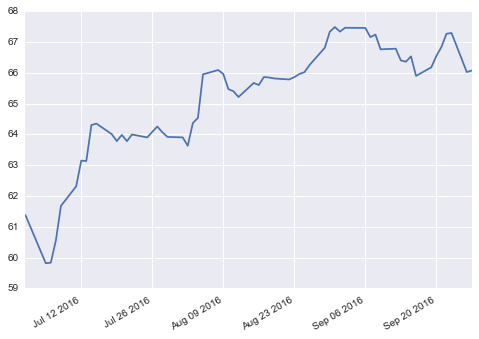

In [98]:
display(data_full['Trade Price'].tail(10))
data_full.ix[datetime(2016, 7, 1):]['Trade Price'].plot()
print(len(data_full.ix[datetime(2016, 7, 1):, 'Trade Price']))

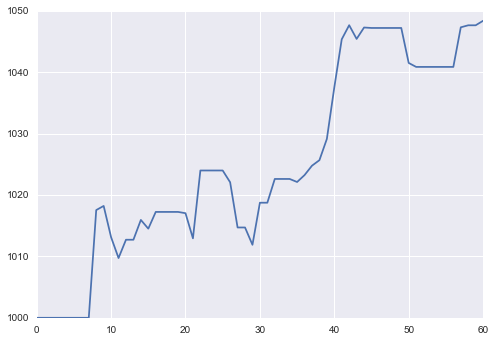

In [99]:
profit = [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1017.5500135000001, 1018.2249909999999, 1013.1249669999999, 1009.735006, 1012.7199955, 1012.7199955, 1015.9450254999999, 1014.5199955000001, 1017.2499744999999, 1017.2499744999999, 1017.2499744999999, 1017.2499744999999, 1017.0399669999998, 1012.9449894999999, 1024.0000060000002, 1024.0000060000002, 1024.0000060000002, 1024.0000060000002, 1022.0800585000003, 1014.7150075000004, 1014.7150075000004, 1011.8950360000006, 1018.7500330000007, 1018.7500330000007, 1022.6200420000008, 1022.6200420000008, 1022.6200420000008, 1022.1250585000008, 1023.2499955000008, 1024.7799865000006, 1025.680045000001, 1029.1450465000007, 1037.5299865000009, 1045.3750135000007, 1047.6700225000009, 1045.4350120000008, 1047.2950150000011, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1041.520067500001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1047.3251215000012, 1047.6551365000009, 1047.6551365000009, 1048.3901845000009]
profit_s = pd.Series(profit)
profit_s[:].plot()
